In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [3]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [4]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [7]:
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [9]:
# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [10]:
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

ValueError: Dimension 1 in both shapes must be equal, but are 1 and 4. Shapes are [5,1] and [5,4].
	From merging shape 0 with other shapes. for 'concat/concat_dim' (op: 'Pack') with input shapes: [5,1], [5,4].

In [11]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

ValueError: No gradients provided for any variable, check your graph for ops that do not support gradients, between variables ["<tf.Variable 'Variable:0' shape=(5, 4) dtype=float32_ref>", "<tf.Variable 'Variable_1:0' shape=(1, 4) dtype=float32_ref>", "<tf.Variable 'Variable_2:0' shape=(5, 4) dtype=float32_ref>", "<tf.Variable 'Variable_3:0' shape=(1, 4) dtype=float32_ref>", "<tf.Variable 'Variable_4:0' shape=(4, 2) dtype=float32_ref>", "<tf.Variable 'Variable_5:0' shape=(1, 2) dtype=float32_ref>"] and loss Tensor("Mean:0", shape=(), dtype=float32).

In [12]:

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

In [ ]:

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Loss 0.74285394


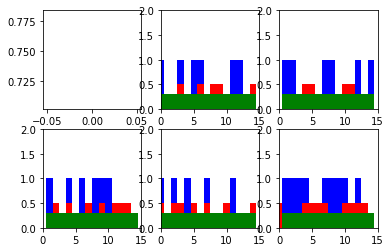

Step 100 Loss 0.6925051


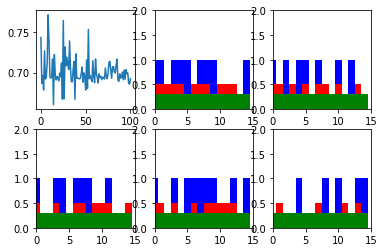

Step 200 Loss 0.68808115


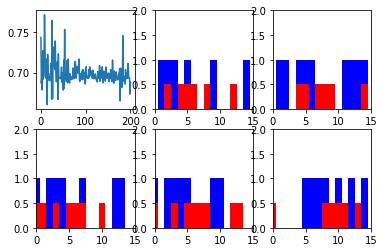

Step 300 Loss 0.6913426


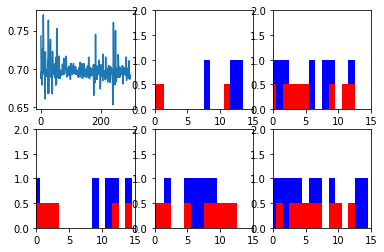

Step 400 Loss 0.69359326


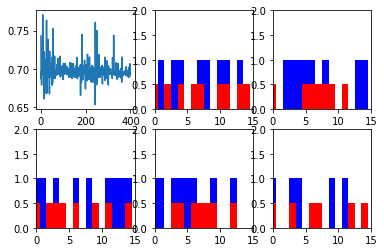

Step 500 Loss 0.70142305


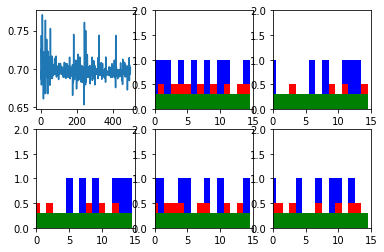

Step 600 Loss 0.68378514


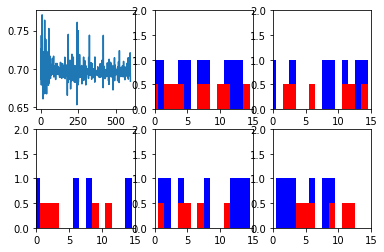

New data, epoch 1
Step 0 Loss 0.68891066


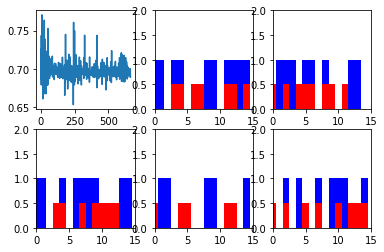

Step 100 Loss 0.693528


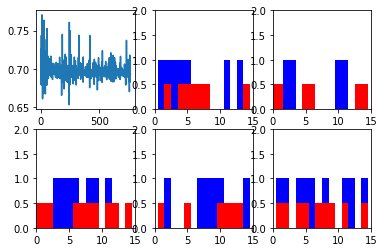

Step 200 Loss 0.6930433


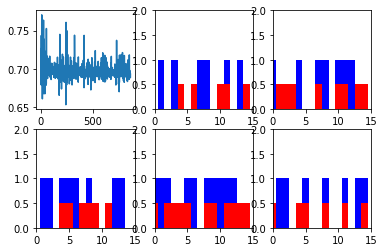

Step 300 Loss 0.69268674


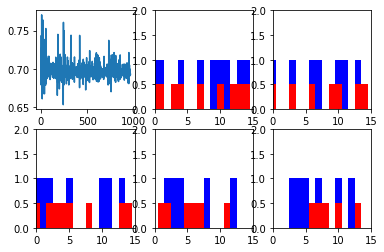

Step 400 Loss 0.6866586


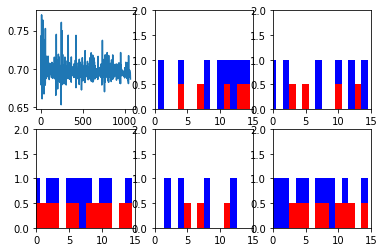

Step 500 Loss 0.69234324


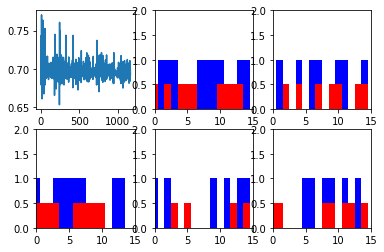

Step 600 Loss 0.6891471


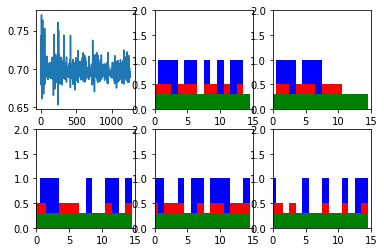

New data, epoch 2
Step 0 Loss 0.6885157


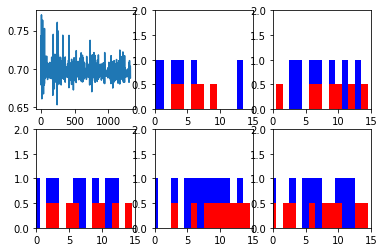

Step 100 Loss 0.69404376


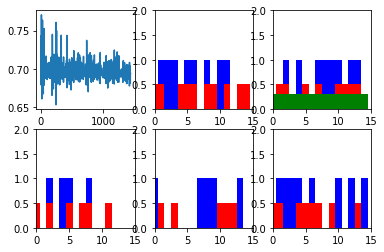

Step 200 Loss 0.6995416


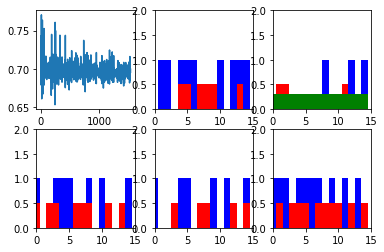

Step 300 Loss 0.69012356


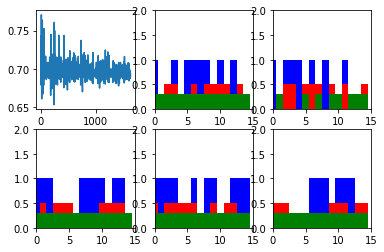

Step 400 Loss 0.69206387


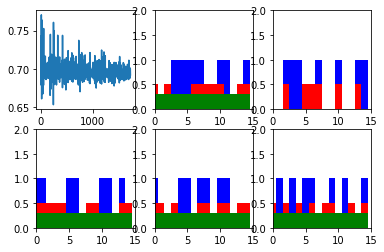

Step 500 Loss 0.699204


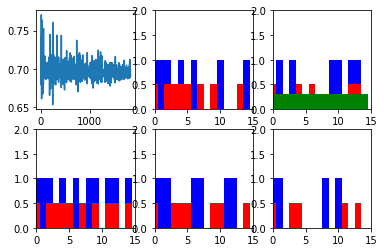

Step 600 Loss 0.69247127


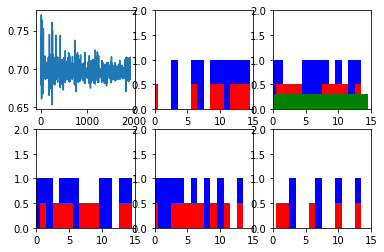

New data, epoch 3
Step 0 Loss 0.68839985


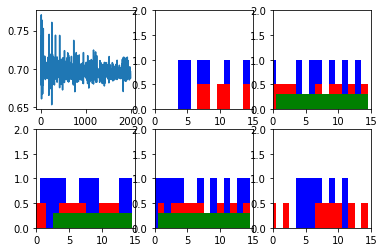

Step 100 Loss 0.7016097


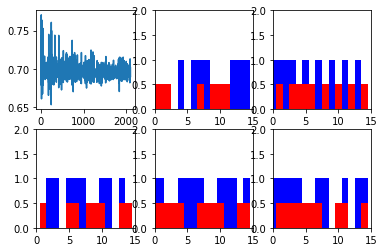

Step 200 Loss 0.6905463


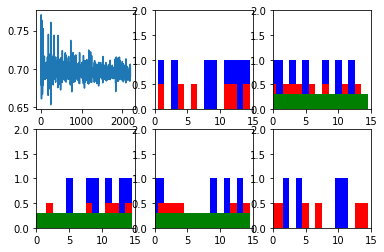

Step 300 Loss 0.69277346


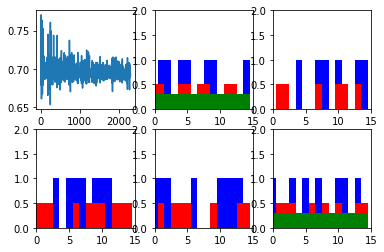

Step 400 Loss 0.69831276


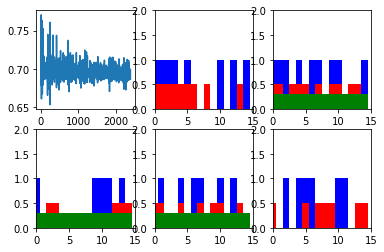

Step 500 Loss 0.6944312


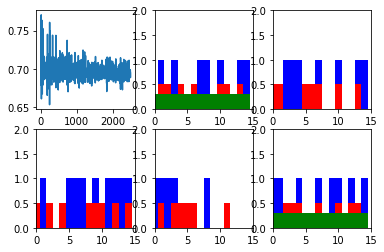

Step 600 Loss 0.6961414


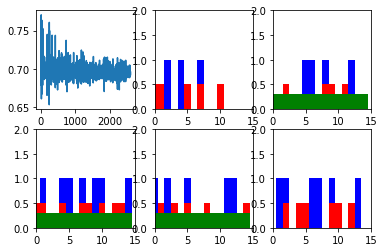

New data, epoch 4
Step 0 Loss 0.69925576


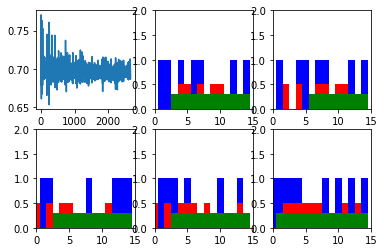

Step 100 Loss 0.6945886


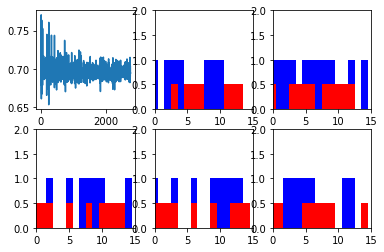

Step 200 Loss 0.69009906


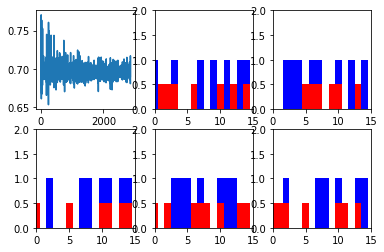

Step 300 Loss 0.6931601


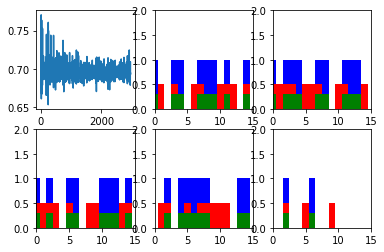

Step 400 Loss 0.6923893


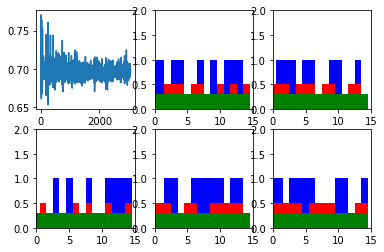

Step 500 Loss 0.6827352


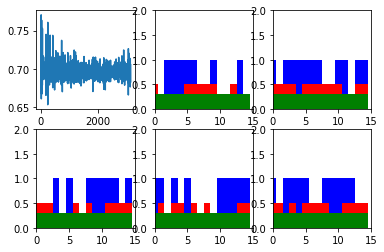

Step 600 Loss 0.69377637


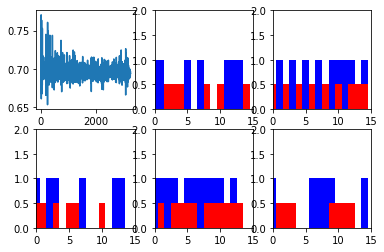

New data, epoch 5
Step 0 Loss 0.68408567


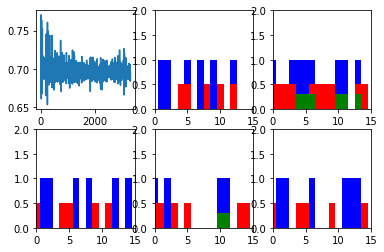

Step 100 Loss 0.692461


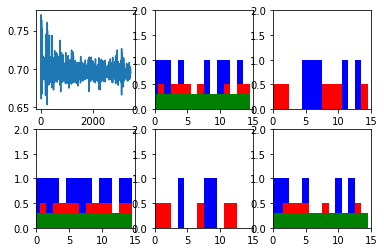

Step 200 Loss 0.6843672


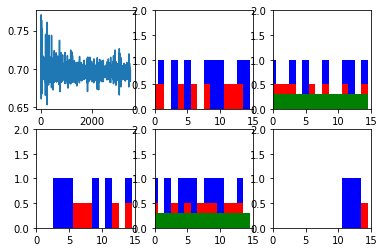

Step 300 Loss 0.69367707


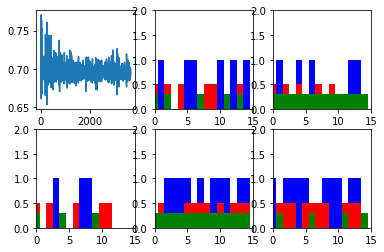

Step 400 Loss 0.69556105


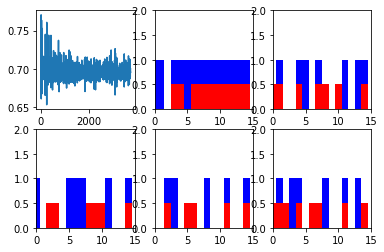

Step 500 Loss 0.6986807


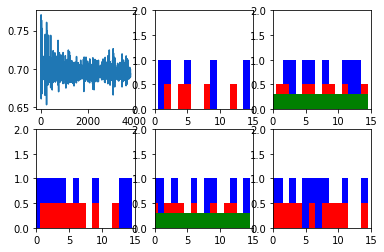

Step 600 Loss 0.694924


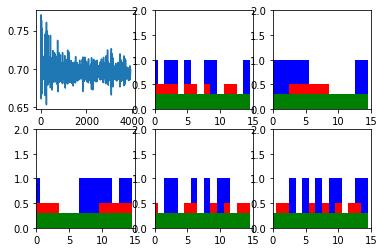

New data, epoch 6
Step 0 Loss 0.68945366


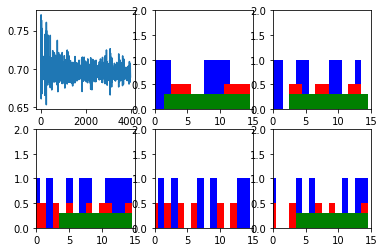

Step 100 Loss 0.6934053


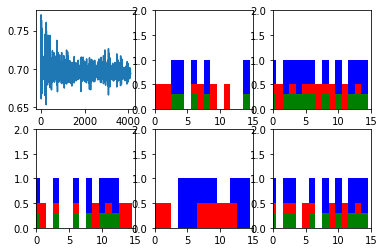

Step 200 Loss 0.69558084


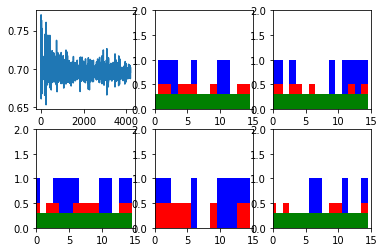

Step 300 Loss 0.6950266


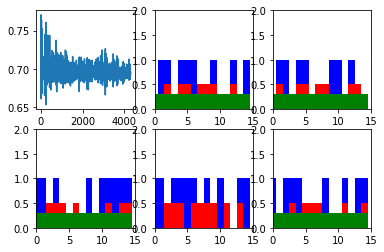

Step 400 Loss 0.70384806


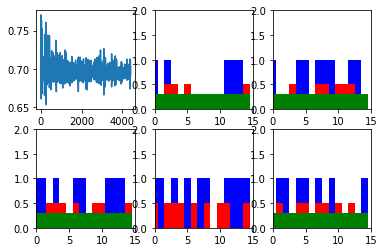

Step 500 Loss 0.70309246


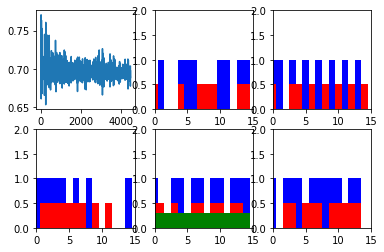

Step 600 Loss 0.6881124


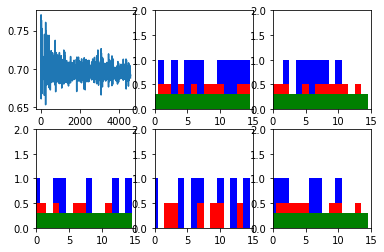

New data, epoch 7
Step 0 Loss 0.6884945


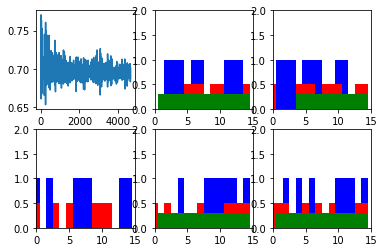

Step 100 Loss 0.6909079


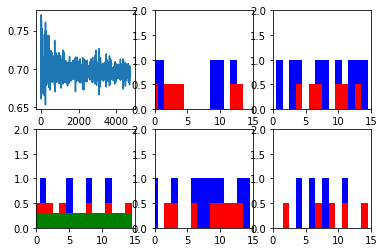

Step 200 Loss 0.68910706


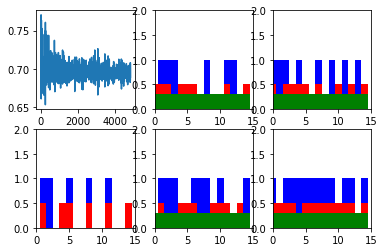

Step 300 Loss 0.6933375


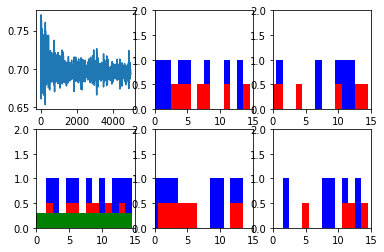

Step 400 Loss 0.6930742


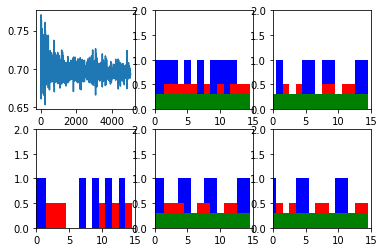

Step 500 Loss 0.68939406


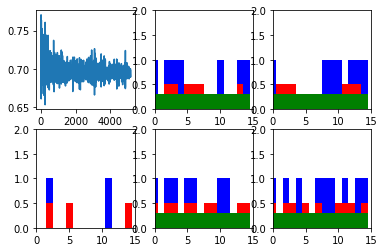

Step 600 Loss 0.6927862


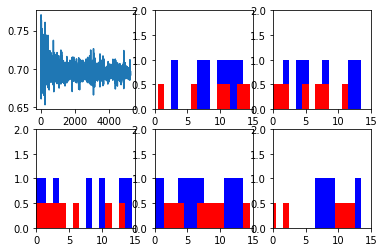

New data, epoch 8
Step 0 Loss 0.69441277


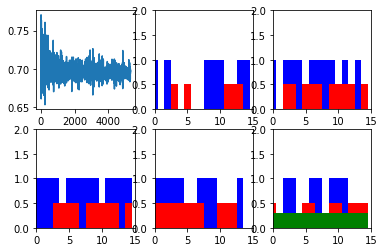

Step 100 Loss 0.6917792


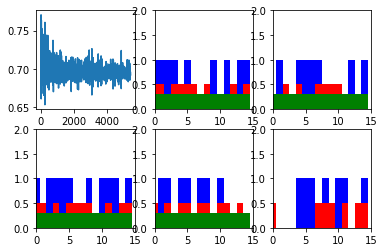

Step 200 Loss 0.6941942


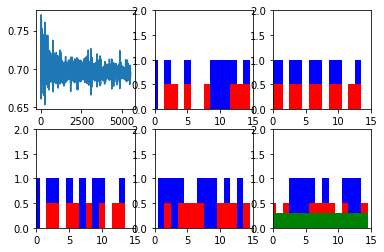

Step 300 Loss 0.691436


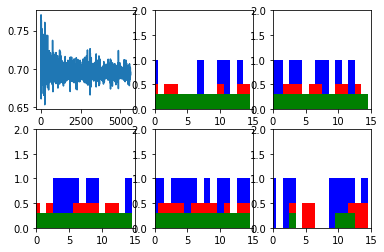

Step 400 Loss 0.69969386


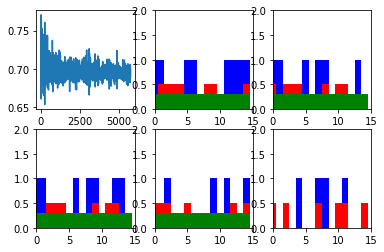

Step 500 Loss 0.68971163


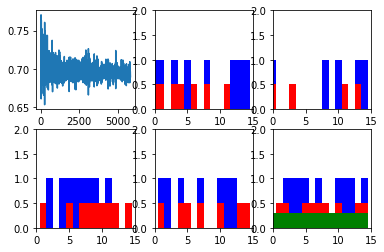

Step 600 Loss 0.69798017


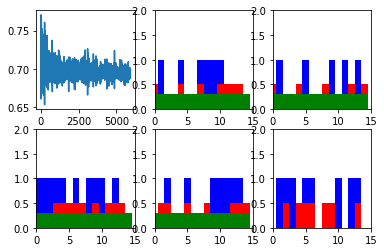

New data, epoch 9
Step 0 Loss 0.6840606


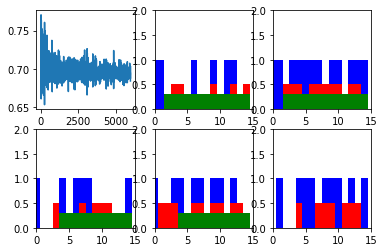

Step 100 Loss 0.6945654


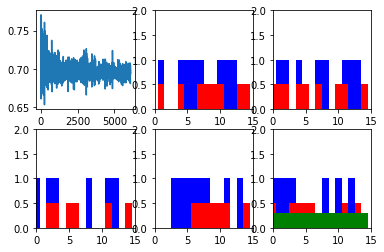

Step 200 Loss 0.69346476


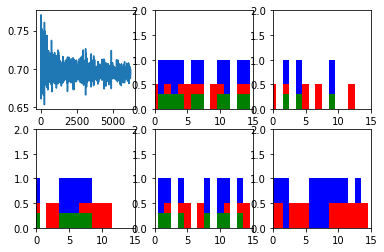

Step 300 Loss 0.6868821


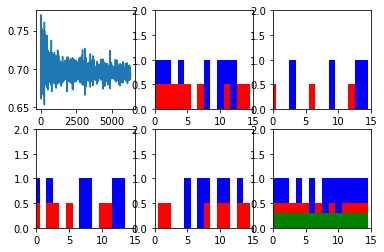

Step 400 Loss 0.6940555


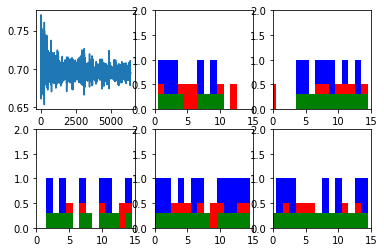

Step 500 Loss 0.7011655


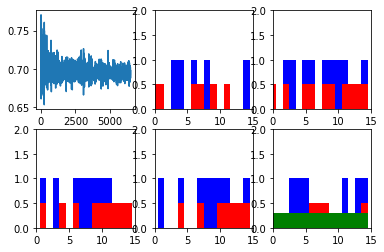

Step 600 Loss 0.6998854


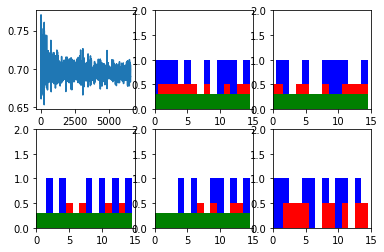

New data, epoch 10
Step 0 Loss 0.707799


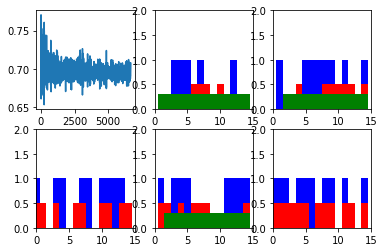

Step 100 Loss 0.69482434


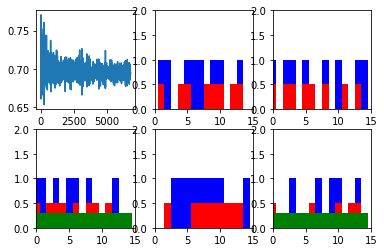

Step 200 Loss 0.69171876


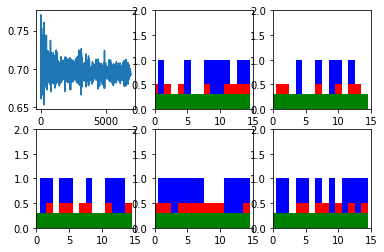

Step 300 Loss 0.6934113


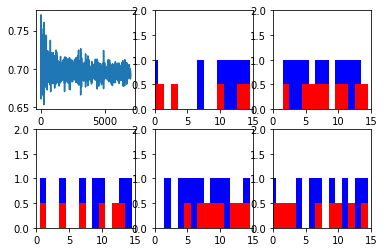

Step 400 Loss 0.6951292


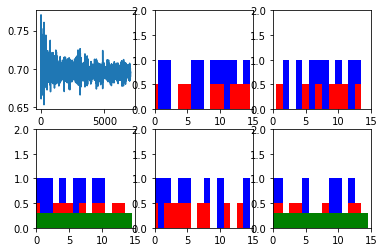

Step 500 Loss 0.6850976


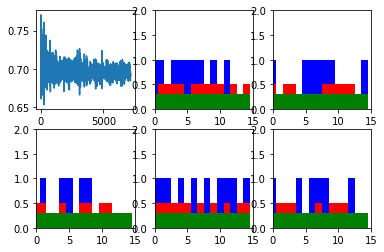

Step 600 Loss 0.6932231


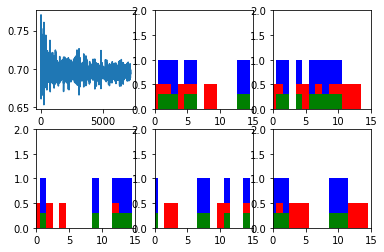

New data, epoch 11
Step 0 Loss 0.6918735


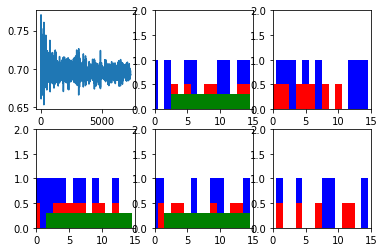

Step 100 Loss 0.69397485


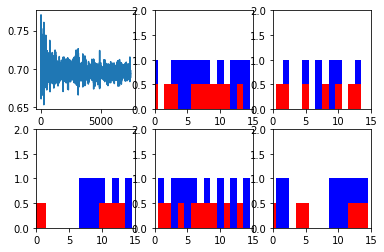

Step 200 Loss 0.6974035


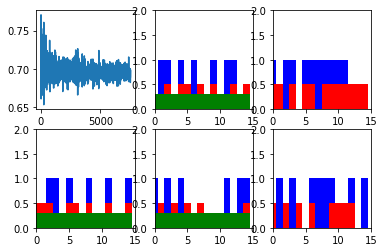

Step 300 Loss 0.6924957


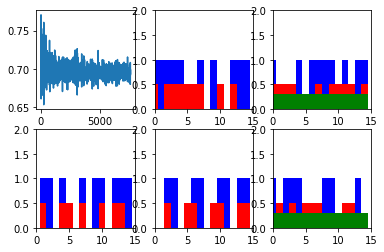

Step 400 Loss 0.6921665


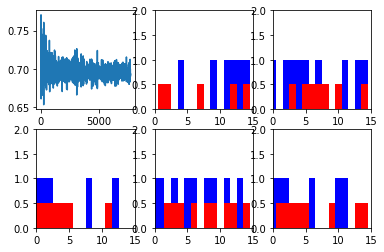

Step 500 Loss 0.69323045


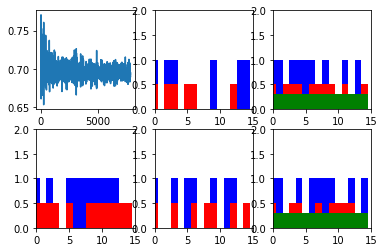

Step 600 Loss 0.69275707


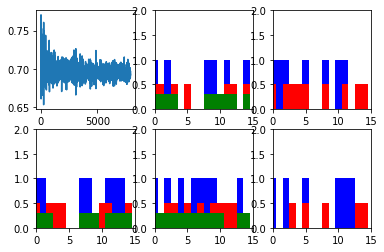

New data, epoch 12
Step 0 Loss 0.69367635


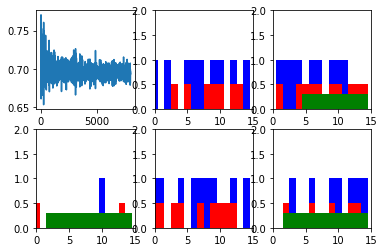

Step 100 Loss 0.6916325


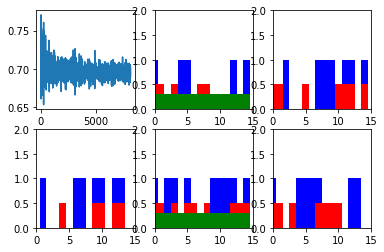

Step 200 Loss 0.69397557


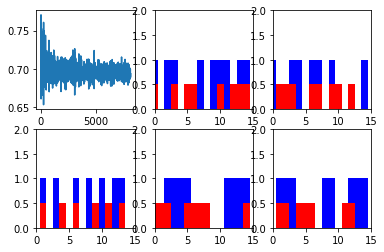

Step 300 Loss 0.69560623


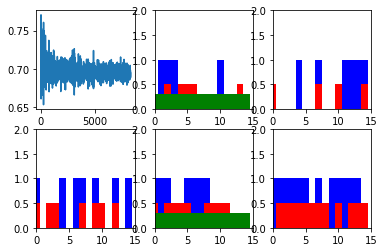

Step 400 Loss 0.6922496


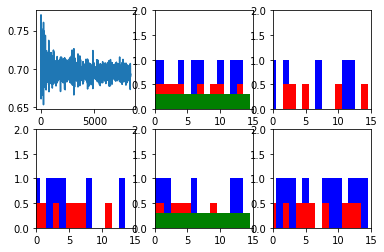

Step 500 Loss 0.69455564


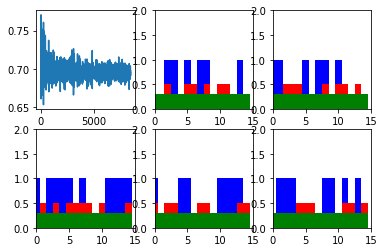

Step 600 Loss 0.6937561


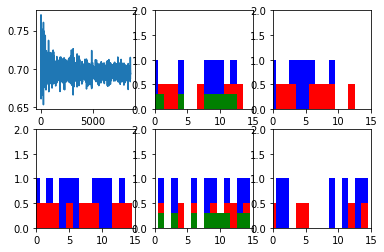

New data, epoch 13
Step 0 Loss 0.6868212


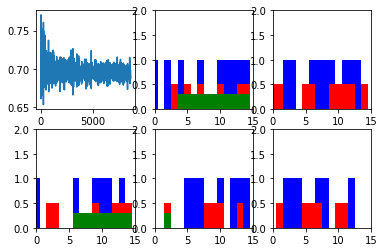

Step 100 Loss 0.6966532


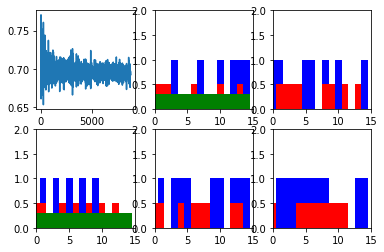

Step 200 Loss 0.6954994


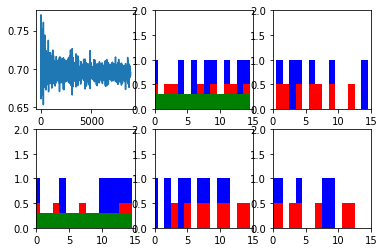

Step 300 Loss 0.6918169


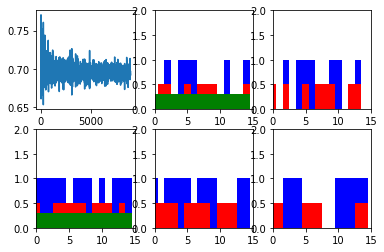

Step 400 Loss 0.69221556


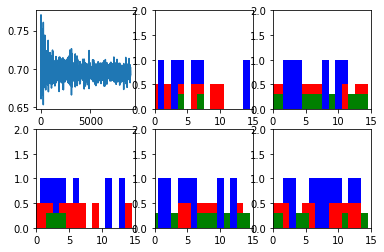

Step 500 Loss 0.69996244


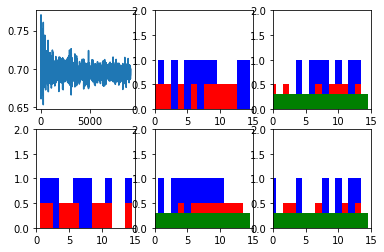

Step 600 Loss 0.688949


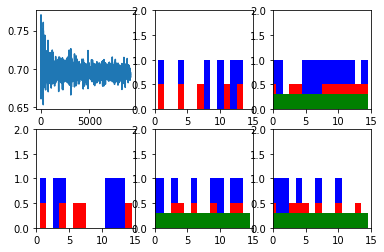

New data, epoch 14
Step 0 Loss 0.68993604


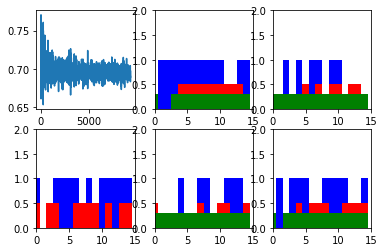

Step 100 Loss 0.6916632


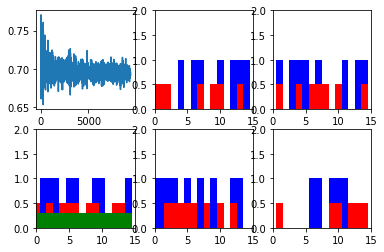

Step 200 Loss 0.7022591


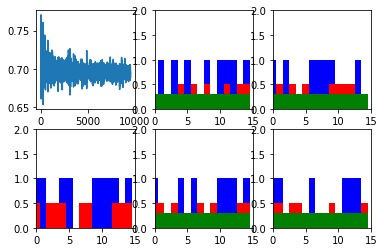

Step 300 Loss 0.6911933


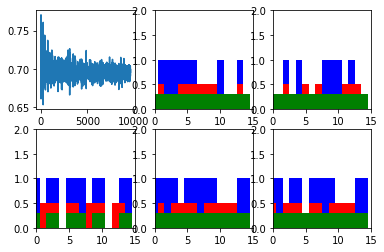

Step 400 Loss 0.6903661


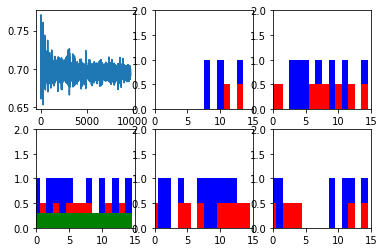

Step 500 Loss 0.69507486


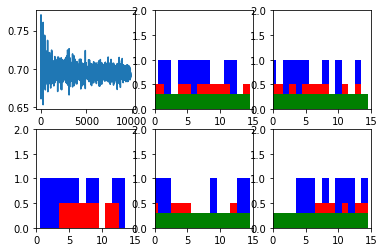

Step 600 Loss 0.69516903


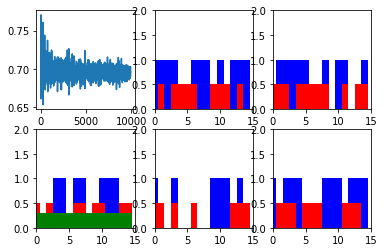

New data, epoch 15
Step 0 Loss 0.69655246


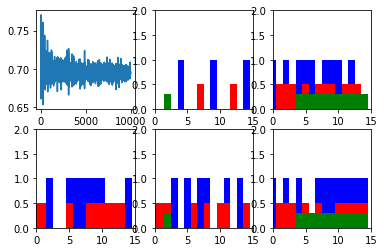

Step 100 Loss 0.69300133


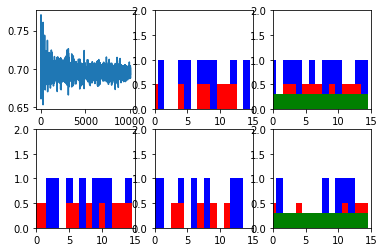

Step 200 Loss 0.6874766


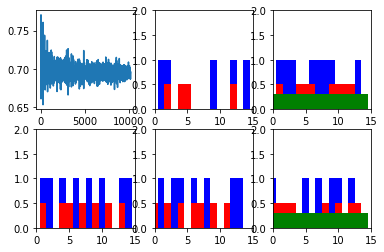

Step 300 Loss 0.68987304


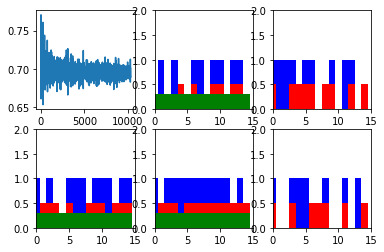

Step 400 Loss 0.69284475


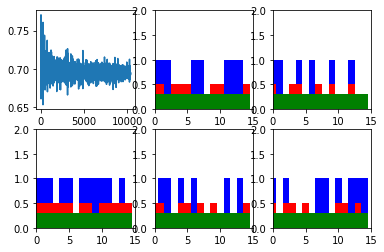

Step 500 Loss 0.6875683


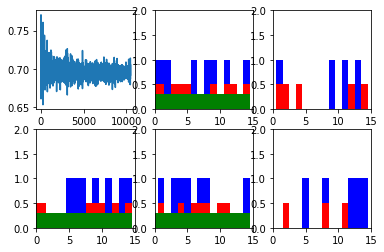

Step 600 Loss 0.69401944


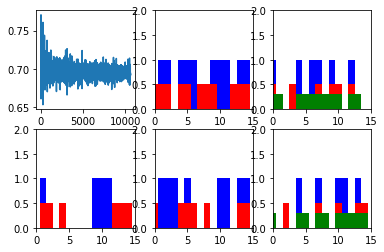

New data, epoch 16
Step 0 Loss 0.69086367


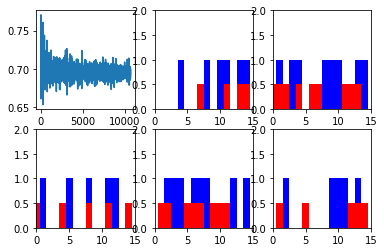

Step 100 Loss 0.68819547


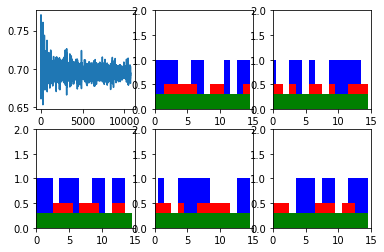

Step 200 Loss 0.69951594


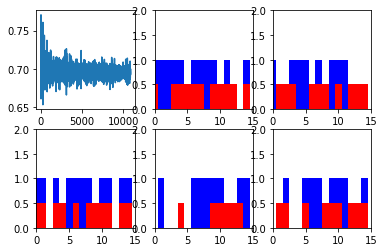

Step 300 Loss 0.6976983


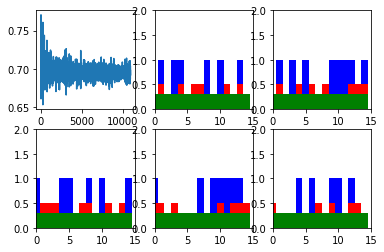

Step 400 Loss 0.6931425


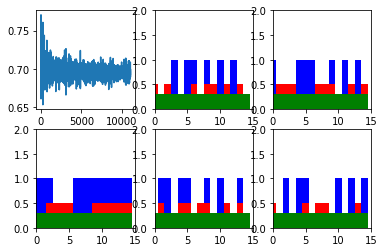

Step 500 Loss 0.6909554


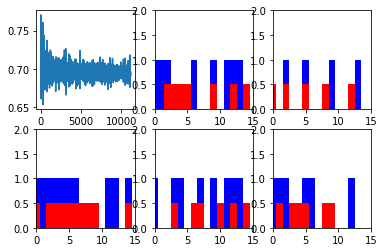

Step 600 Loss 0.69046825


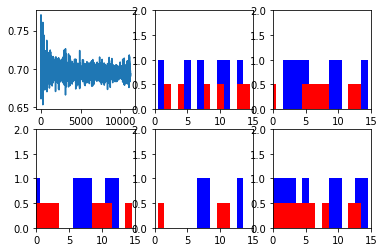

New data, epoch 17
Step 0 Loss 0.68947273


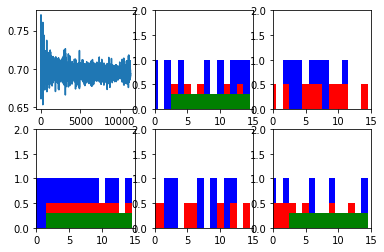

Step 100 Loss 0.70043355


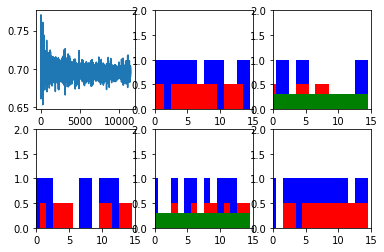

Step 200 Loss 0.69142514


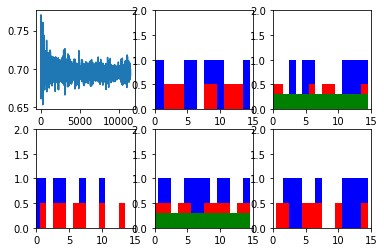

Step 300 Loss 0.6956091


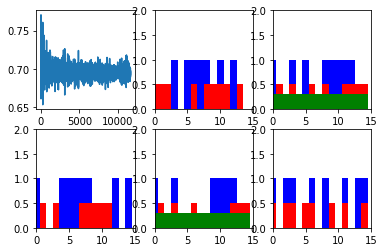

Step 400 Loss 0.6949541


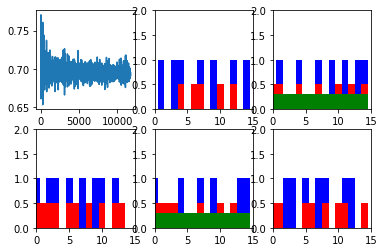

Step 500 Loss 0.6922346


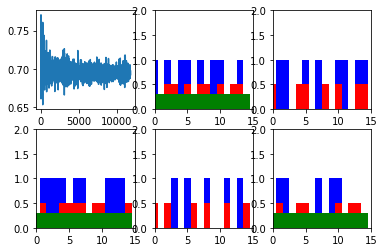

Step 600 Loss 0.69376016


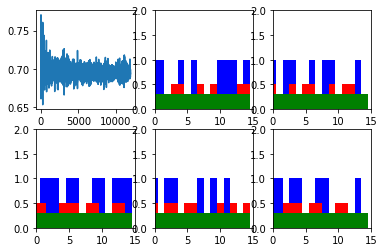

New data, epoch 18
Step 0 Loss 0.69271994


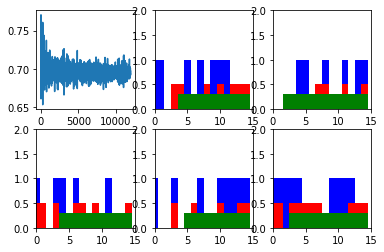

Step 100 Loss 0.6933219


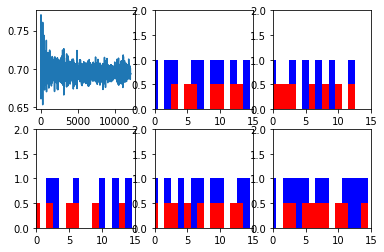

Step 200 Loss 0.69421226


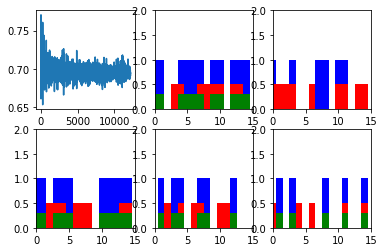

Step 300 Loss 0.6929403


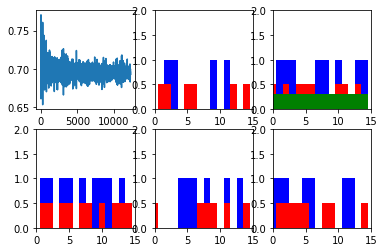

Step 400 Loss 0.69582283


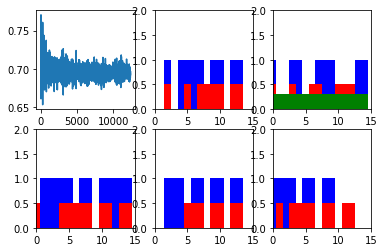

Step 500 Loss 0.69403785


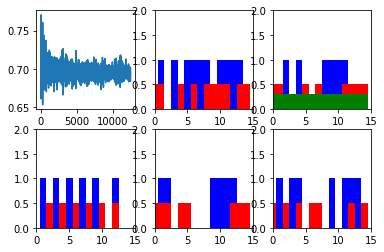

Step 600 Loss 0.69165546


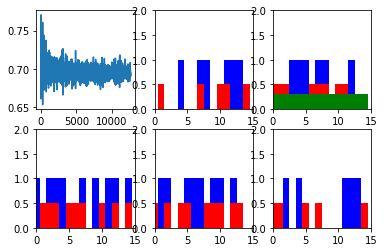

New data, epoch 19
Step 0 Loss 0.68576294


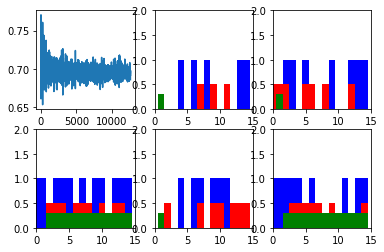

Step 100 Loss 0.69232297


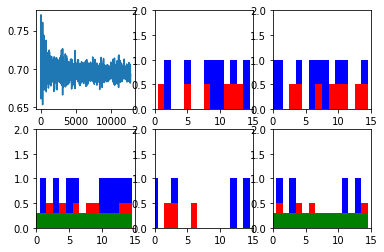

Step 200 Loss 0.7042447


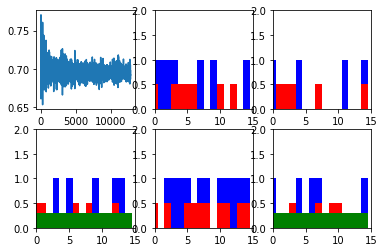

Step 300 Loss 0.6886799


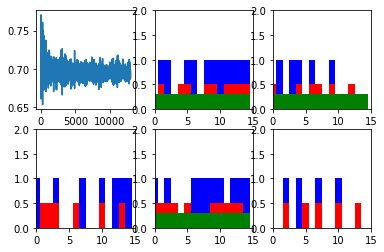

Step 400 Loss 0.6924272


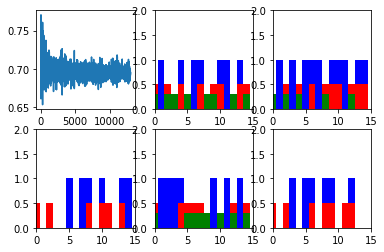

Step 500 Loss 0.6937156


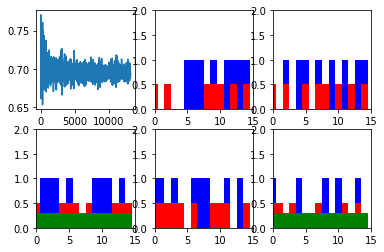

Step 600 Loss 0.7031031


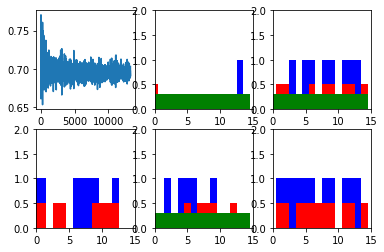

New data, epoch 20
Step 0 Loss 0.6850451


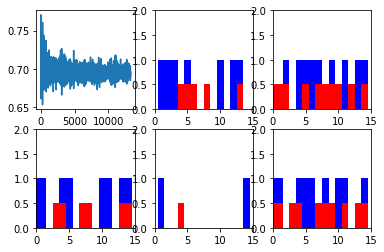

Step 100 Loss 0.69197327


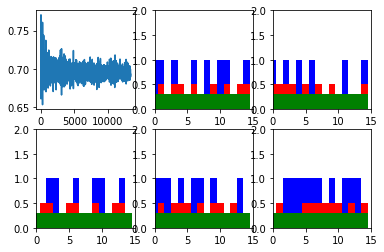

Step 200 Loss 0.70310736


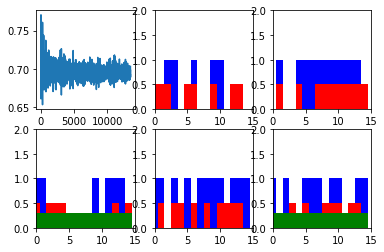

Step 300 Loss 0.69285995


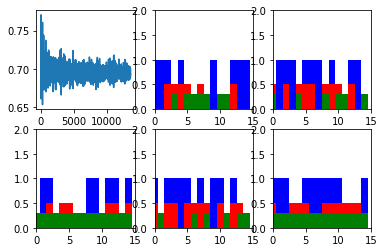

Step 400 Loss 0.69524646


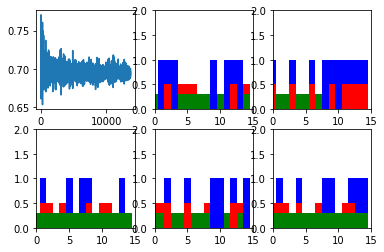

Step 500 Loss 0.6906096


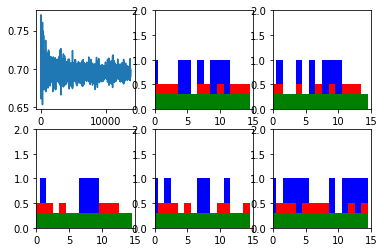

Step 600 Loss 0.69292676


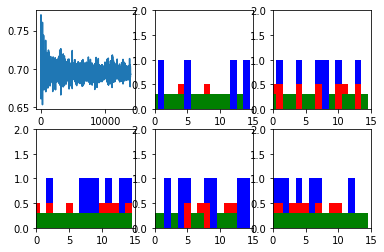

New data, epoch 21
Step 0 Loss 0.69513226


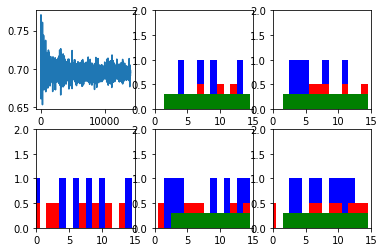

Step 100 Loss 0.69357365


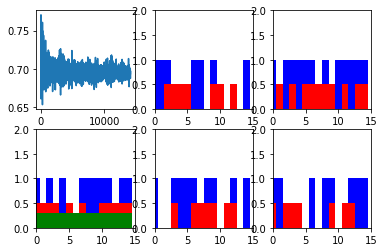

Step 200 Loss 0.69400215


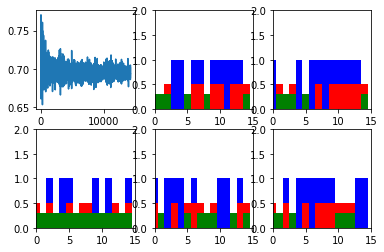

Step 300 Loss 0.6921345


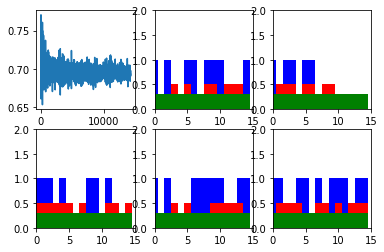

Step 400 Loss 0.68935096


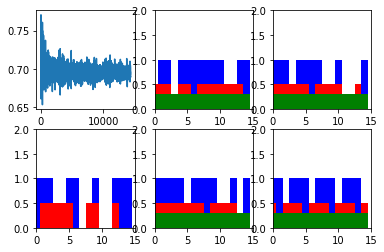

Step 500 Loss 0.6962565


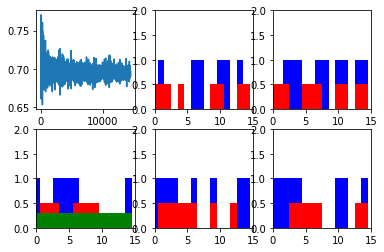

Step 600 Loss 0.6948163


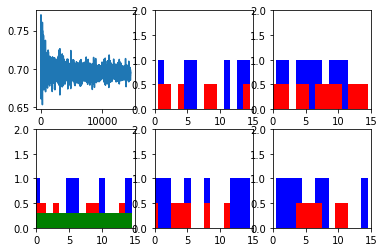

New data, epoch 22
Step 0 Loss 0.6769161


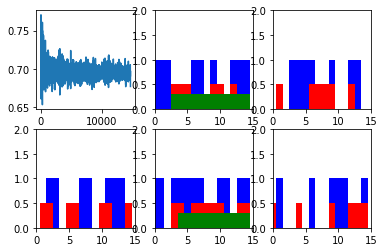

Step 100 Loss 0.6906713


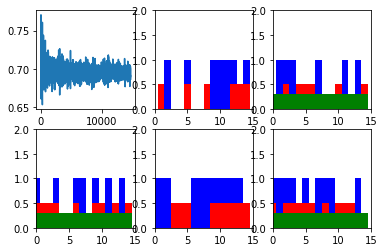

Step 200 Loss 0.6953689


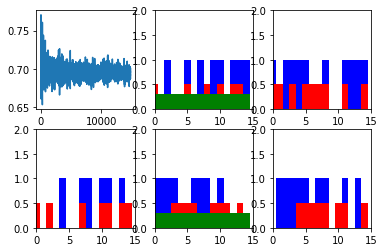

Step 300 Loss 0.6948504


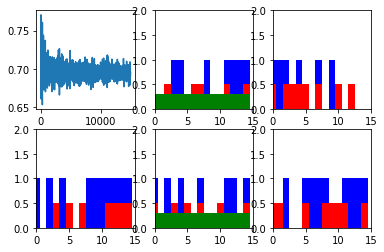

Step 400 Loss 0.6962087


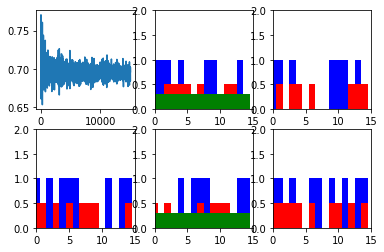

Step 500 Loss 0.6934953


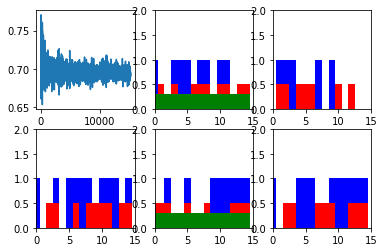

Step 600 Loss 0.69437957


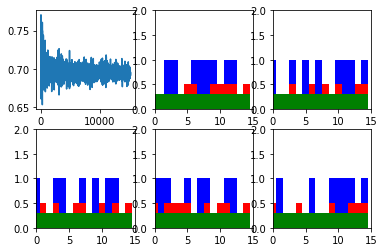

New data, epoch 23
Step 0 Loss 0.6922341


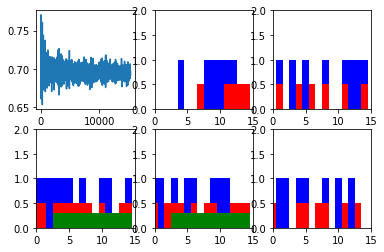

Step 100 Loss 0.69133604


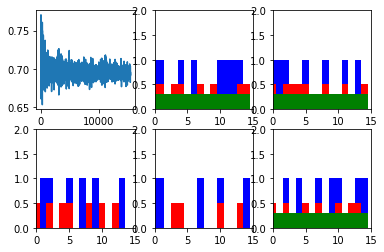

Step 200 Loss 0.69910055


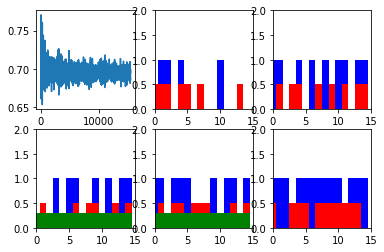

Step 300 Loss 0.6963063


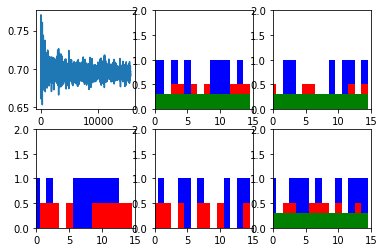

Step 400 Loss 0.6917907


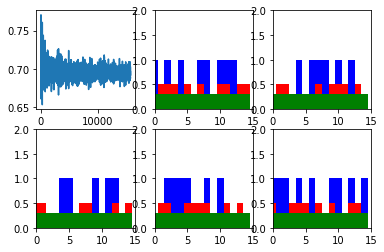

Step 500 Loss 0.69338375


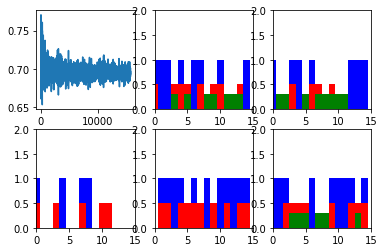

Step 600 Loss 0.69423586


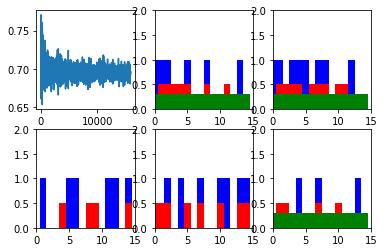

New data, epoch 24
Step 0 Loss 0.6828583


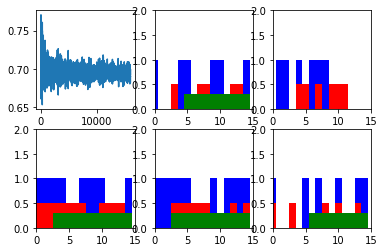

Step 100 Loss 0.6936193


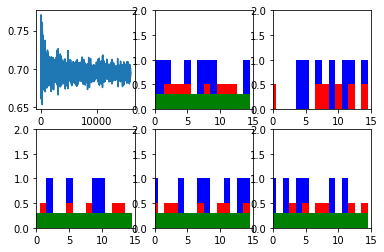

Step 200 Loss 0.69672954


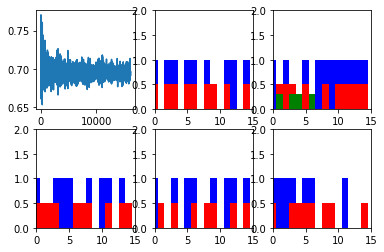

Step 300 Loss 0.69313717


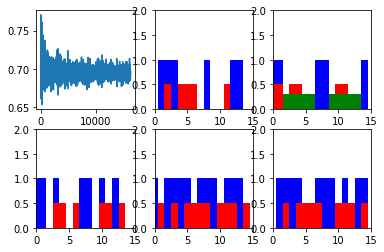

Step 400 Loss 0.6934931


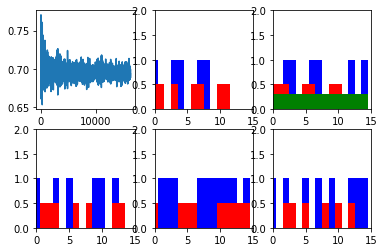

Step 500 Loss 0.69462186


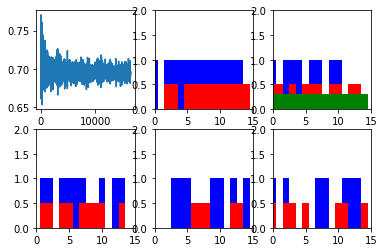

Step 600 Loss 0.6930683


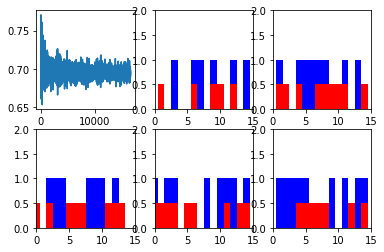

New data, epoch 25
Step 0 Loss 0.70353913


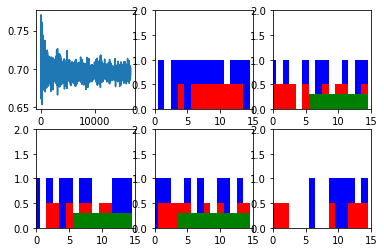

Step 100 Loss 0.6929233


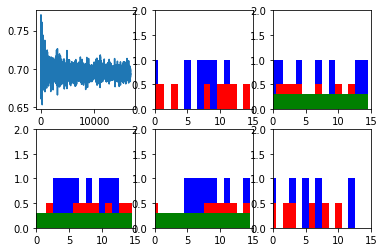

Step 200 Loss 0.6923853


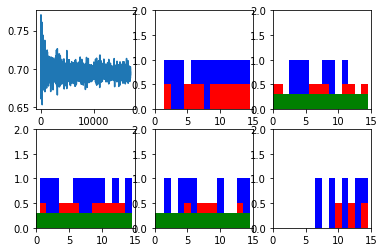

Step 300 Loss 0.69334424


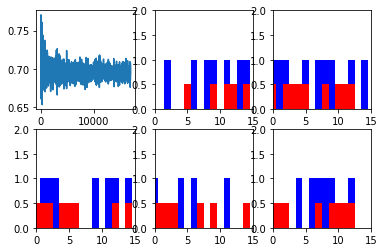

Step 400 Loss 0.6915427


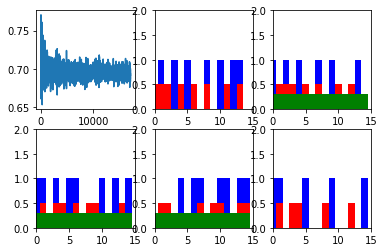

Step 500 Loss 0.69045883


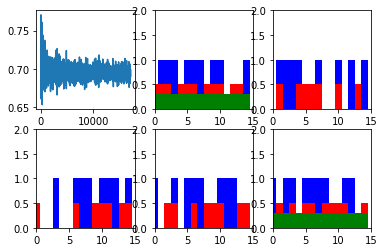

Step 600 Loss 0.69584864


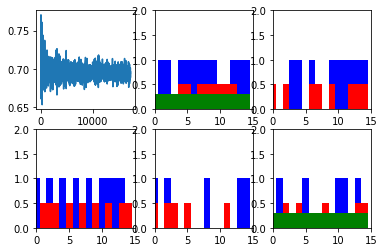

New data, epoch 26
Step 0 Loss 0.68103683


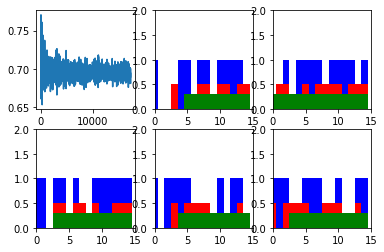

Step 100 Loss 0.6909015


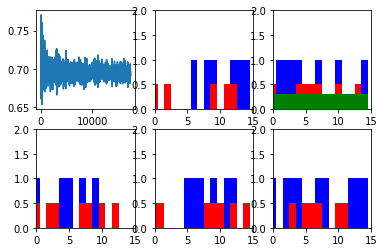

Step 200 Loss 0.69367105


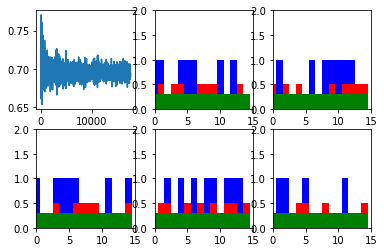

Step 300 Loss 0.698596


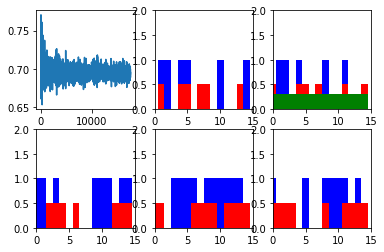

Step 400 Loss 0.6943764


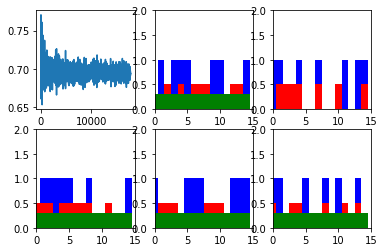

Step 500 Loss 0.69737154


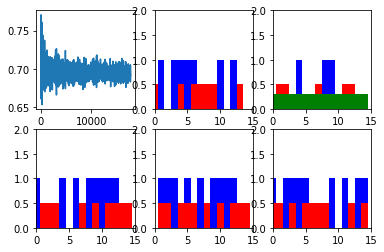

Step 600 Loss 0.6939635


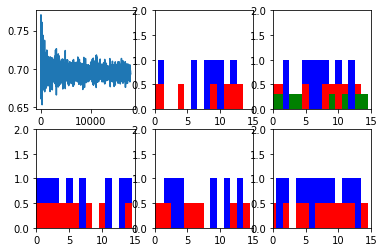

New data, epoch 27
Step 0 Loss 0.6839029


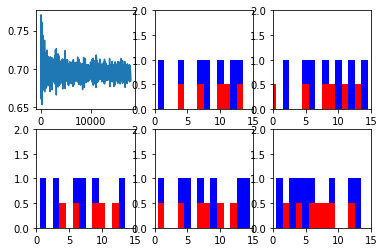

Step 100 Loss 0.694511


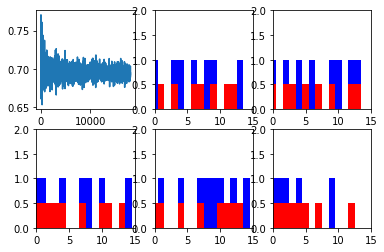

Step 200 Loss 0.69360065


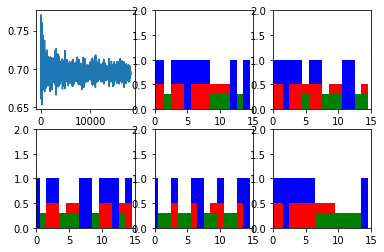

Step 300 Loss 0.68354744


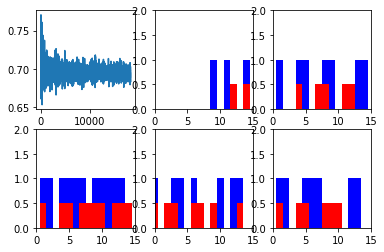

Step 400 Loss 0.6916195


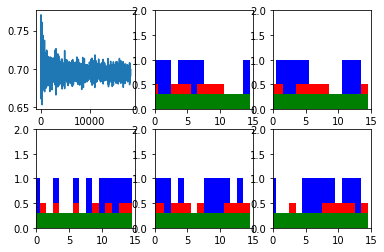

Step 500 Loss 0.69203043


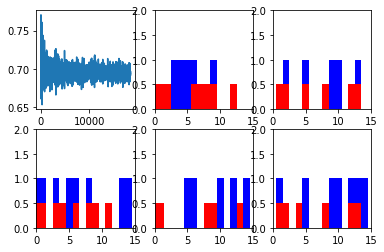

Step 600 Loss 0.6907738


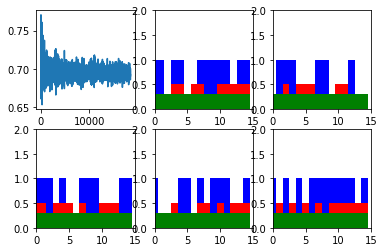

New data, epoch 28
Step 0 Loss 0.6952807


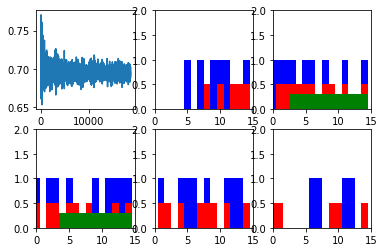

Step 100 Loss 0.6951081


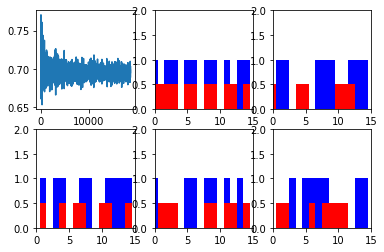

Step 200 Loss 0.6932082


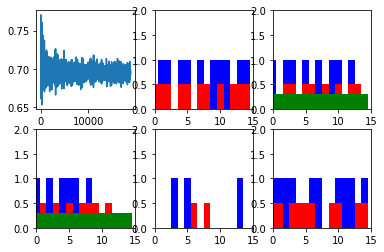

Step 300 Loss 0.69448817


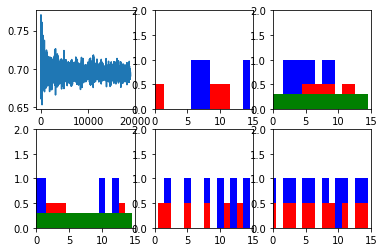

Step 400 Loss 0.69678897


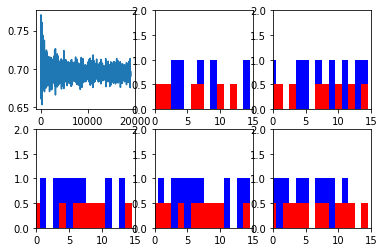

Step 500 Loss 0.69259197


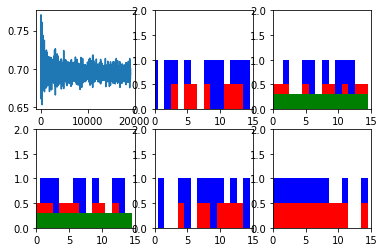

Step 600 Loss 0.69926834


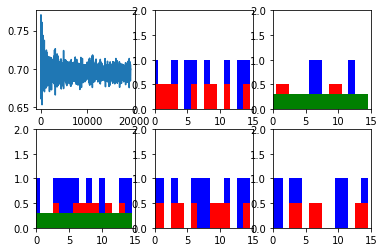

New data, epoch 29
Step 0 Loss 0.68732315


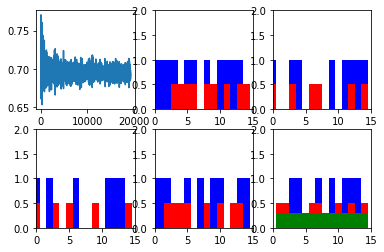

Step 100 Loss 0.6933023


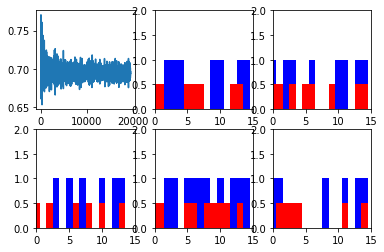

Step 200 Loss 0.6913684


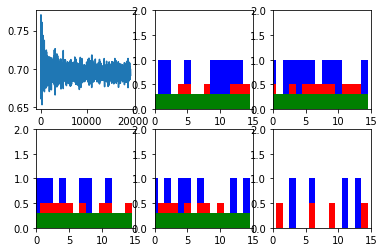

Step 300 Loss 0.6926365


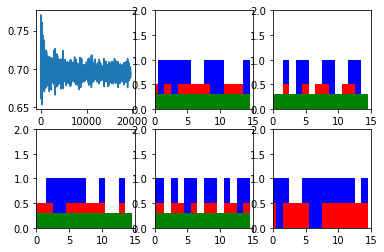

Step 400 Loss 0.69382644


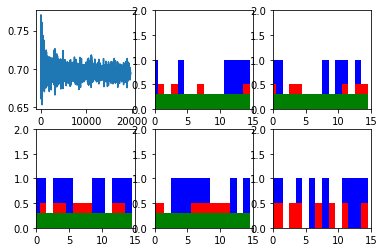

Step 500 Loss 0.6935309


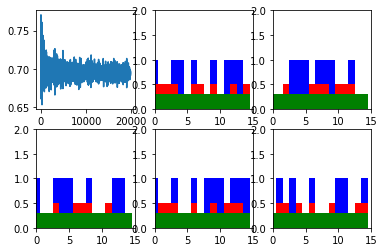

Step 600 Loss 0.6936328


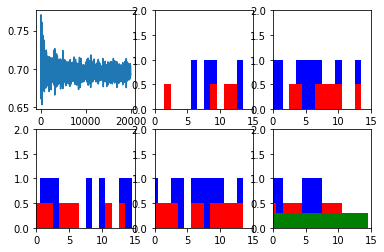

New data, epoch 30
Step 0 Loss 0.690724


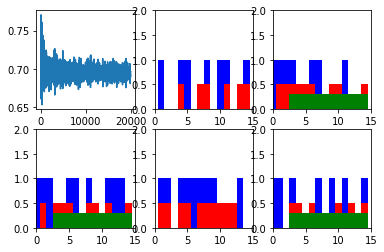

Step 100 Loss 0.69004667


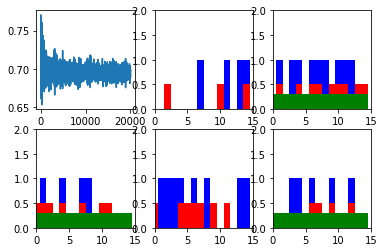

Step 200 Loss 0.69167113


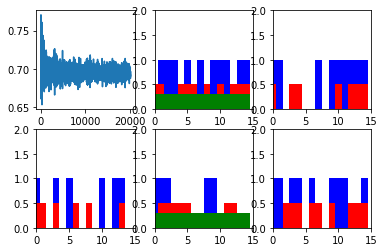

Step 300 Loss 0.6925129


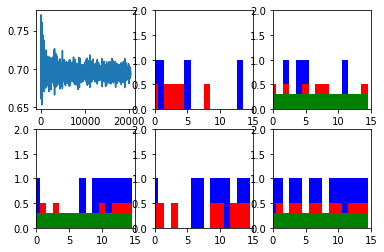

Step 400 Loss 0.69376624


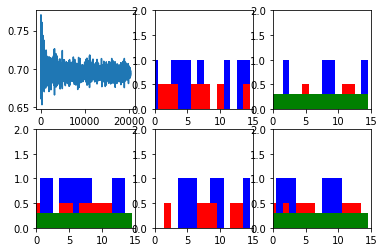

Step 500 Loss 0.6938152


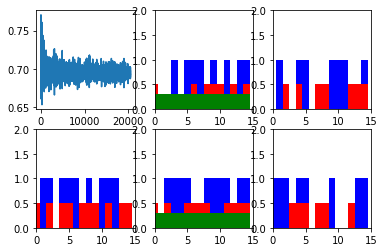

Step 600 Loss 0.6933919


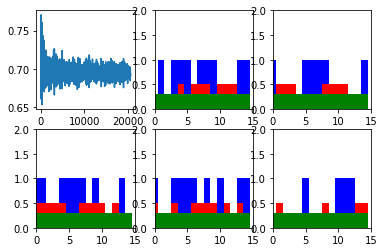

New data, epoch 31
Step 0 Loss 0.68370396


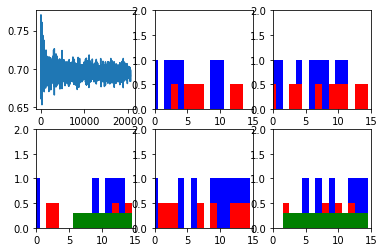

Step 100 Loss 0.6893693


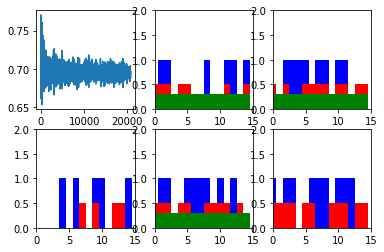

Step 200 Loss 0.6929067


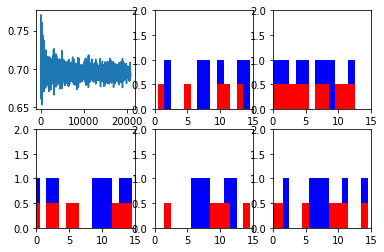

Step 300 Loss 0.6947262


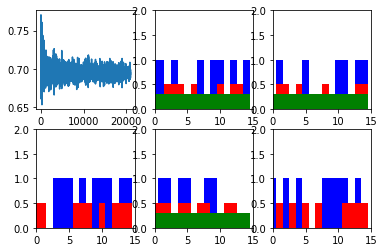

Step 400 Loss 0.6852754


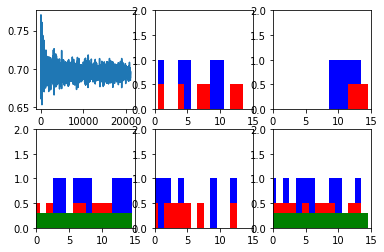

Step 500 Loss 0.6905057


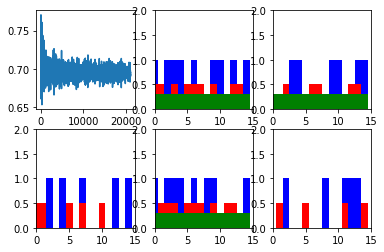

Step 600 Loss 0.6924067


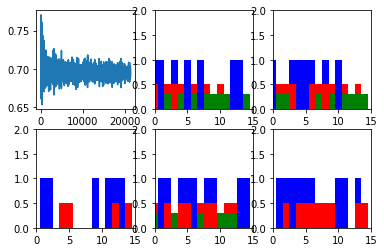

New data, epoch 32
Step 0 Loss 0.6895522


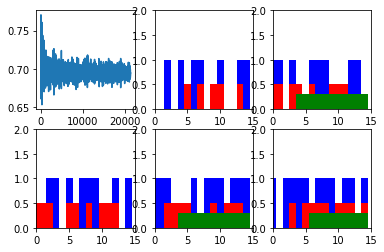

Step 100 Loss 0.6917687


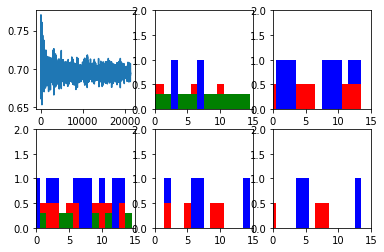

Step 200 Loss 0.6931303


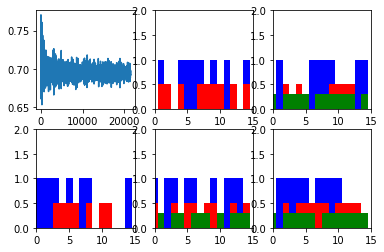

Step 300 Loss 0.69426674


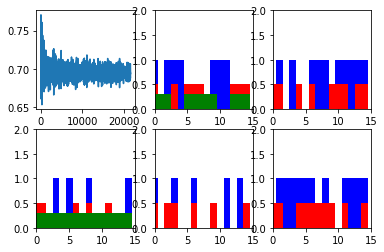

Step 400 Loss 0.69178075


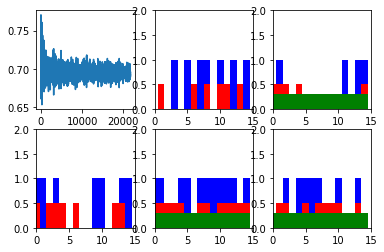

Step 500 Loss 0.69211453


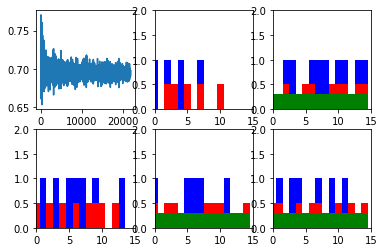

Step 600 Loss 0.6952121


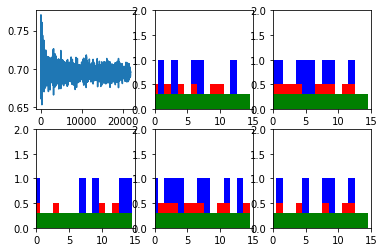

New data, epoch 33
Step 0 Loss 0.6869191


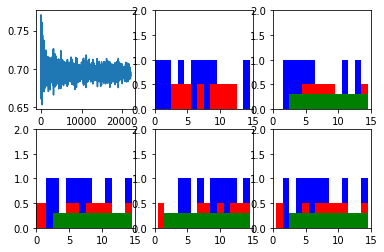

Step 100 Loss 0.69150835


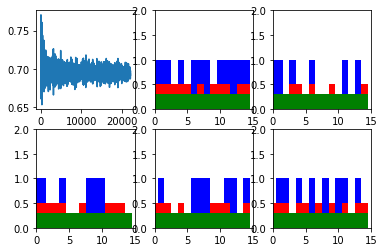

Step 200 Loss 0.69301516


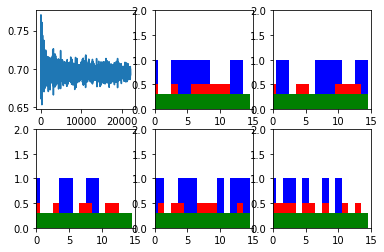

Step 300 Loss 0.6952333


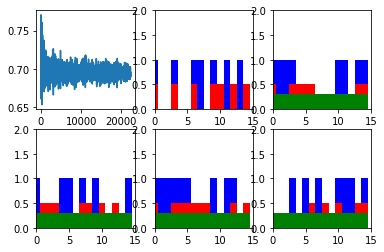

Step 400 Loss 0.6937187


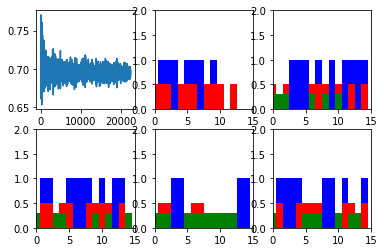

Step 500 Loss 0.6891004


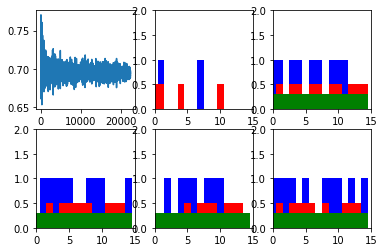

Step 600 Loss 0.6942335


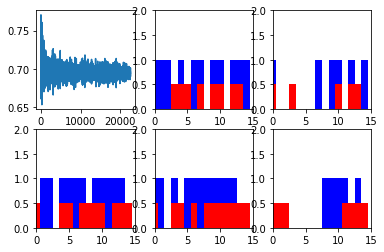

New data, epoch 34
Step 0 Loss 0.6917272


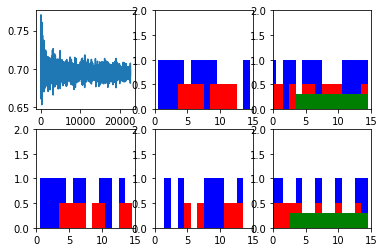

Step 100 Loss 0.6907375


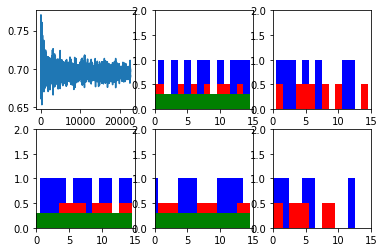

Step 200 Loss 0.6937969


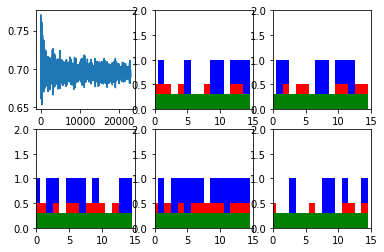

Step 300 Loss 0.69141567


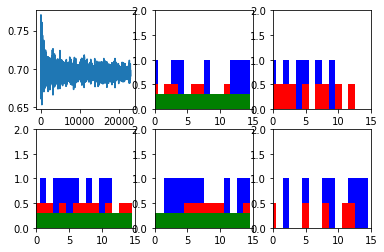

Step 400 Loss 0.69930357


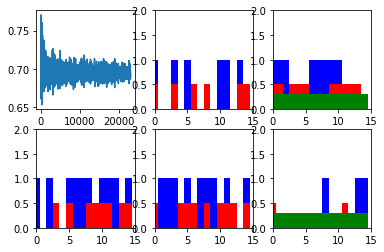

Step 500 Loss 0.69403386


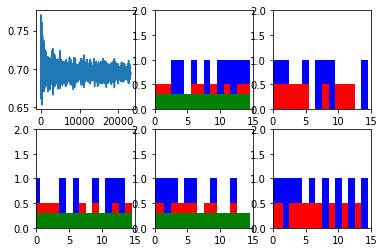

Step 600 Loss 0.69107616


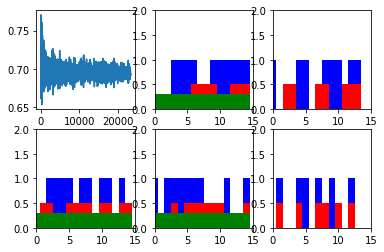

New data, epoch 35
Step 0 Loss 0.6728007


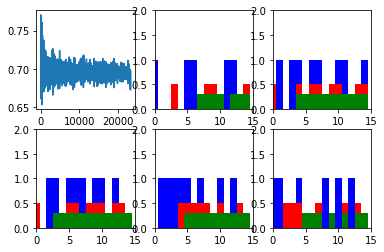

Step 100 Loss 0.6957087


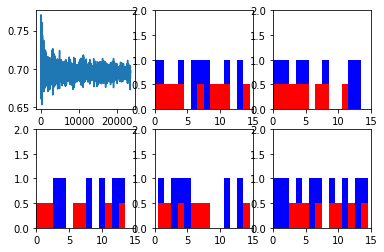

Step 200 Loss 0.6931445


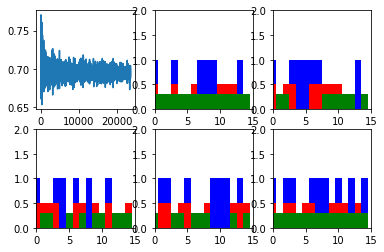

Step 300 Loss 0.69099116


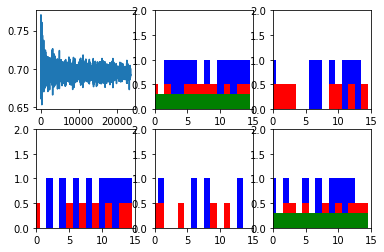

Step 400 Loss 0.6931614


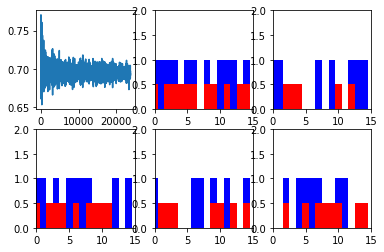

Step 500 Loss 0.69600385


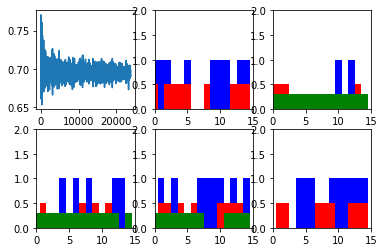

Step 600 Loss 0.6930078


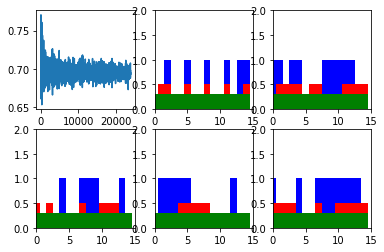

New data, epoch 36
Step 0 Loss 0.6784888


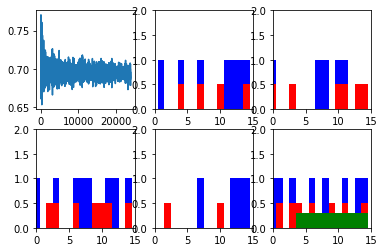

Step 100 Loss 0.7007132


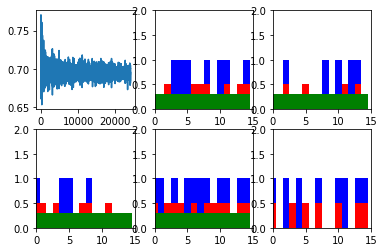

Step 200 Loss 0.69483906


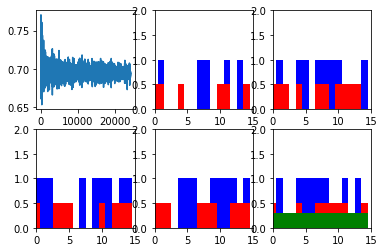

Step 300 Loss 0.7046741


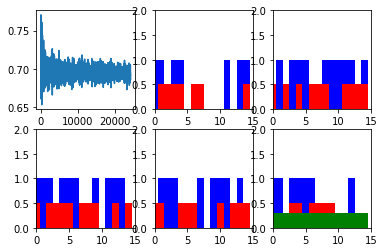

Step 400 Loss 0.6915896


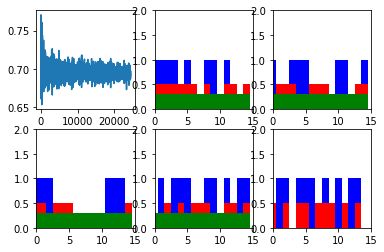

Step 500 Loss 0.69313973


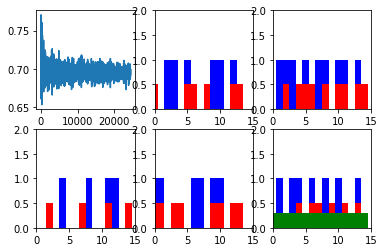

Step 600 Loss 0.6977038


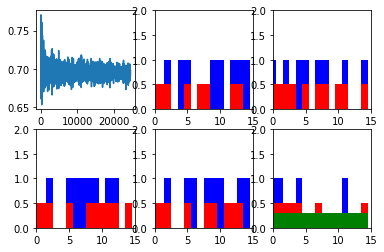

New data, epoch 37
Step 0 Loss 0.6986253


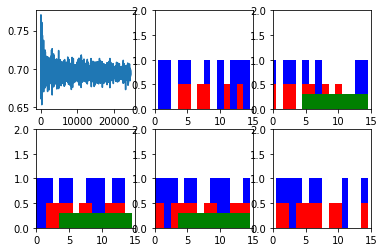

Step 100 Loss 0.6914806


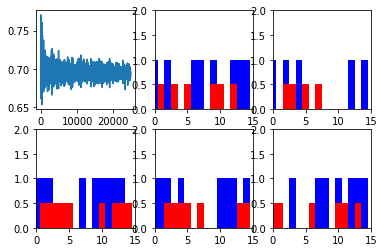

Step 200 Loss 0.6941766


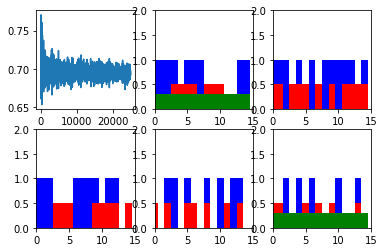

Step 300 Loss 0.6928632


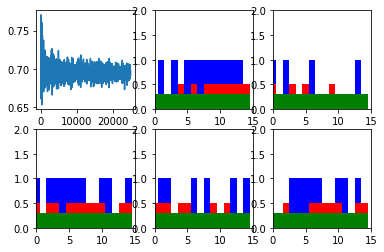

Step 400 Loss 0.69393736


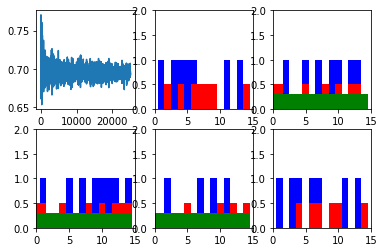

Step 500 Loss 0.69225687


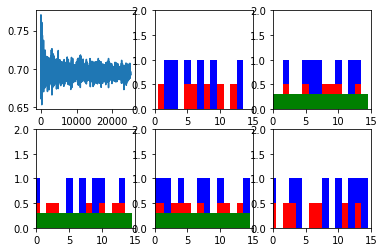

Step 600 Loss 0.69287926


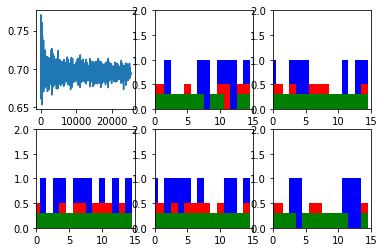

New data, epoch 38
Step 0 Loss 0.6870349


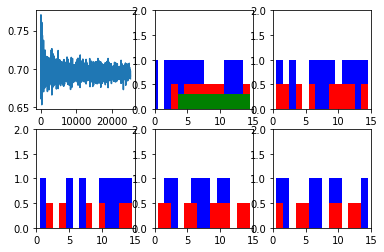

Step 100 Loss 0.6922648


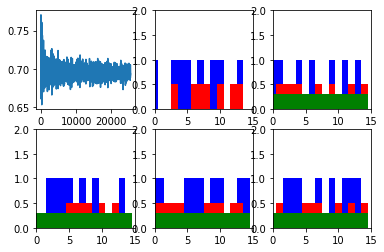

Step 200 Loss 0.6908214


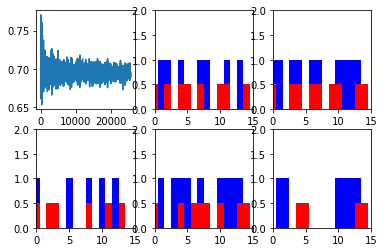

Step 300 Loss 0.69384736


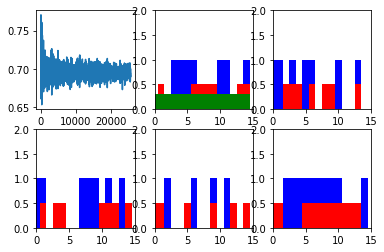

Step 400 Loss 0.6919718


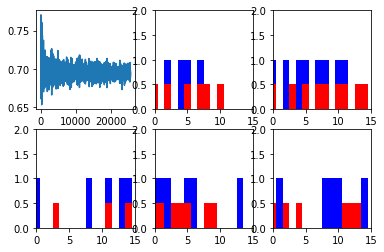

Step 500 Loss 0.6893987


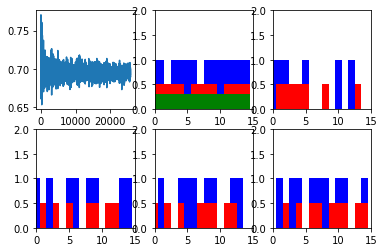

Step 600 Loss 0.69110507


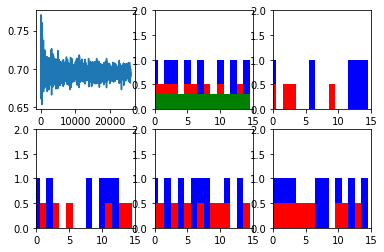

New data, epoch 39
Step 0 Loss 0.68025154


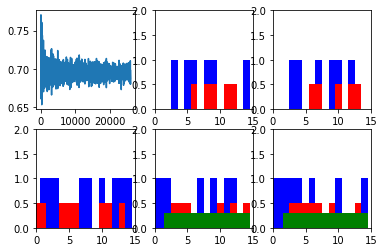

Step 100 Loss 0.69410455


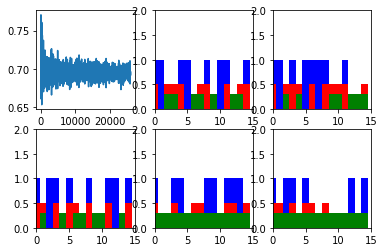

Step 200 Loss 0.69242835


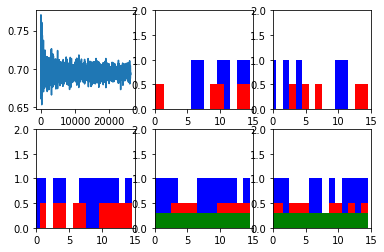

Step 300 Loss 0.68870836


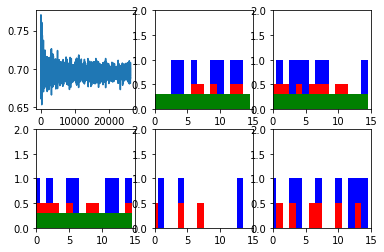

Step 400 Loss 0.6904067


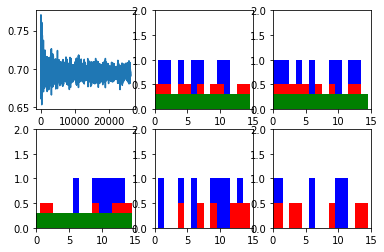

Step 500 Loss 0.69439924


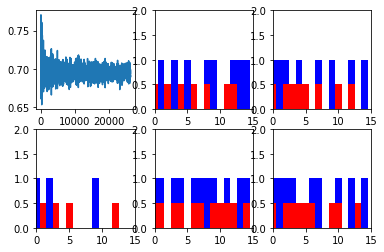

Step 600 Loss 0.6927206


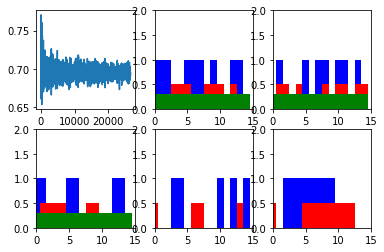

New data, epoch 40
Step 0 Loss 0.6800719


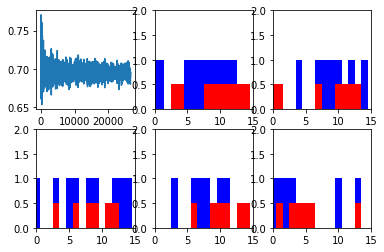

Step 100 Loss 0.6927569


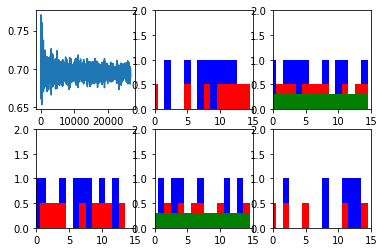

Step 200 Loss 0.6958755


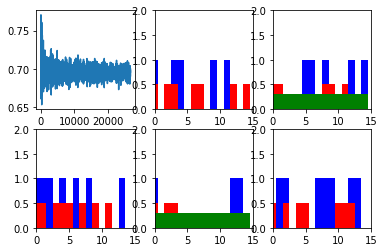

Step 300 Loss 0.6923741


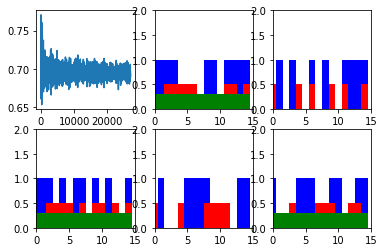

Step 400 Loss 0.6910322


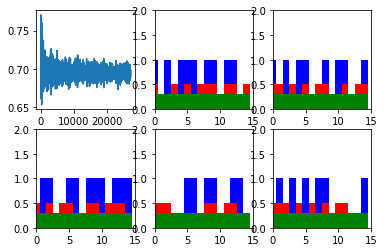

Step 500 Loss 0.6954032


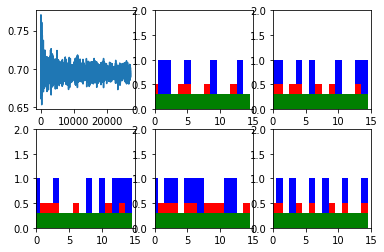

Step 600 Loss 0.69810545


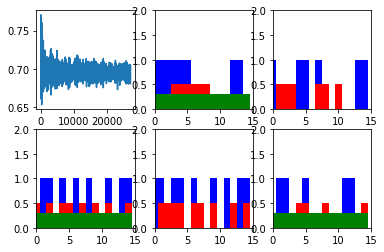

New data, epoch 41
Step 0 Loss 0.6835812


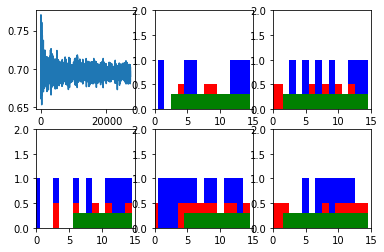

Step 100 Loss 0.6937293


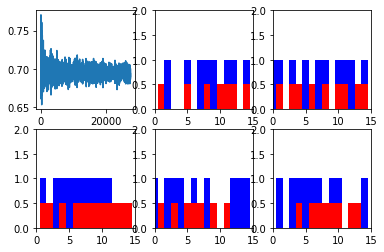

Step 200 Loss 0.6934967


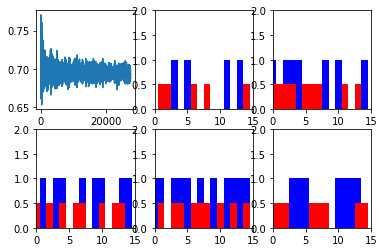

Step 300 Loss 0.6936734


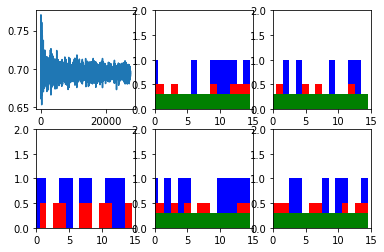

Step 400 Loss 0.68976027


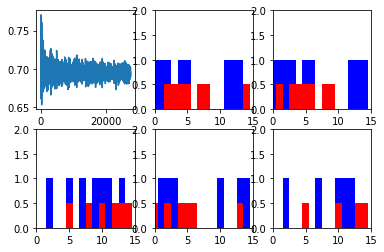

Step 500 Loss 0.6932271


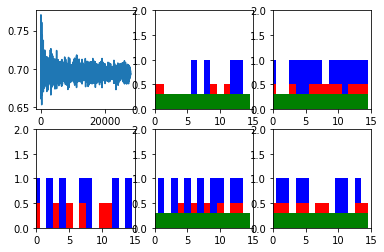

Step 600 Loss 0.69312835


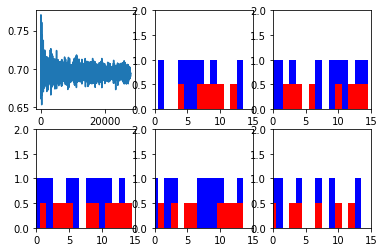

New data, epoch 42
Step 0 Loss 0.69414425


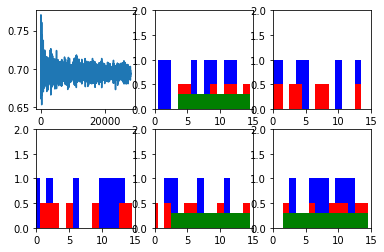

Step 100 Loss 0.6943073


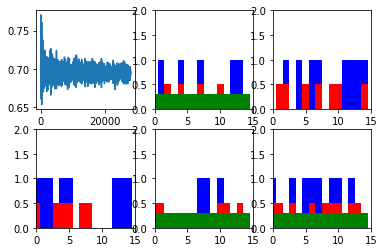

Step 200 Loss 0.69313526


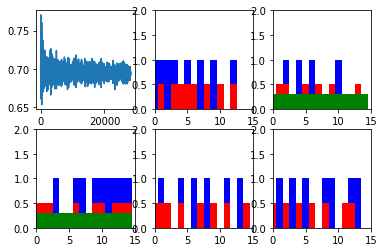

Step 300 Loss 0.69280756


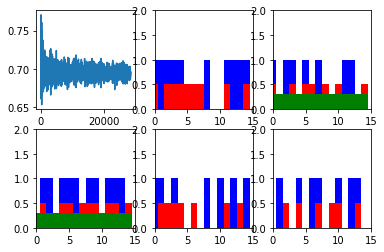

Step 400 Loss 0.6925421


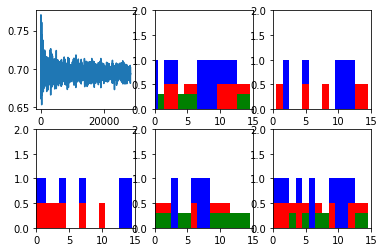

Step 500 Loss 0.6901986


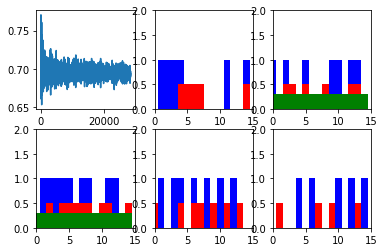

Step 600 Loss 0.69319147


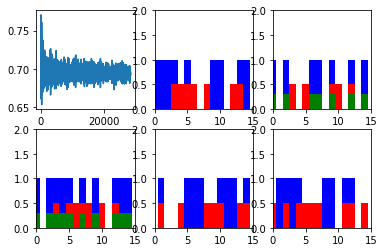

New data, epoch 43
Step 0 Loss 0.6958384


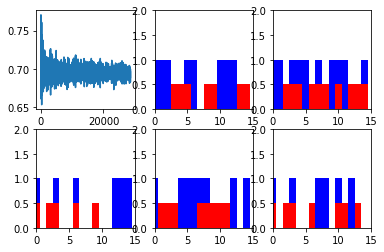

Step 100 Loss 0.6899495


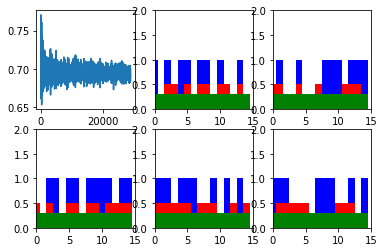

Step 200 Loss 0.6932162


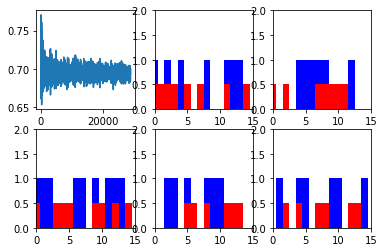

Step 300 Loss 0.69621676


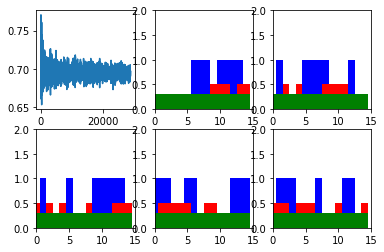

Step 400 Loss 0.69303656


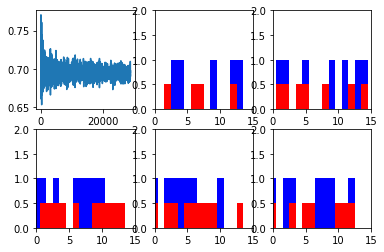

Step 500 Loss 0.6914787


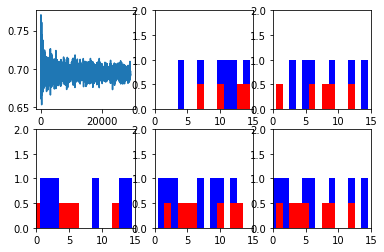

Step 600 Loss 0.6931051


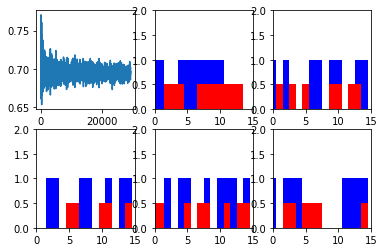

New data, epoch 44
Step 0 Loss 0.6931598


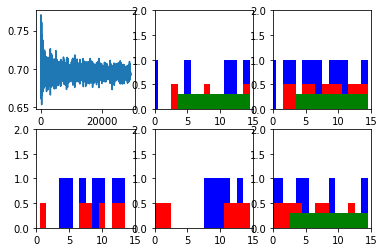

Step 100 Loss 0.6884636


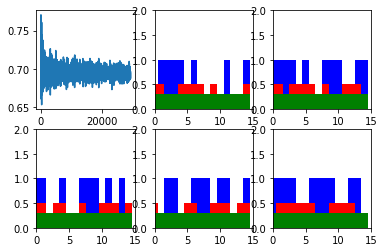

Step 200 Loss 0.6942089


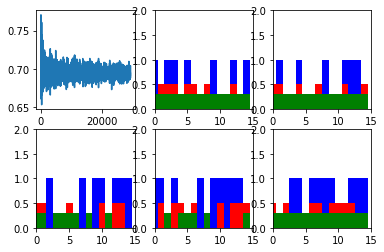

Step 300 Loss 0.6935764


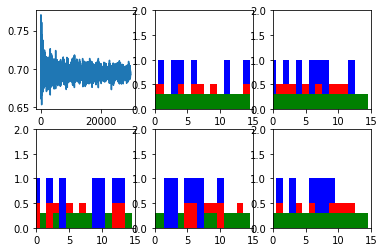

Step 400 Loss 0.69306546


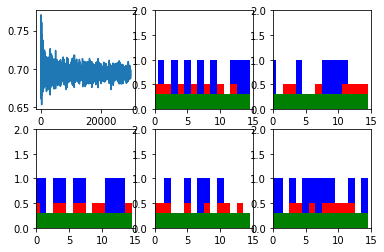

Step 500 Loss 0.6951103


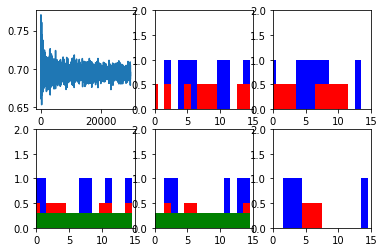

Step 600 Loss 0.6914385


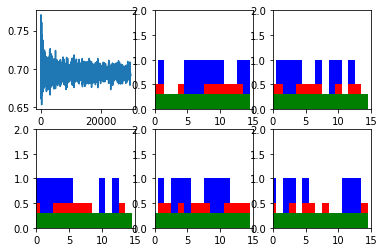

New data, epoch 45
Step 0 Loss 0.70422524


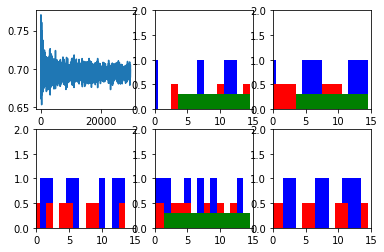

Step 100 Loss 0.69345975


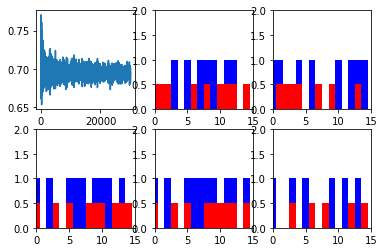

Step 200 Loss 0.691661


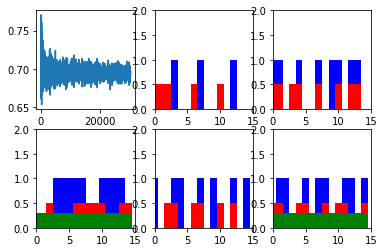

Step 300 Loss 0.69930434


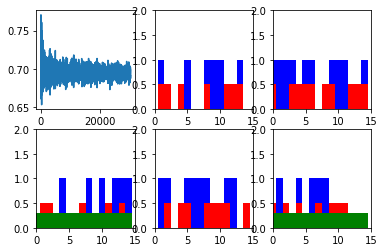

Step 400 Loss 0.6939421


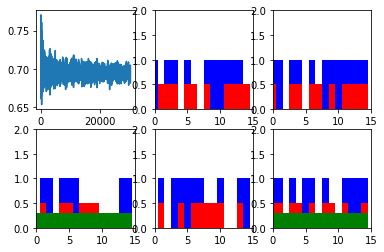

Step 500 Loss 0.6954805


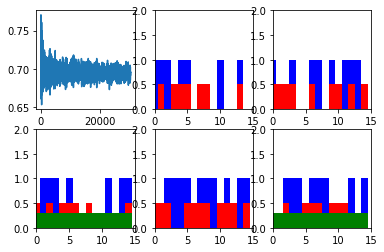

Step 600 Loss 0.69267255


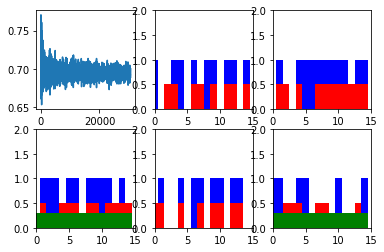

New data, epoch 46
Step 0 Loss 0.6938084


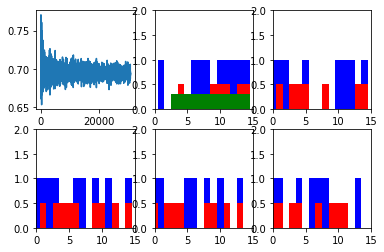

Step 100 Loss 0.6935815


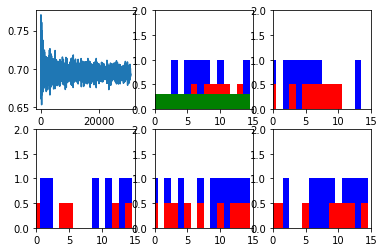

Step 200 Loss 0.6919001


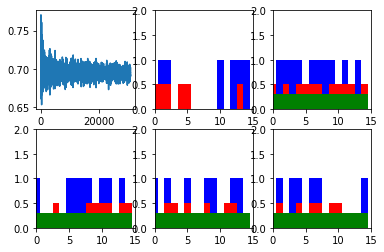

Step 300 Loss 0.695182


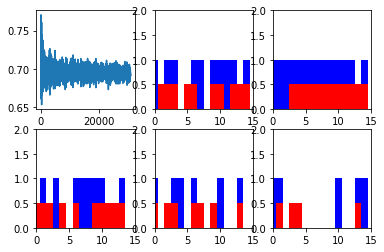

Step 400 Loss 0.6919558


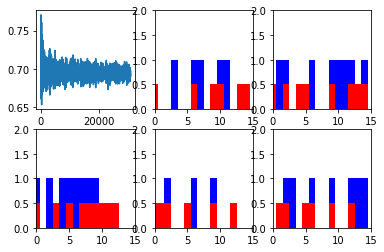

Step 500 Loss 0.69290143


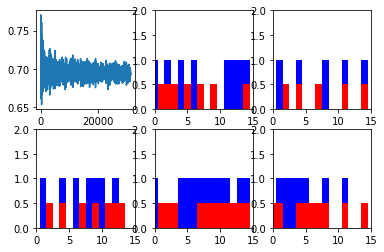

Step 600 Loss 0.6924463


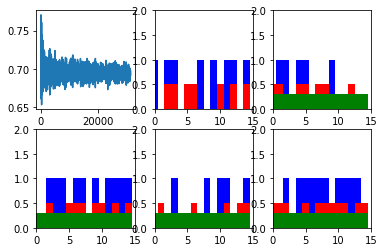

New data, epoch 47
Step 0 Loss 0.69108933


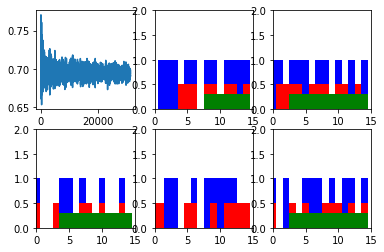

Step 100 Loss 0.692748


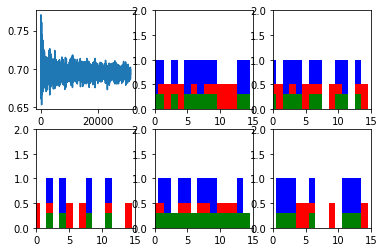

Step 200 Loss 0.69056517


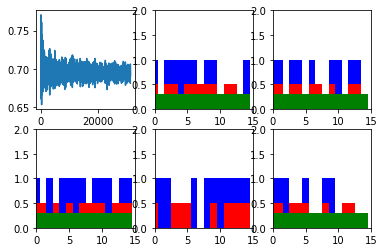

Step 300 Loss 0.6897579


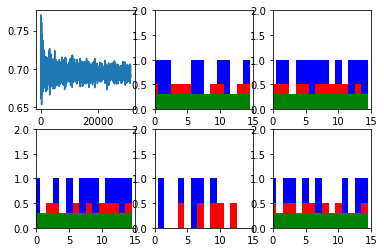

Step 400 Loss 0.69409615


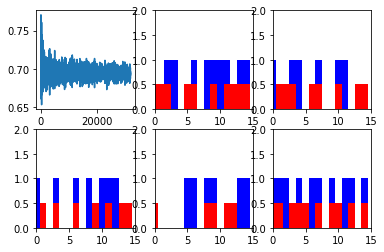

Step 500 Loss 0.6934933


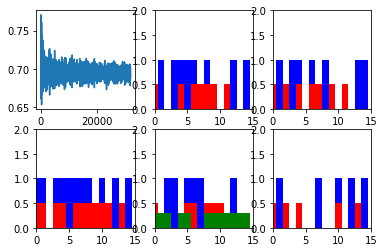

Step 600 Loss 0.69256717


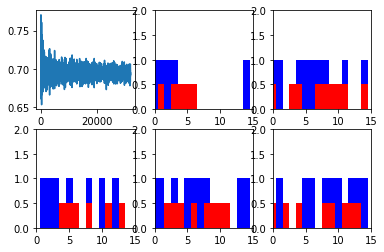

New data, epoch 48
Step 0 Loss 0.6816583


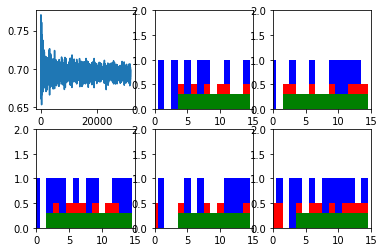

Step 100 Loss 0.696472


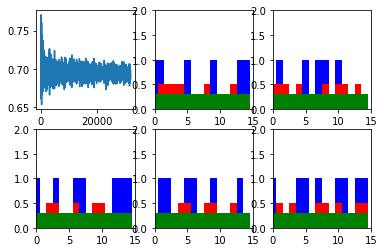

Step 200 Loss 0.69510365


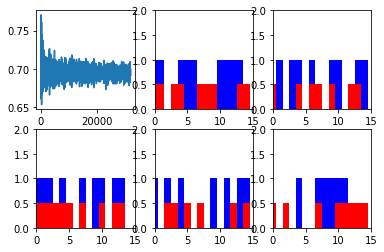

Step 300 Loss 0.6928137


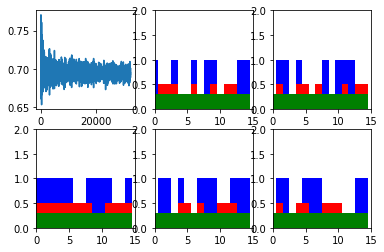

Step 400 Loss 0.6935852


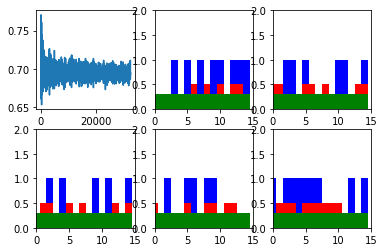

Step 500 Loss 0.6911654


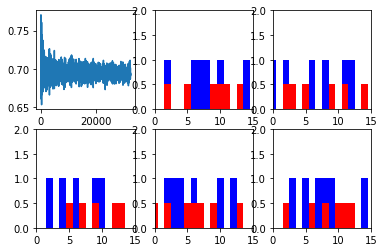

Step 600 Loss 0.69305193


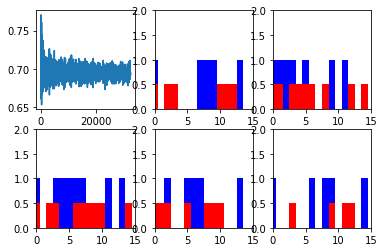

New data, epoch 49
Step 0 Loss 0.6824195


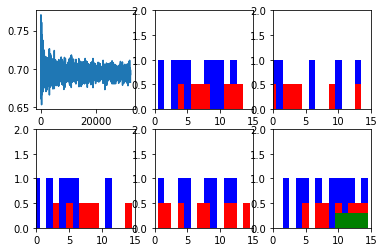

Step 100 Loss 0.69296545


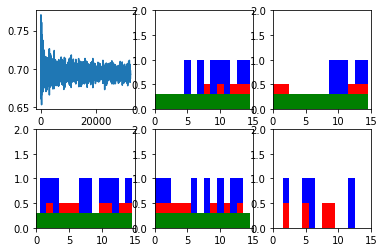

Step 200 Loss 0.6946765


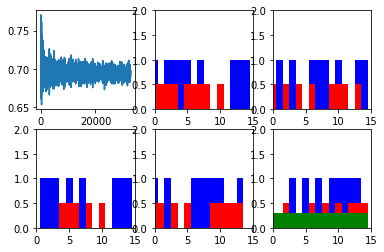

Step 300 Loss 0.6928127


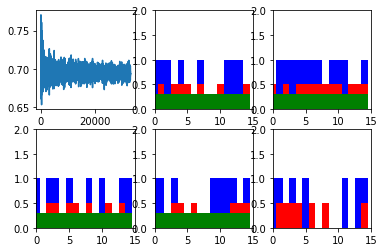

Step 400 Loss 0.69312036


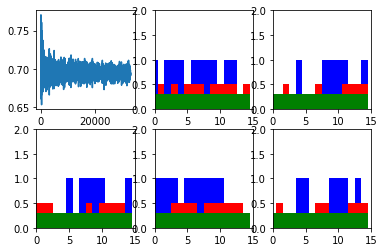

Step 500 Loss 0.6923532


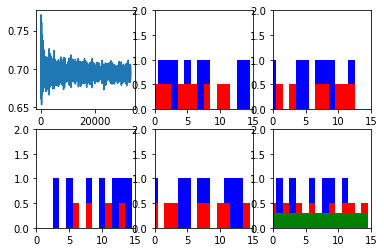

Step 600 Loss 0.69562966


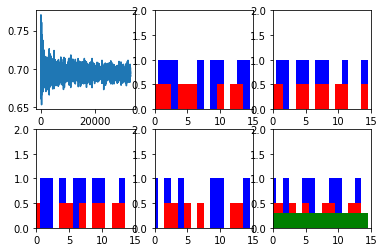

New data, epoch 50
Step 0 Loss 0.68457234


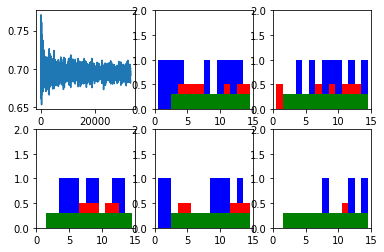

Step 100 Loss 0.6903351


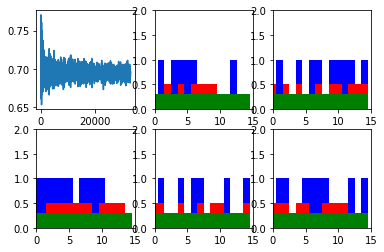

Step 200 Loss 0.69470114


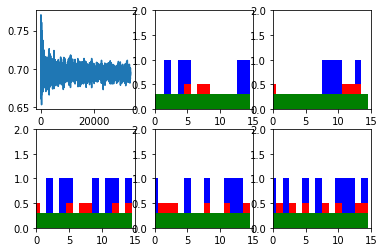

Step 300 Loss 0.69268936


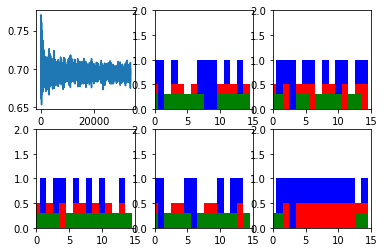

Step 400 Loss 0.6957715


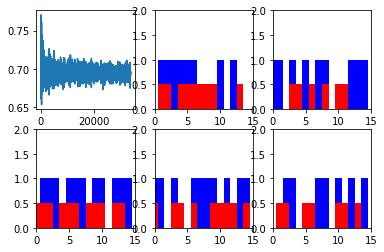

Step 500 Loss 0.6934517


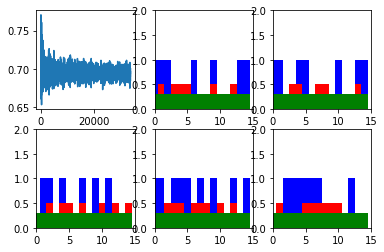

Step 600 Loss 0.6947189


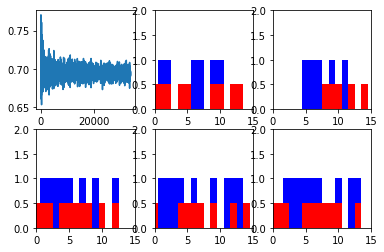

New data, epoch 51
Step 0 Loss 0.6970122


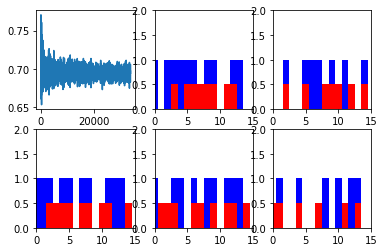

Step 100 Loss 0.69213384


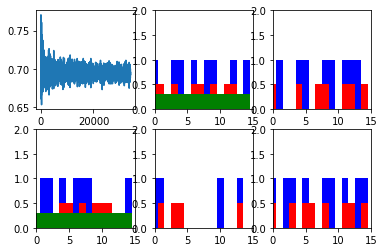

Step 200 Loss 0.69406915


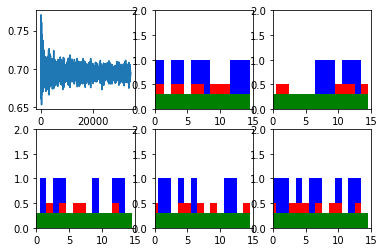

Step 300 Loss 0.69145274


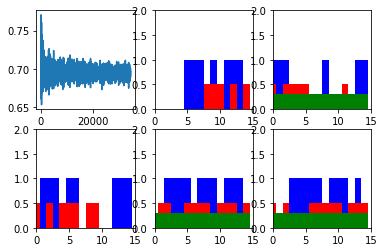

Step 400 Loss 0.6886139


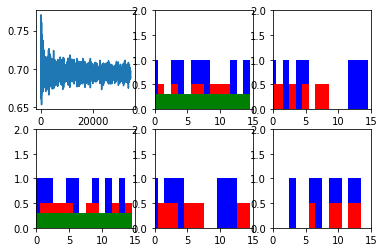

Step 500 Loss 0.6888152


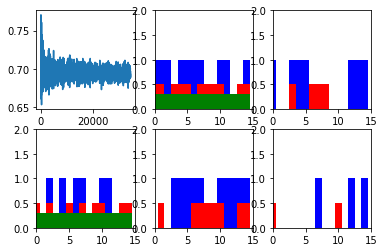

Step 600 Loss 0.69151604


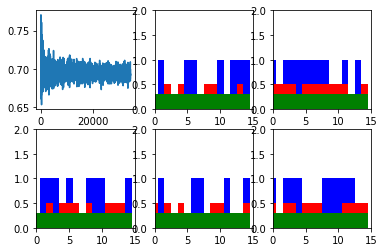

New data, epoch 52
Step 0 Loss 0.68743193


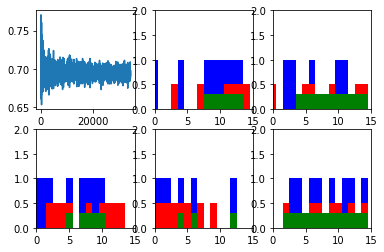

Step 100 Loss 0.69336855


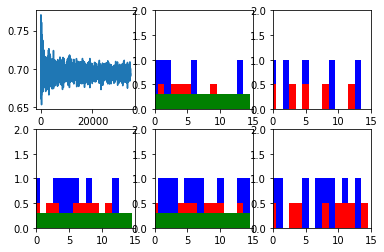

Step 200 Loss 0.69282424


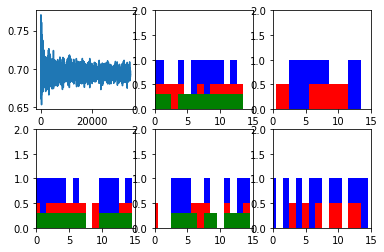

Step 300 Loss 0.7001812


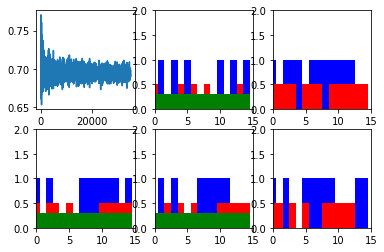

Step 400 Loss 0.6921875


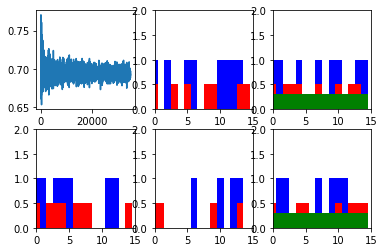

Step 500 Loss 0.6944956


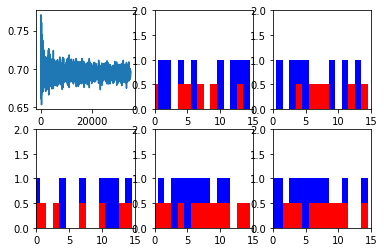

Step 600 Loss 0.69347227


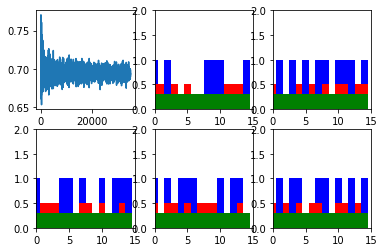

New data, epoch 53
Step 0 Loss 0.68119043


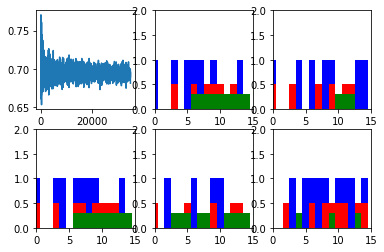

Step 100 Loss 0.69296074


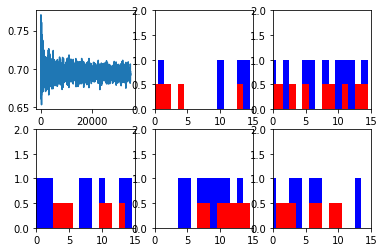

Step 200 Loss 0.6914813


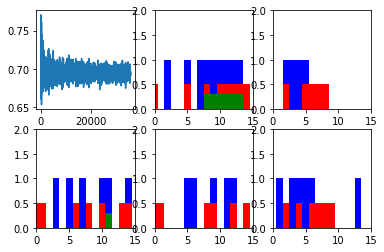

Step 300 Loss 0.6937575


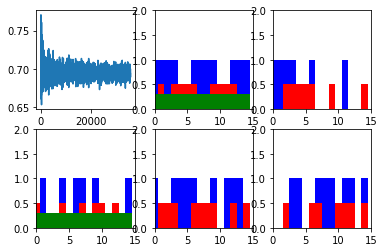

Step 400 Loss 0.69415647


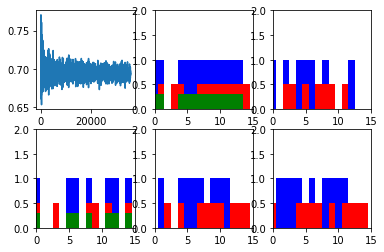

Step 500 Loss 0.6900172


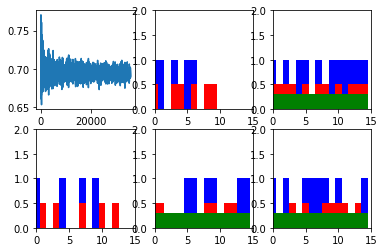

Step 600 Loss 0.6929466


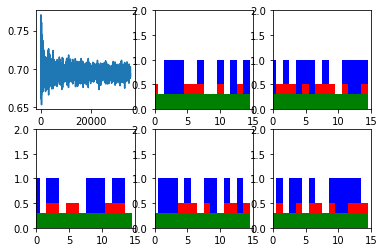

New data, epoch 54
Step 0 Loss 0.6879079


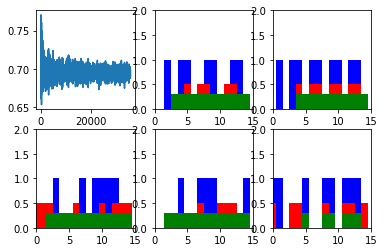

Step 100 Loss 0.6865144


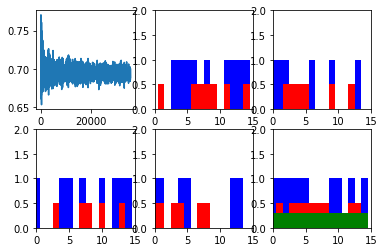

Step 200 Loss 0.69875425


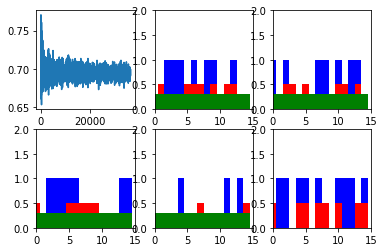

Step 300 Loss 0.6928211


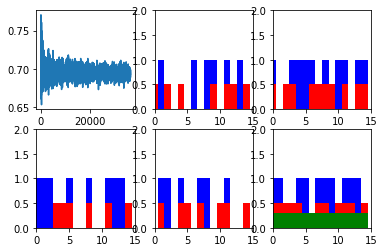

Step 400 Loss 0.6824394


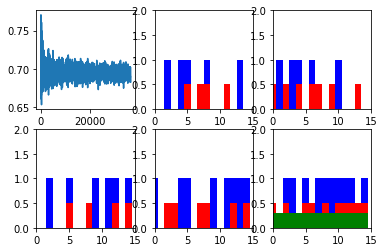

Step 500 Loss 0.69298446


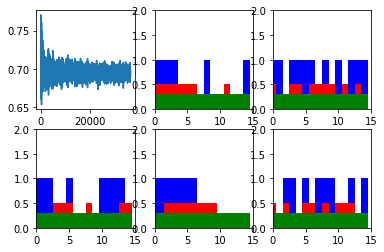

Step 600 Loss 0.69389075


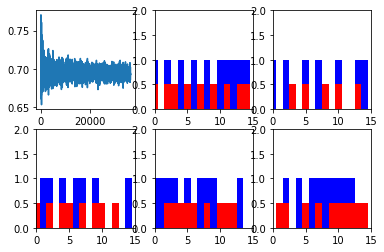

New data, epoch 55
Step 0 Loss 0.70610476


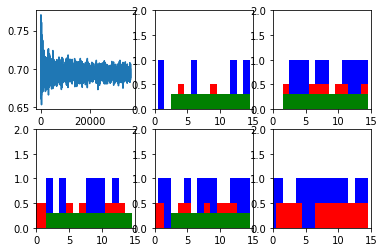

Step 100 Loss 0.6941488


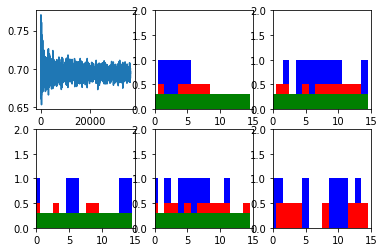

Step 200 Loss 0.6928563


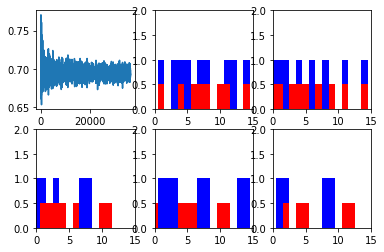

Step 300 Loss 0.69170094


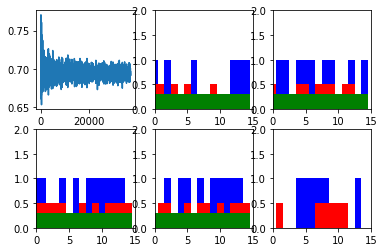

Step 400 Loss 0.692218


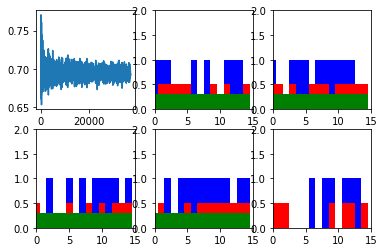

Step 500 Loss 0.6929182


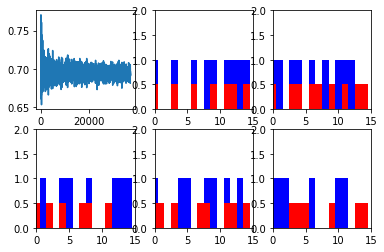

Step 600 Loss 0.6911217


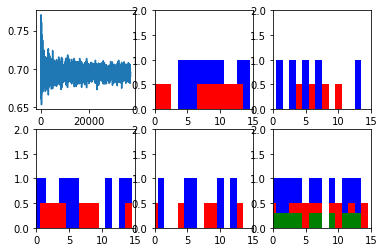

New data, epoch 56
Step 0 Loss 0.68481356


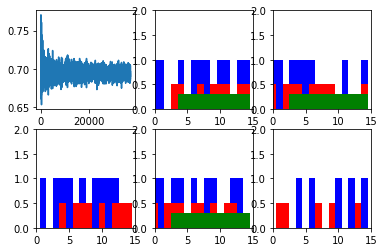

Step 100 Loss 0.6931063


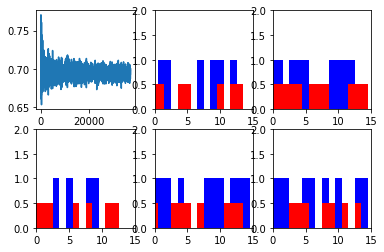

Step 200 Loss 0.69581085


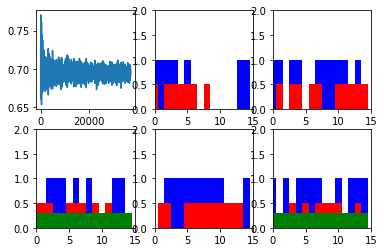

Step 300 Loss 0.6929061


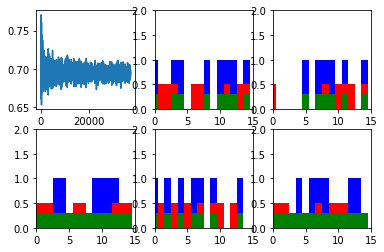

Step 400 Loss 0.6929007


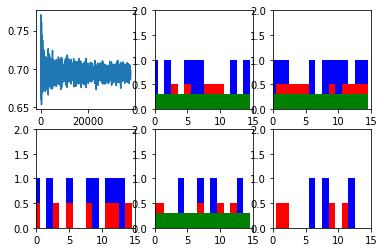

Step 500 Loss 0.69149554


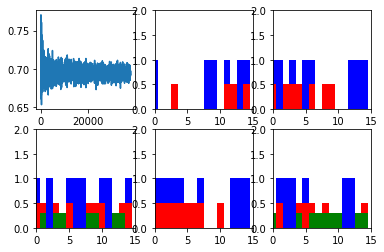

Step 600 Loss 0.69310707


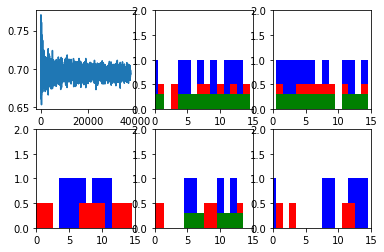

New data, epoch 57
Step 0 Loss 0.6895086


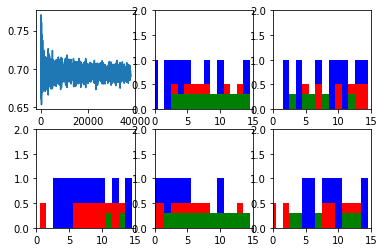

Step 100 Loss 0.6945811


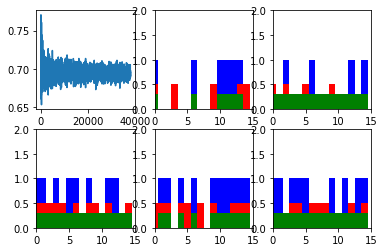

Step 200 Loss 0.68620574


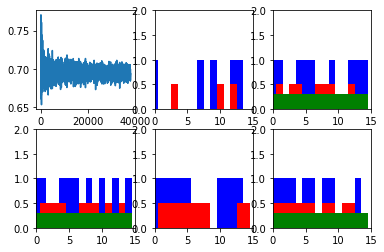

Step 300 Loss 0.69079965


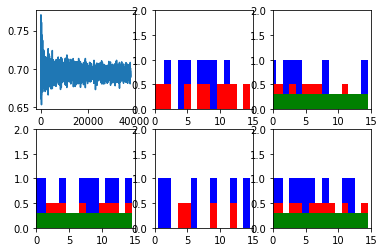

Step 400 Loss 0.69449073


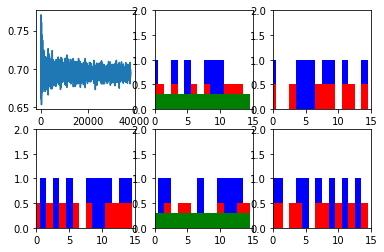

Step 500 Loss 0.69269705


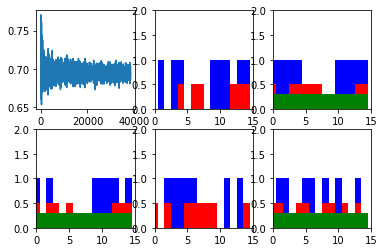

Step 600 Loss 0.6977873


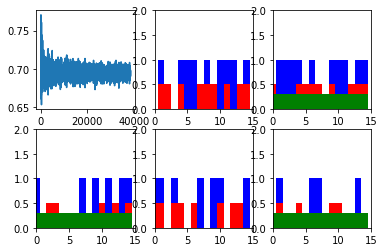

New data, epoch 58
Step 0 Loss 0.6899903


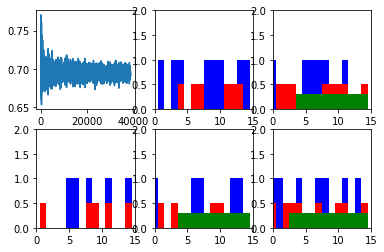

Step 100 Loss 0.6926424


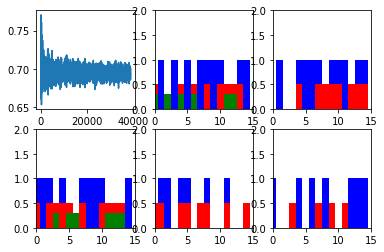

Step 200 Loss 0.6962985


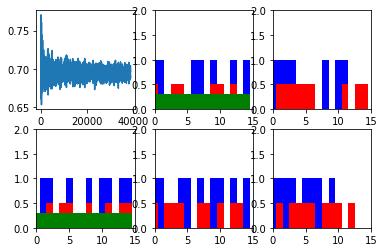

Step 300 Loss 0.6948022


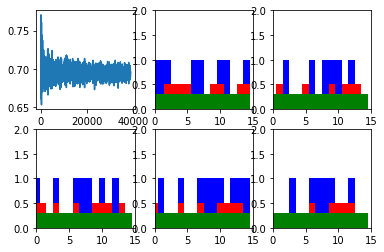

Step 400 Loss 0.69368297


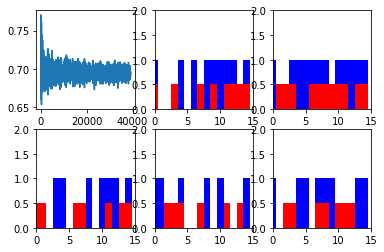

Step 500 Loss 0.69355667


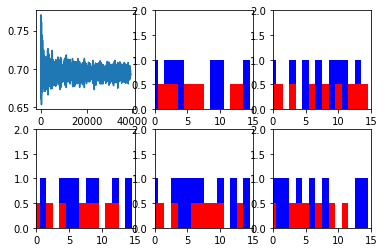

Step 600 Loss 0.69807136


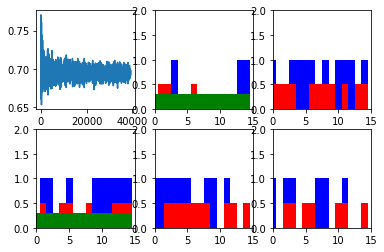

New data, epoch 59
Step 0 Loss 0.69395506


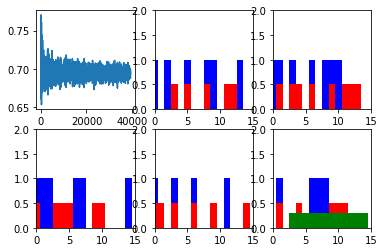

Step 100 Loss 0.69083244


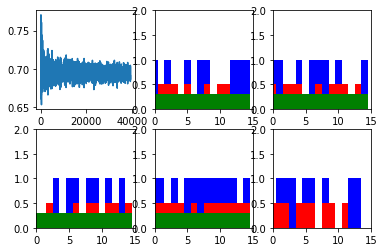

Step 200 Loss 0.69228774


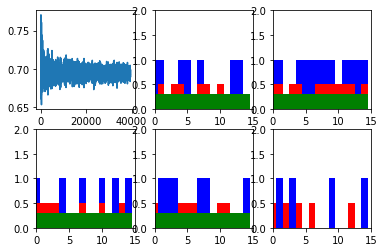

Step 300 Loss 0.6902737


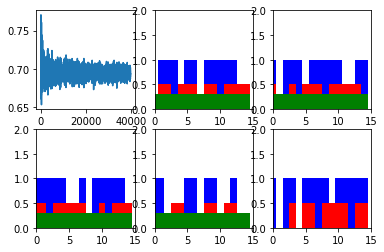

Step 400 Loss 0.6919173


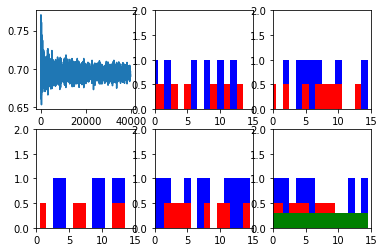

Step 500 Loss 0.693973


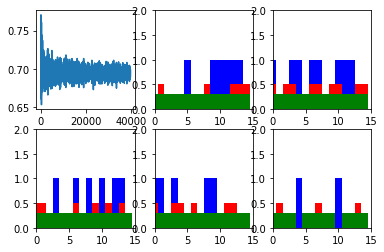

Step 600 Loss 0.69244325


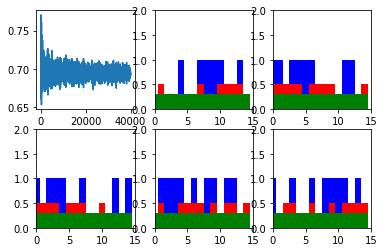

New data, epoch 60
Step 0 Loss 0.6912244


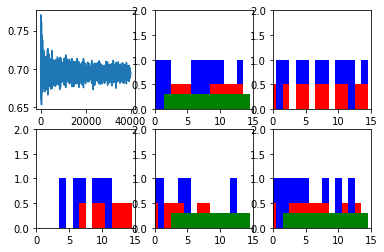

Step 100 Loss 0.68682903


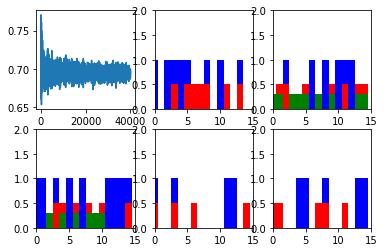

Step 200 Loss 0.6942926


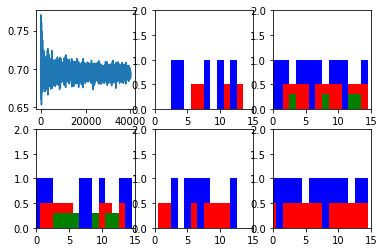

Step 300 Loss 0.69367117


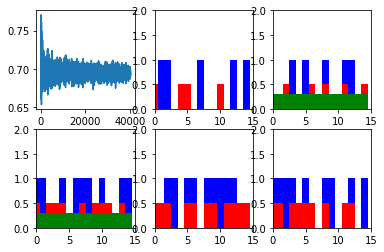

Step 400 Loss 0.69391745


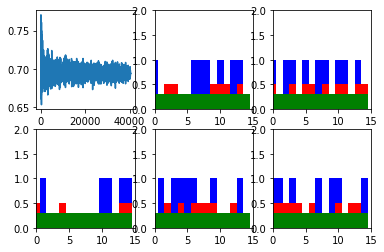

Step 500 Loss 0.7004276


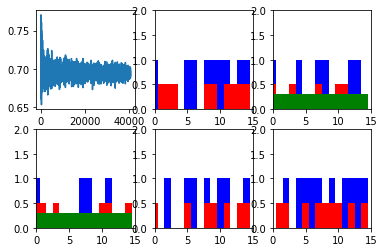

Step 600 Loss 0.69808006


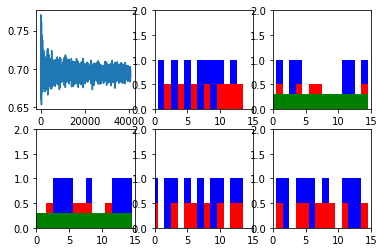

New data, epoch 61
Step 0 Loss 0.69671094


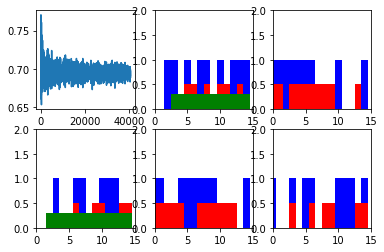

Step 100 Loss 0.6913683


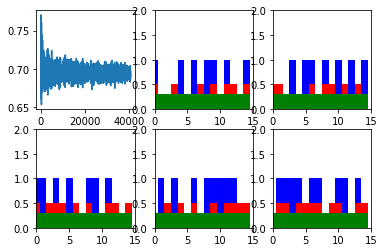

Step 200 Loss 0.6912046


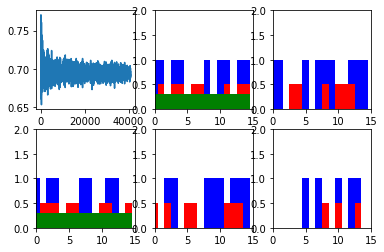

Step 300 Loss 0.6914731


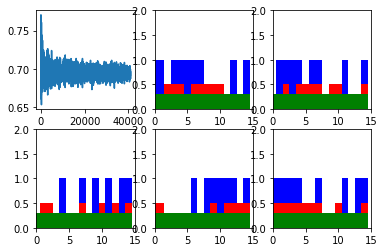

Step 400 Loss 0.69313234


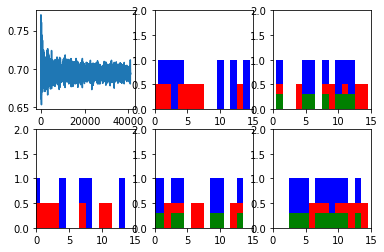

Step 500 Loss 0.69346917


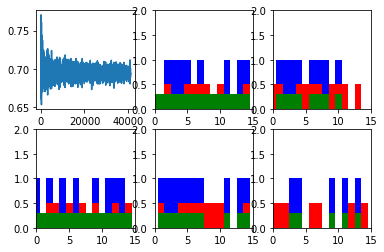

Step 600 Loss 0.69355506


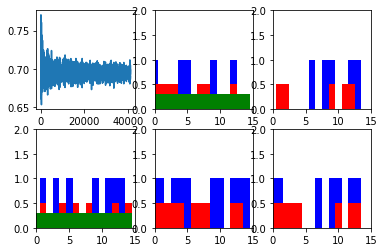

New data, epoch 62
Step 0 Loss 0.7062497


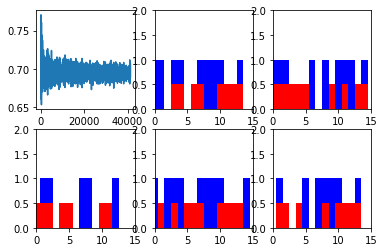

Step 100 Loss 0.6934293


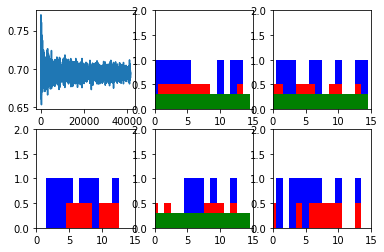

Step 200 Loss 0.6922484


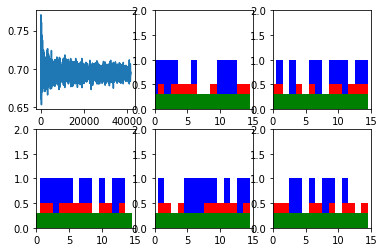

Step 300 Loss 0.69357765


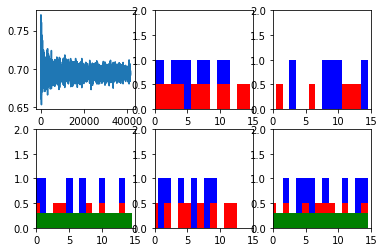

Step 400 Loss 0.69460726


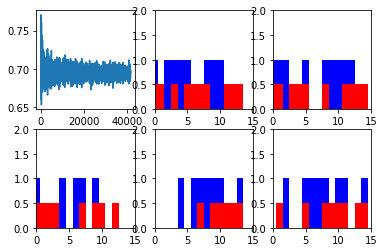

Step 500 Loss 0.69825804


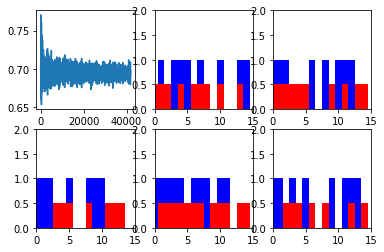

Step 600 Loss 0.6875673


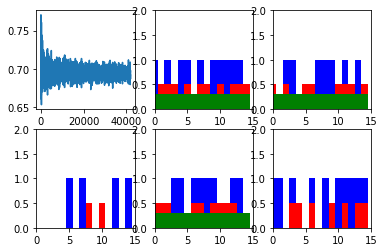

New data, epoch 63
Step 0 Loss 0.6959521


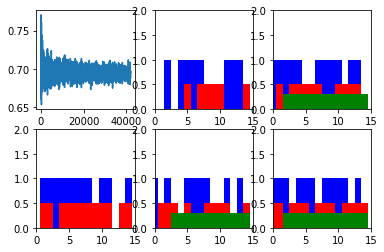

Step 100 Loss 0.6977995


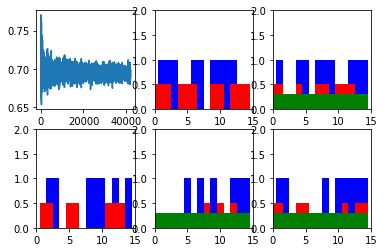

Step 200 Loss 0.69247395


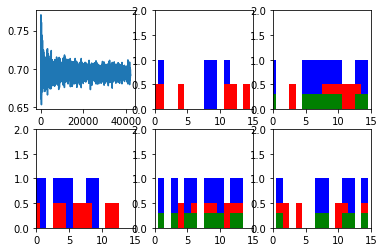

Step 300 Loss 0.6927533


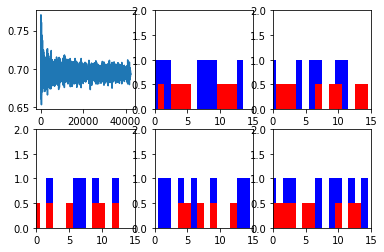

Step 400 Loss 0.6951687


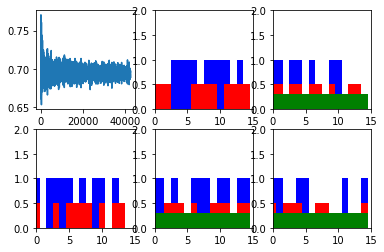

Step 500 Loss 0.6884042


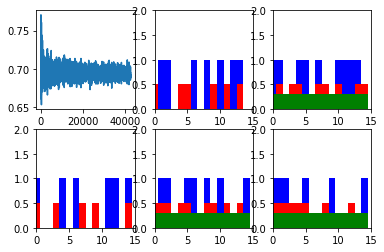

Step 600 Loss 0.6922966


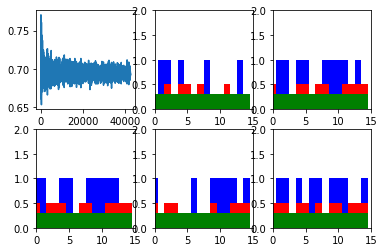

New data, epoch 64
Step 0 Loss 0.6926213


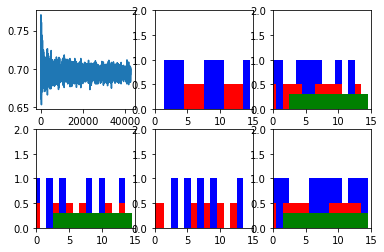

Step 100 Loss 0.68952346


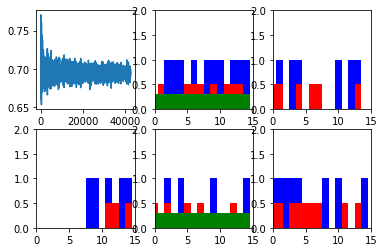

Step 200 Loss 0.6931923


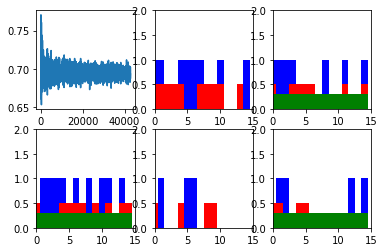

Step 300 Loss 0.6865854


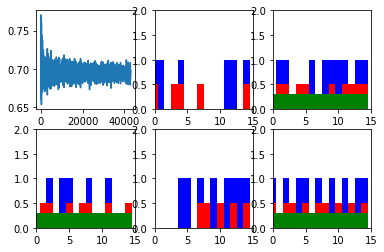

Step 400 Loss 0.69258434


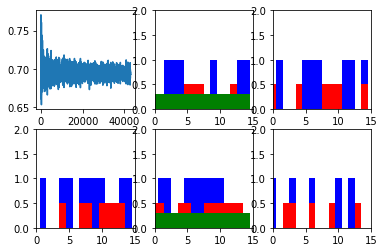

Step 500 Loss 0.6920284


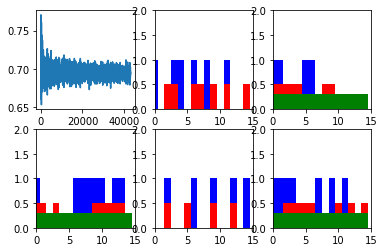

Step 600 Loss 0.6931932


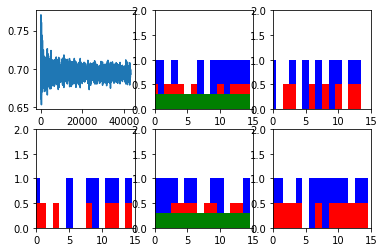

New data, epoch 65
Step 0 Loss 0.68875873


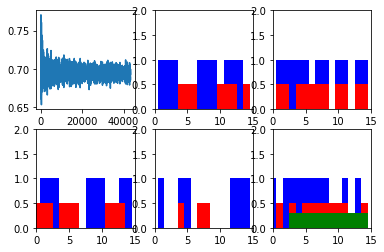

Step 100 Loss 0.69062996


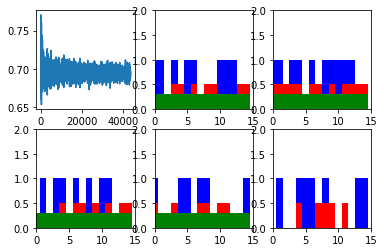

Step 200 Loss 0.6933427


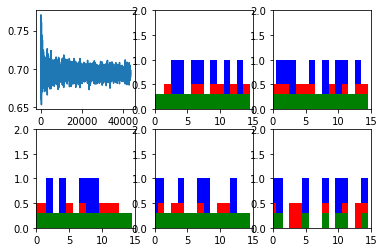

Step 300 Loss 0.69570494


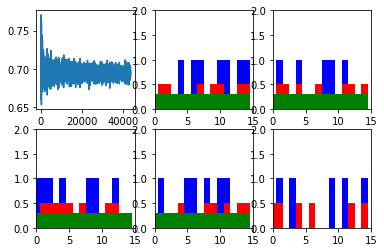

Step 400 Loss 0.69284457


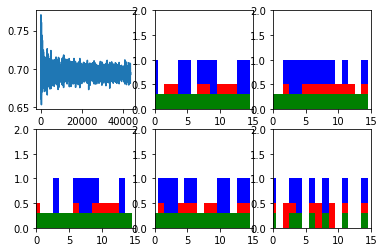

Step 500 Loss 0.6928963


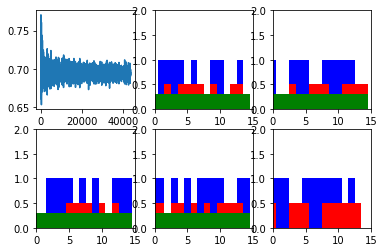

Step 600 Loss 0.6927923


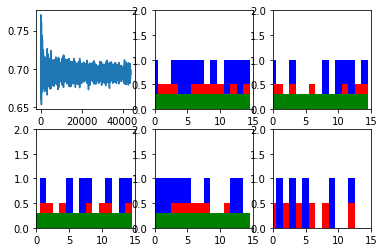

New data, epoch 66
Step 0 Loss 0.6870308


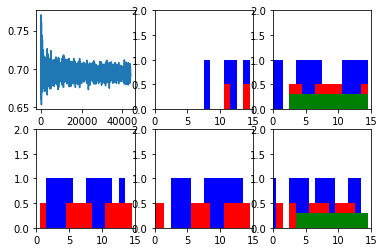

Step 100 Loss 0.69239175


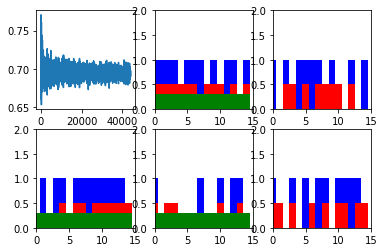

Step 200 Loss 0.6889591


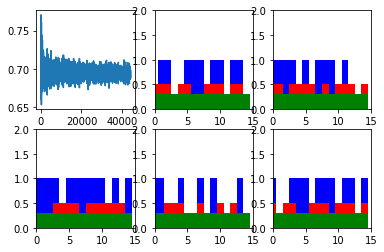

Step 300 Loss 0.69437784


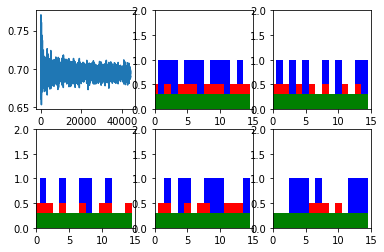

Step 400 Loss 0.6934396


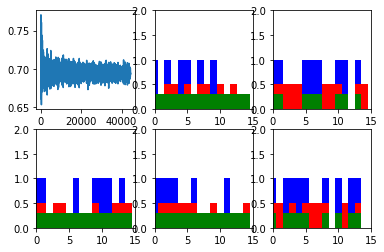

Step 500 Loss 0.69619954


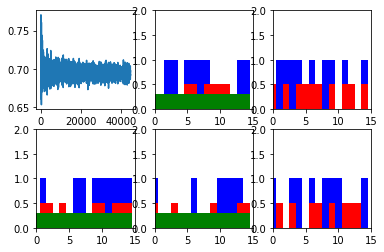

Step 600 Loss 0.69001293


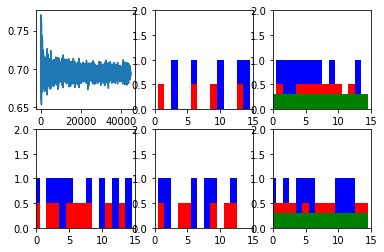

New data, epoch 67
Step 0 Loss 0.69426084


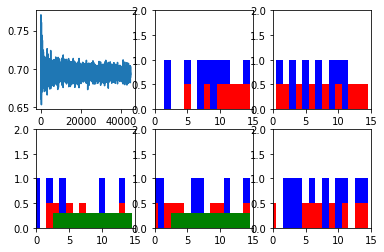

Step 100 Loss 0.6933387


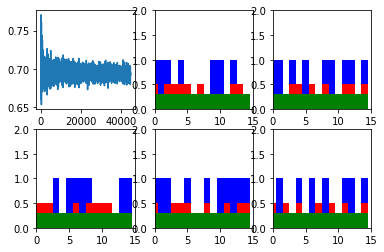

Step 200 Loss 0.69536775


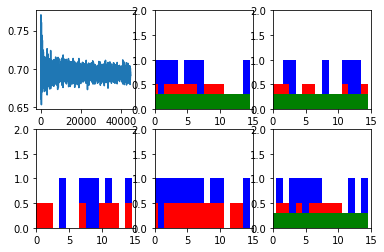

Step 300 Loss 0.69626445


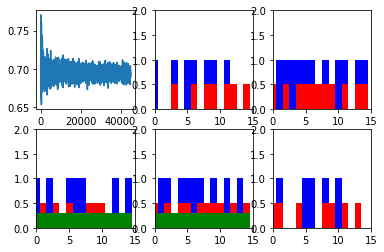

Step 400 Loss 0.6939217


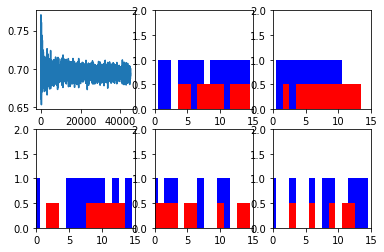

Step 500 Loss 0.6921104


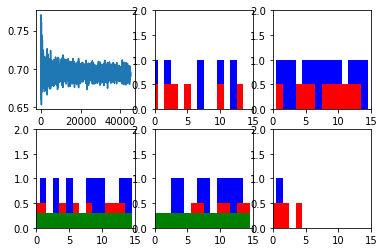

Step 600 Loss 0.6941496


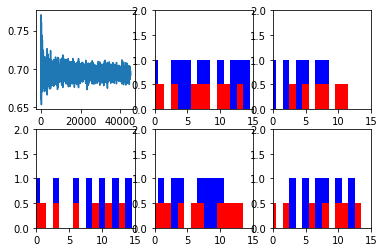

New data, epoch 68
Step 0 Loss 0.6885542


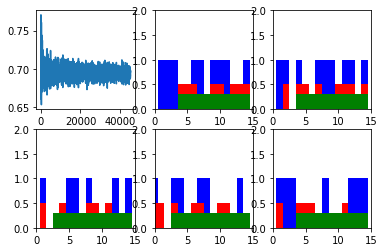

Step 100 Loss 0.69210315


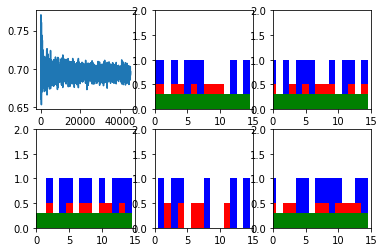

Step 200 Loss 0.69422376


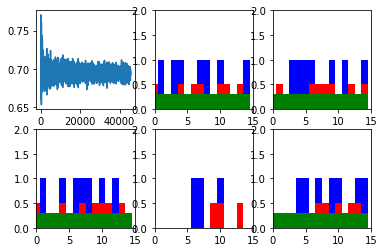

Step 300 Loss 0.69272846


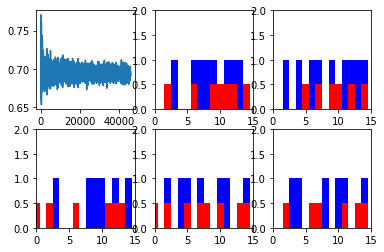

Step 400 Loss 0.691229


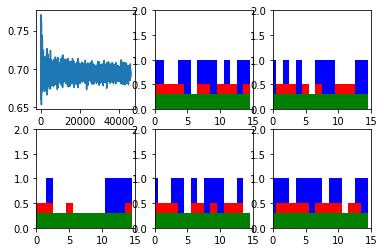

Step 500 Loss 0.6908081


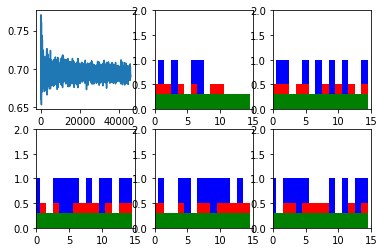

Step 600 Loss 0.6948251


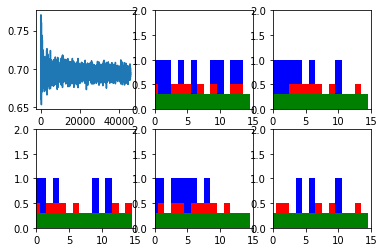

New data, epoch 69
Step 0 Loss 0.68976724


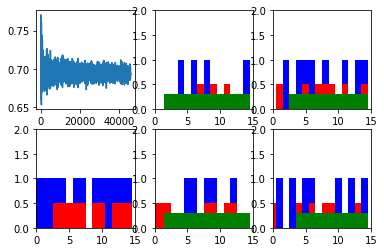

Step 100 Loss 0.6945693


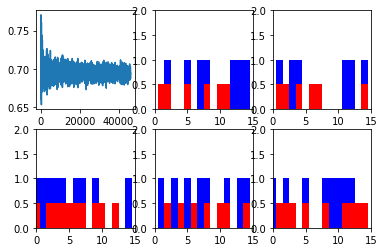

Step 200 Loss 0.69250846


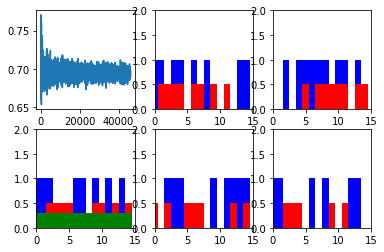

Step 300 Loss 0.692886


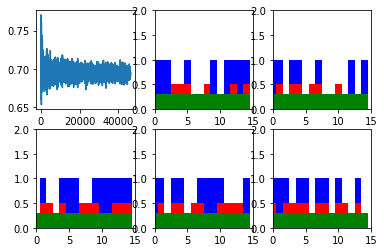

Step 400 Loss 0.69359004


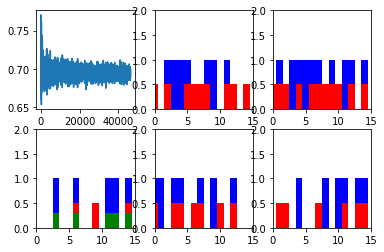

Step 500 Loss 0.69195575


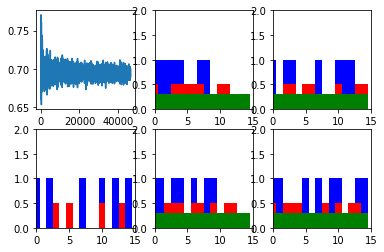

Step 600 Loss 0.70146894


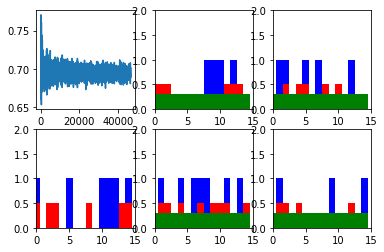

New data, epoch 70
Step 0 Loss 0.6897753


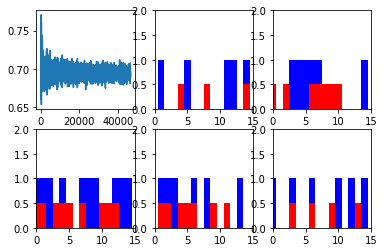

Step 100 Loss 0.6929252


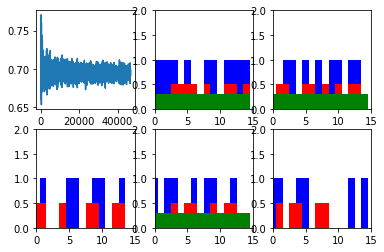

Step 200 Loss 0.6935995


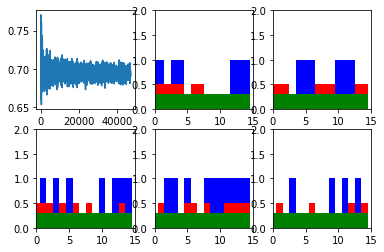

Step 300 Loss 0.6936155


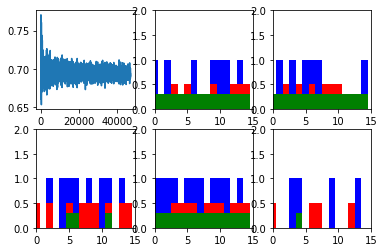

Step 400 Loss 0.69291556


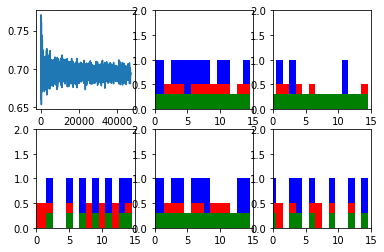

Step 500 Loss 0.6979852


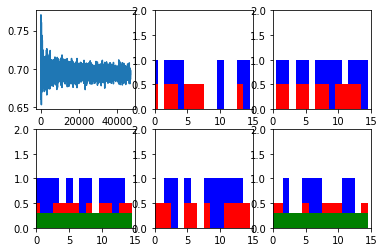

Step 600 Loss 0.6919991


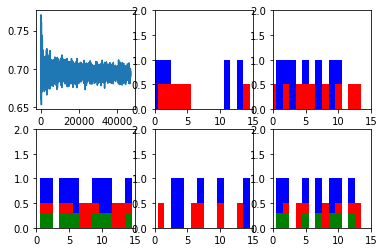

New data, epoch 71
Step 0 Loss 0.69504875


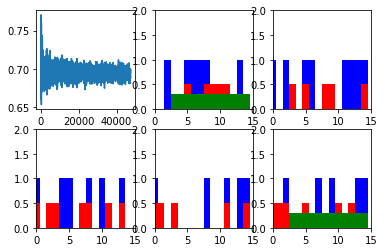

Step 100 Loss 0.6948916


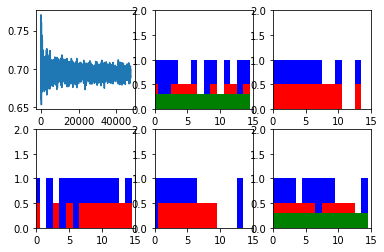

Step 200 Loss 0.6973886


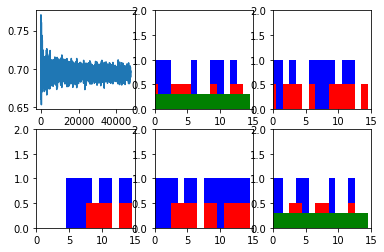

Step 300 Loss 0.69482964


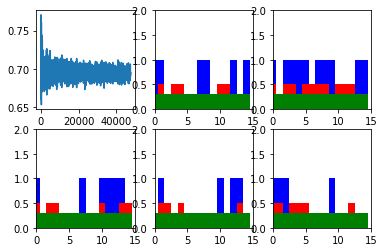

Step 400 Loss 0.6887713


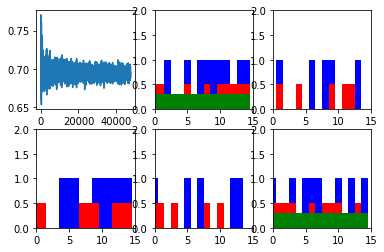

Step 500 Loss 0.6930625


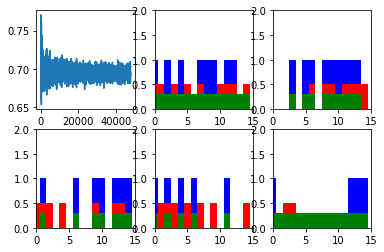

Step 600 Loss 0.69785076


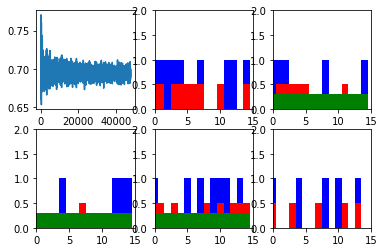

New data, epoch 72
Step 0 Loss 0.69661427


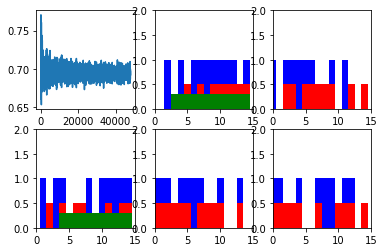

Step 100 Loss 0.6967811


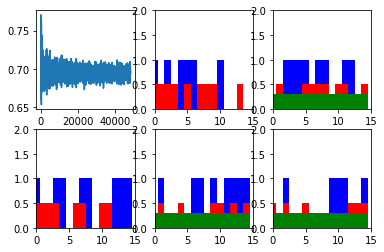

Step 200 Loss 0.68976194


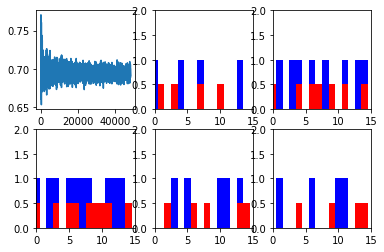

Step 300 Loss 0.69209


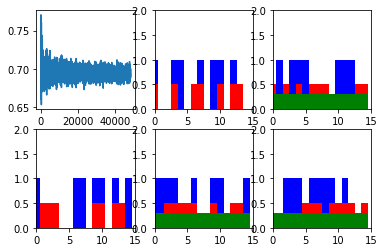

Step 400 Loss 0.6929503


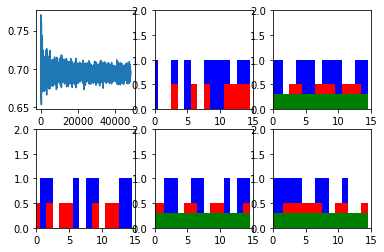

Step 500 Loss 0.6927462


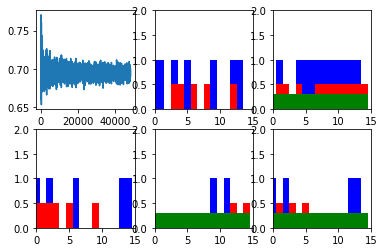

Step 600 Loss 0.6926706


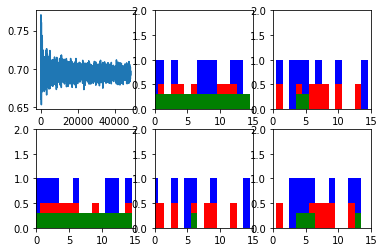

New data, epoch 73
Step 0 Loss 0.6919127


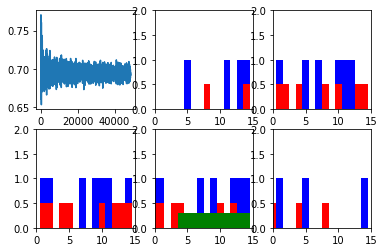

Step 100 Loss 0.69362944


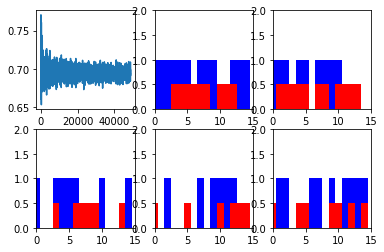

Step 200 Loss 0.69190615


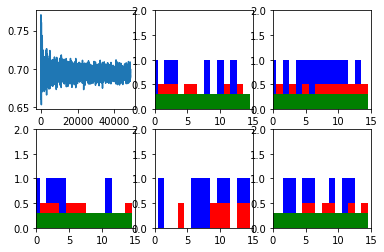

Step 300 Loss 0.69588244


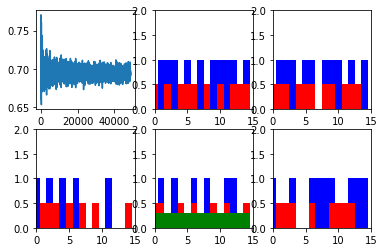

Step 400 Loss 0.6888703


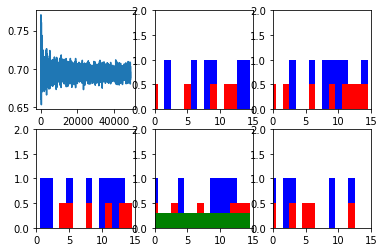

Step 500 Loss 0.6927433


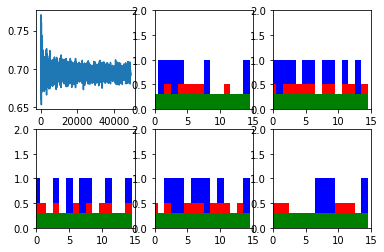

Step 600 Loss 0.68547356


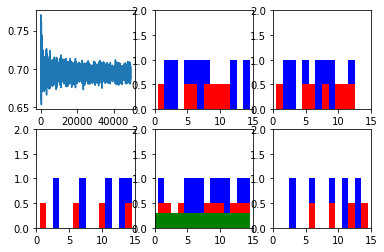

New data, epoch 74
Step 0 Loss 0.69637793


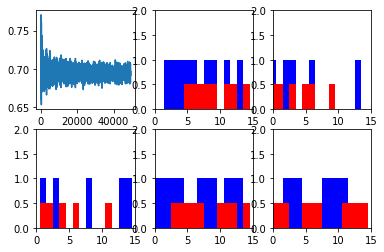

Step 100 Loss 0.6991579


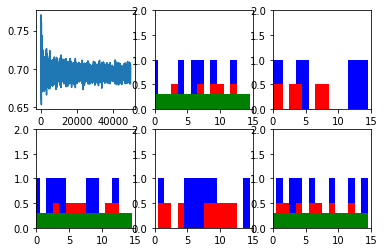

Step 200 Loss 0.694041


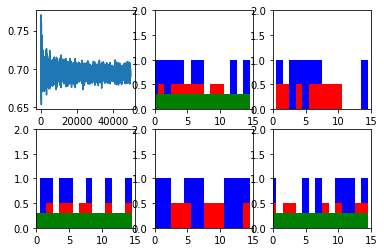

Step 300 Loss 0.69429797


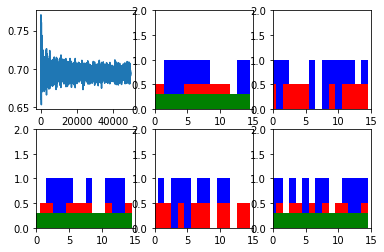

Step 400 Loss 0.6941156


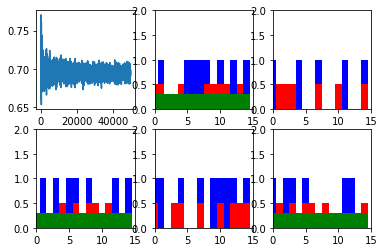

Step 500 Loss 0.69078183


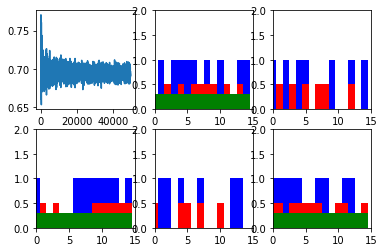

Step 600 Loss 0.6957911


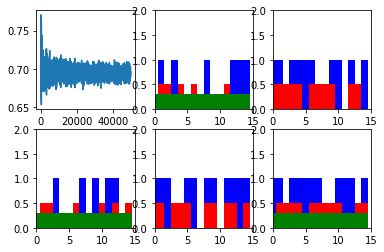

New data, epoch 75
Step 0 Loss 0.68678683


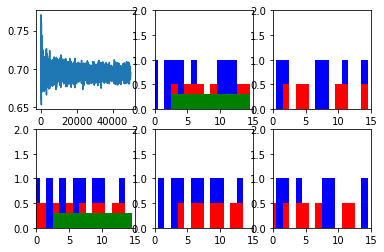

Step 100 Loss 0.69265175


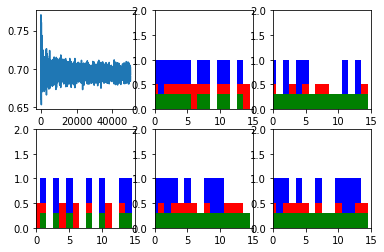

Step 200 Loss 0.69417787


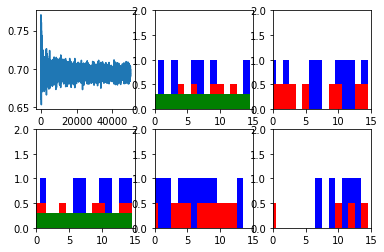

Step 300 Loss 0.6936832


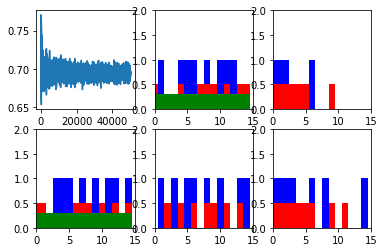

Step 400 Loss 0.69243574


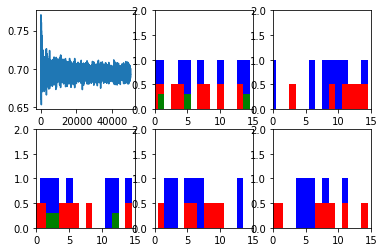

Step 500 Loss 0.6937014


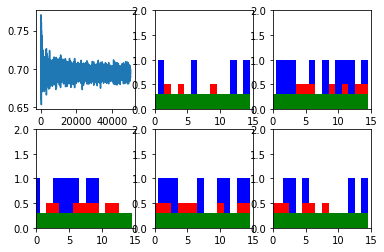

Step 600 Loss 0.6930441


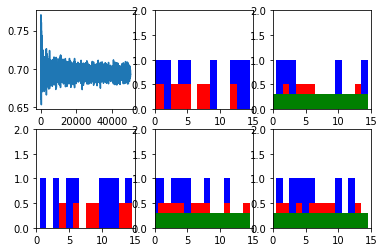

New data, epoch 76
Step 0 Loss 0.68928736


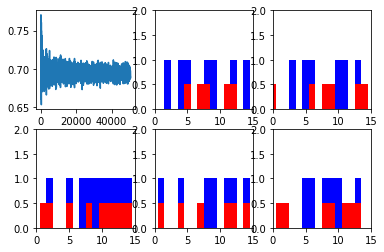

Step 100 Loss 0.69432366


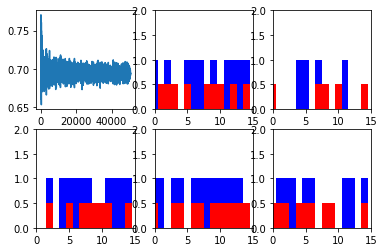

Step 200 Loss 0.69228745


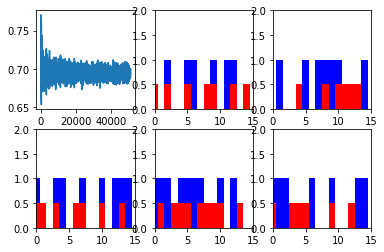

Step 300 Loss 0.69158584


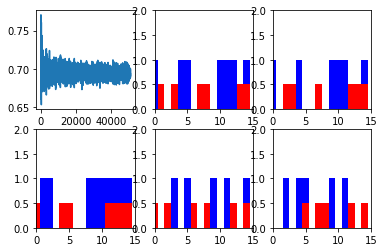

Step 400 Loss 0.6960708


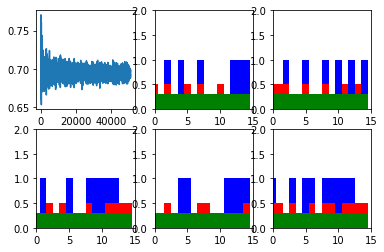

Step 500 Loss 0.6931232


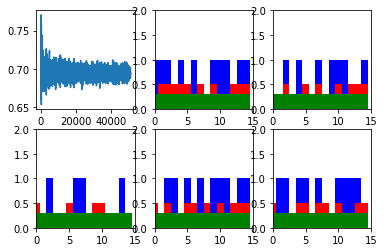

Step 600 Loss 0.6935041


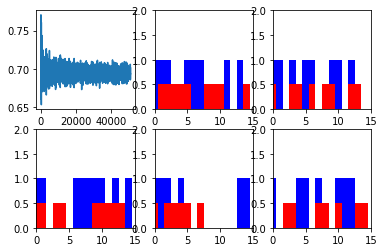

New data, epoch 77
Step 0 Loss 0.70166487


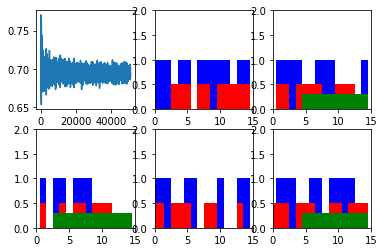

Step 100 Loss 0.69320065


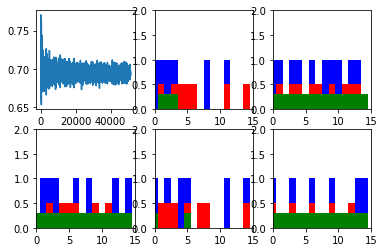

Step 200 Loss 0.6938799


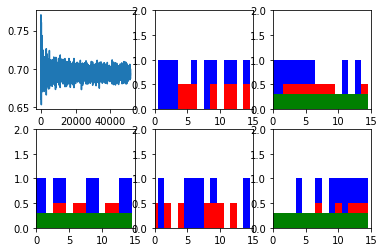

Step 300 Loss 0.6915829


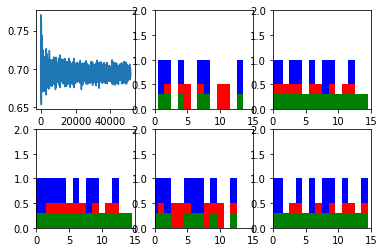

Step 400 Loss 0.6931886


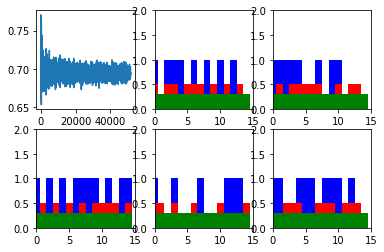

Step 500 Loss 0.69336647


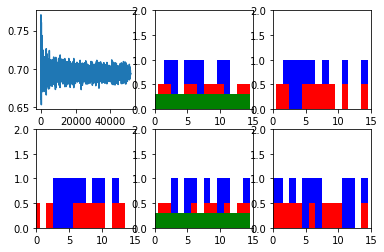

Step 600 Loss 0.6947006


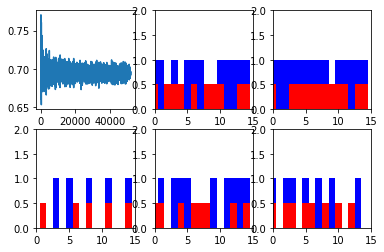

New data, epoch 78
Step 0 Loss 0.6841142


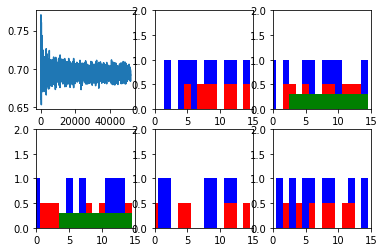

Step 100 Loss 0.6958475


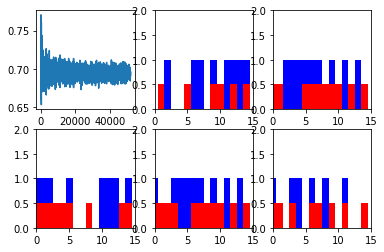

Step 200 Loss 0.69375306


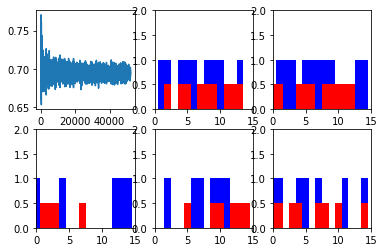

Step 300 Loss 0.6948147


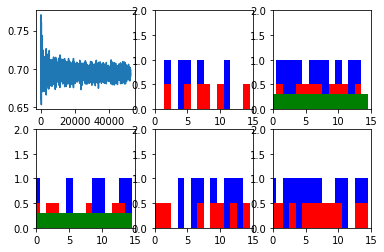

Step 400 Loss 0.69128805


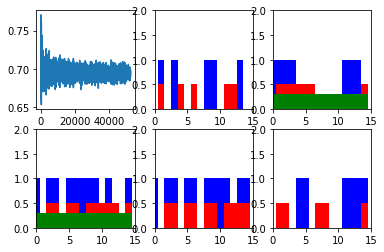

Step 500 Loss 0.6939951


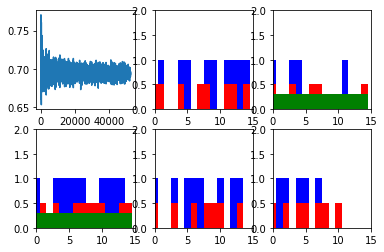

Step 600 Loss 0.69531083


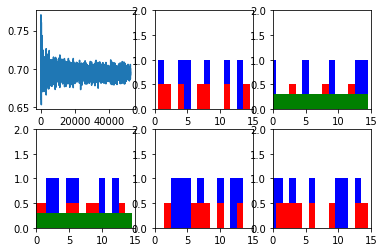

New data, epoch 79
Step 0 Loss 0.69157636


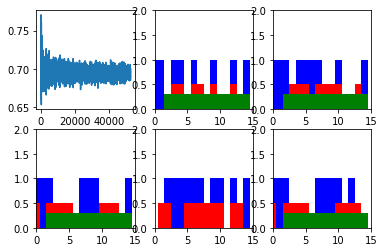

Step 100 Loss 0.6975898


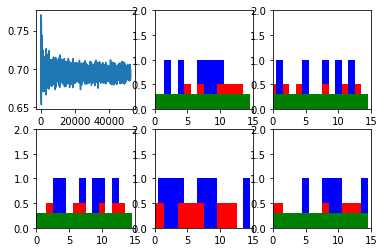

Step 200 Loss 0.69379544


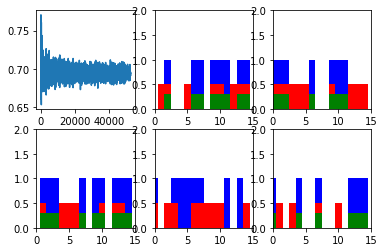

Step 300 Loss 0.69276464


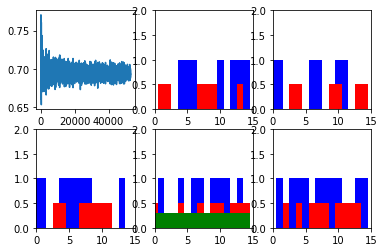

Step 400 Loss 0.6950914


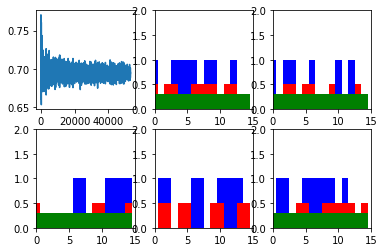

Step 500 Loss 0.6980495


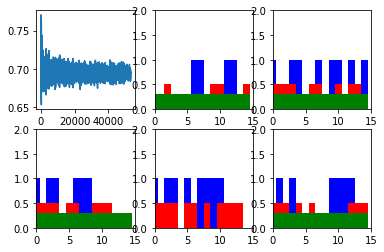

Step 600 Loss 0.69861555


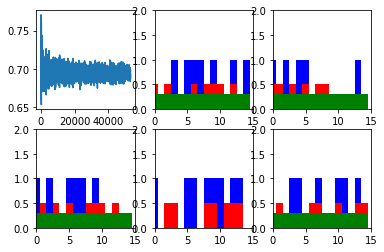

New data, epoch 80
Step 0 Loss 0.6941673


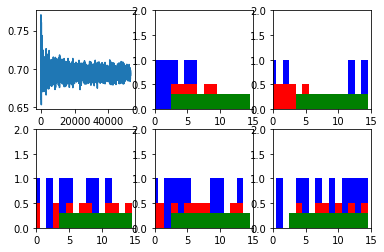

Step 100 Loss 0.6904717


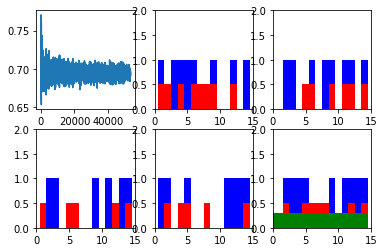

Step 200 Loss 0.6917906


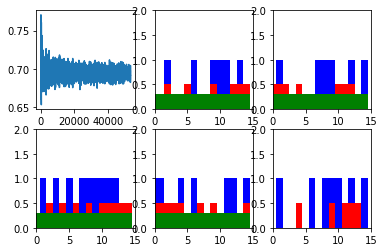

Step 300 Loss 0.6926176


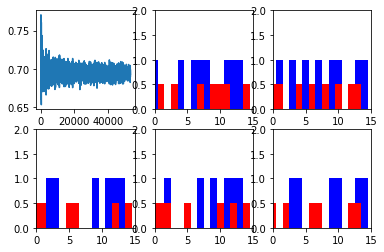

Step 400 Loss 0.69196993


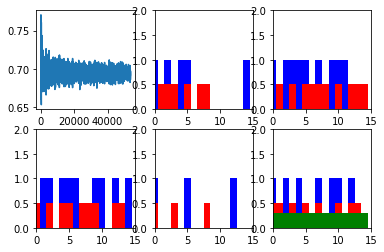

Step 500 Loss 0.69300485


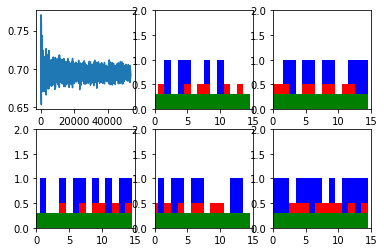

Step 600 Loss 0.6939837


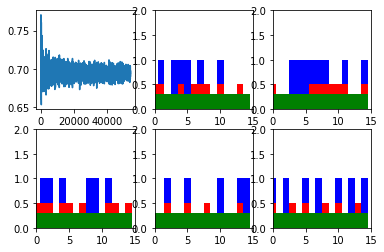

New data, epoch 81
Step 0 Loss 0.6985489


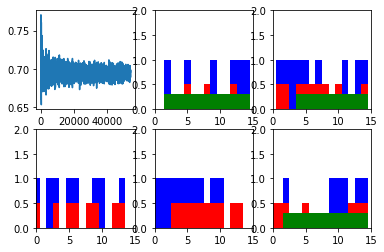

Step 100 Loss 0.69212365


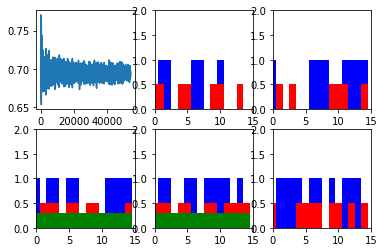

Step 200 Loss 0.69091076


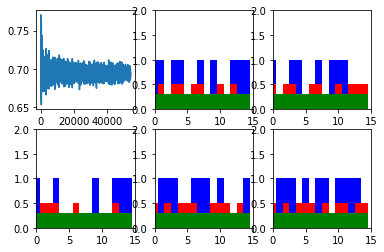

Step 300 Loss 0.6977419


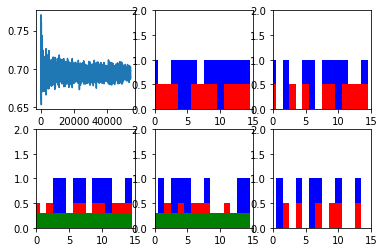

Step 400 Loss 0.697531


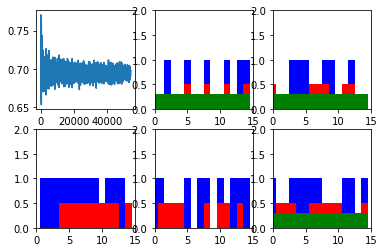

Step 500 Loss 0.6933841


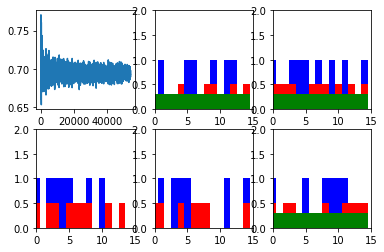

Step 600 Loss 0.68995553


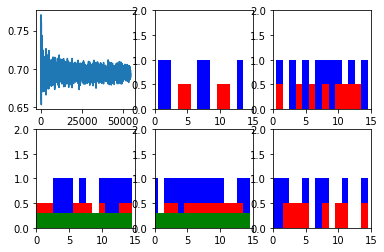

New data, epoch 82
Step 0 Loss 0.69114566


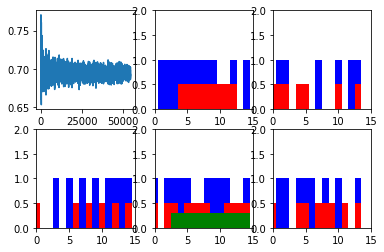

Step 100 Loss 0.69185287


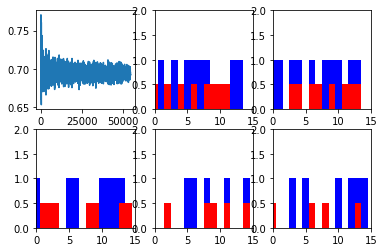

Step 200 Loss 0.69341296


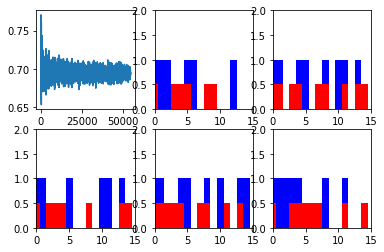

Step 300 Loss 0.69527304


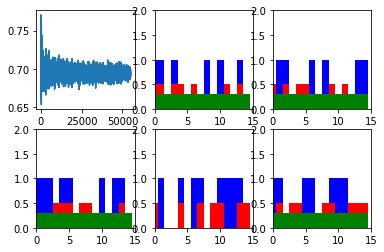

Step 400 Loss 0.69383013


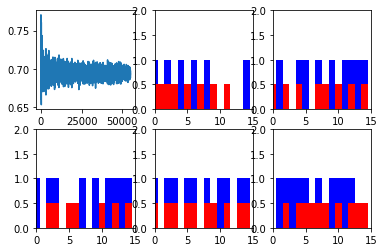

Step 500 Loss 0.6951971


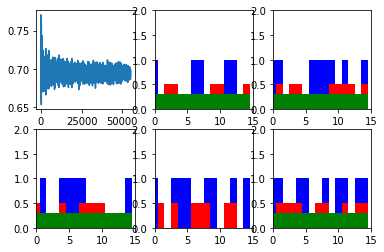

Step 600 Loss 0.6923138


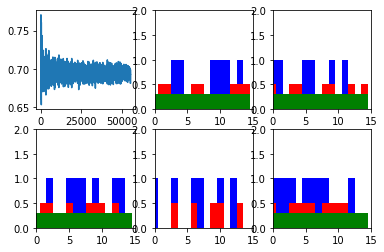

New data, epoch 83
Step 0 Loss 0.69711375


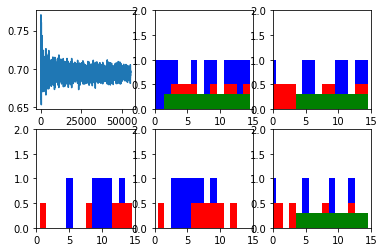

Step 100 Loss 0.69510406


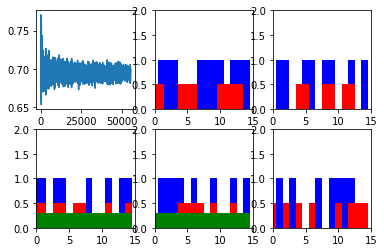

Step 200 Loss 0.692988


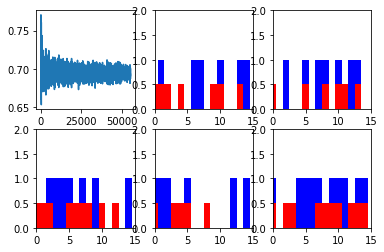

Step 300 Loss 0.69550073


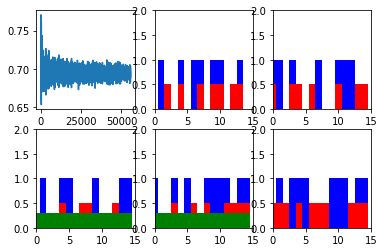

Step 400 Loss 0.6978014


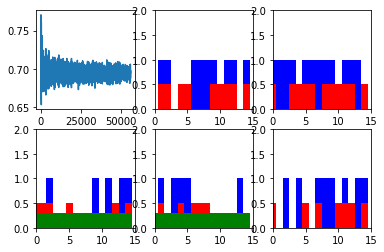

Step 500 Loss 0.6924886


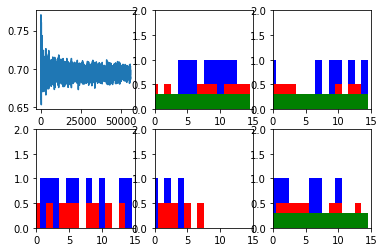

Step 600 Loss 0.694754


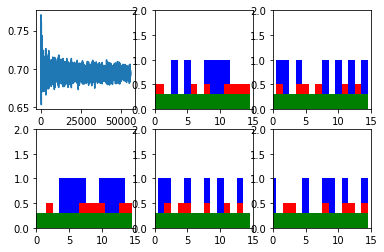

New data, epoch 84
Step 0 Loss 0.68763244


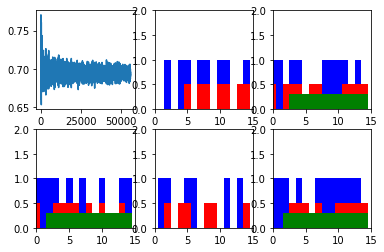

Step 100 Loss 0.6920749


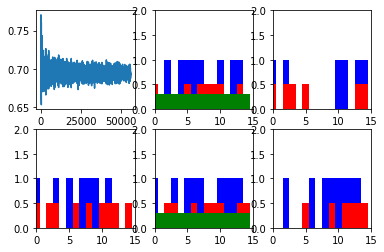

Step 200 Loss 0.6938346


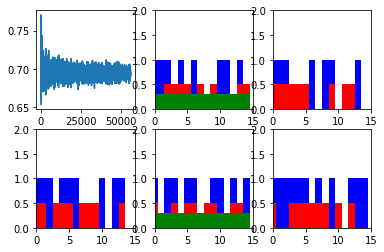

Step 300 Loss 0.6923318


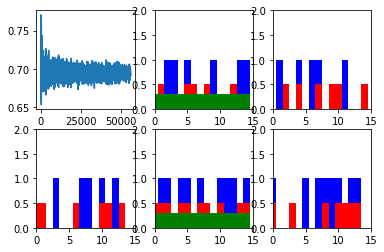

Step 400 Loss 0.69612646


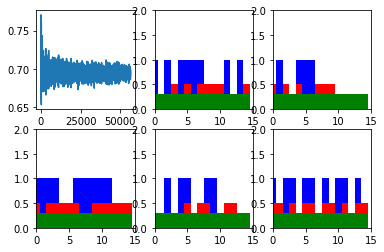

Step 500 Loss 0.698272


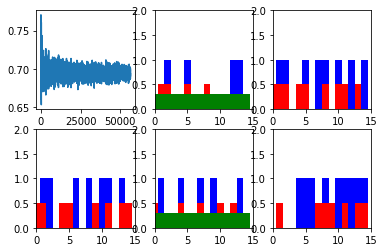

Step 600 Loss 0.6921015


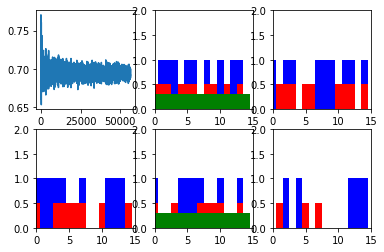

New data, epoch 85
Step 0 Loss 0.6895565


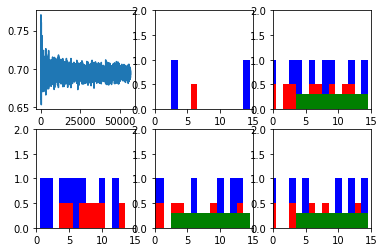

Step 100 Loss 0.69306993


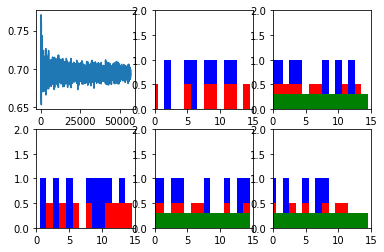

Step 200 Loss 0.6925


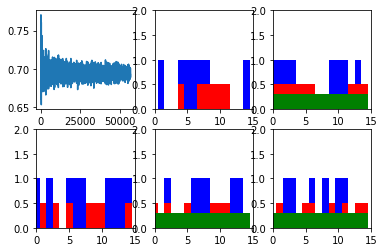

Step 300 Loss 0.6930056


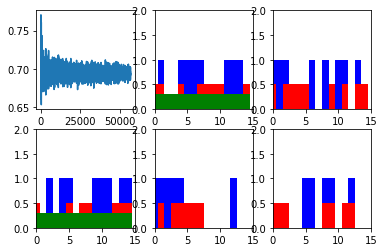

Step 400 Loss 0.68792754


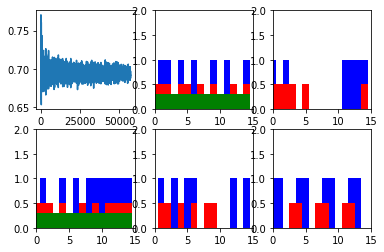

Step 500 Loss 0.6912445


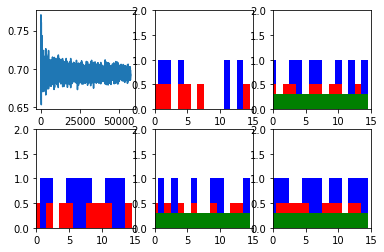

Step 600 Loss 0.6940753


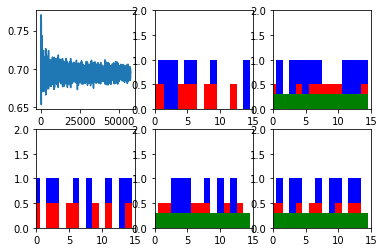

New data, epoch 86
Step 0 Loss 0.686994


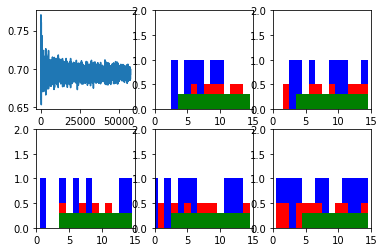

Step 100 Loss 0.6934326


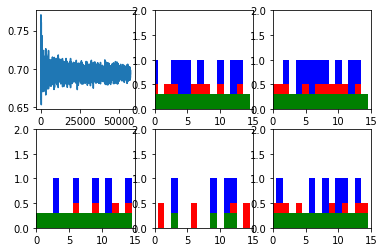

Step 200 Loss 0.6906074


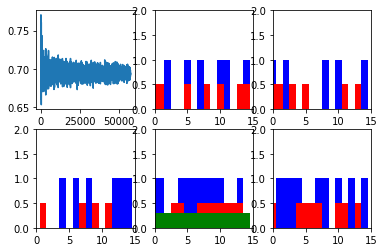

Step 300 Loss 0.69824845


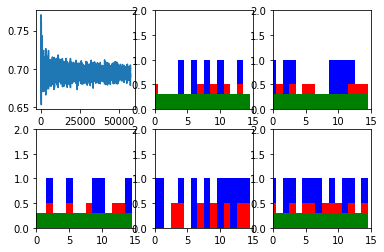

Step 400 Loss 0.6910797


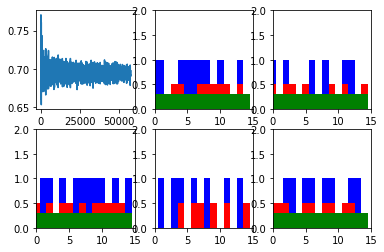

Step 500 Loss 0.69255525


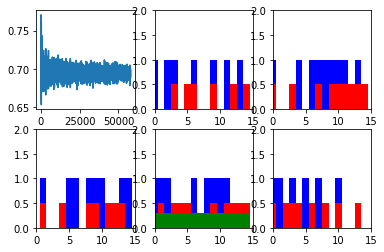

Step 600 Loss 0.68622696


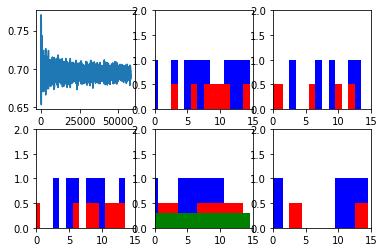

New data, epoch 87
Step 0 Loss 0.68822724


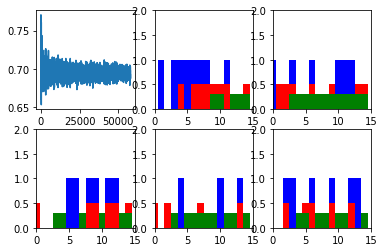

Step 100 Loss 0.69394225


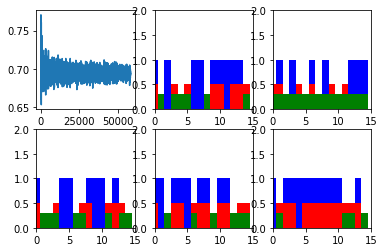

Step 200 Loss 0.69200766


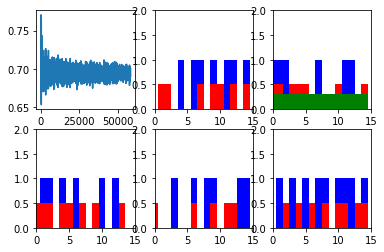

Step 300 Loss 0.6929739


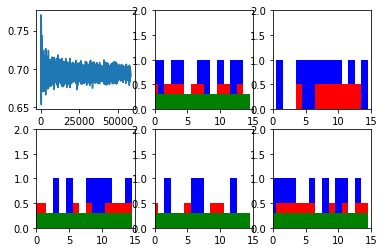

Step 400 Loss 0.6934466


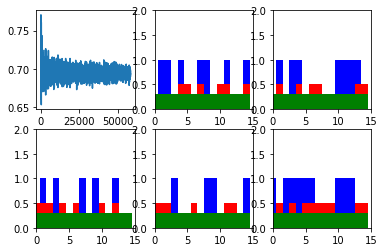

Step 500 Loss 0.69236284


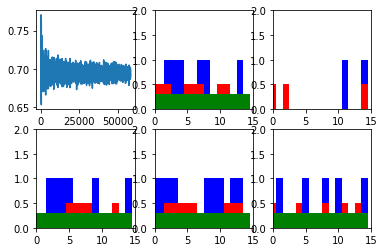

Step 600 Loss 0.6935904


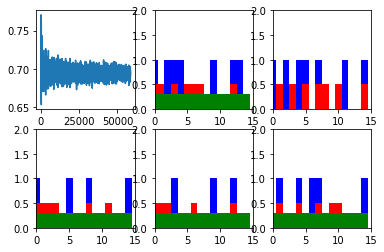

New data, epoch 88
Step 0 Loss 0.6834115


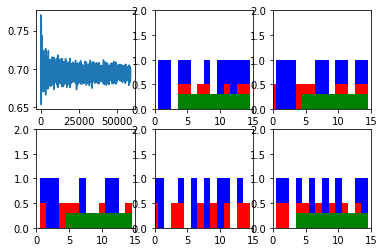

Step 100 Loss 0.6932802


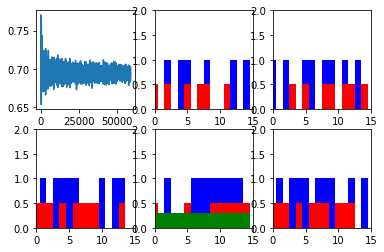

Step 200 Loss 0.6904827


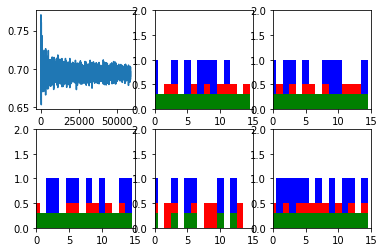

Step 300 Loss 0.69495976


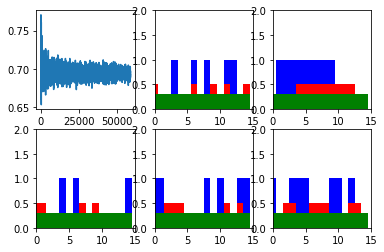

Step 400 Loss 0.69664013


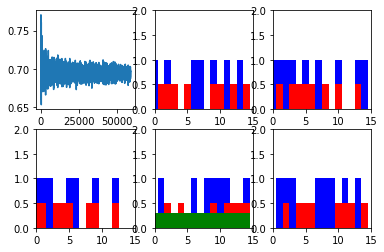

Step 500 Loss 0.6923341


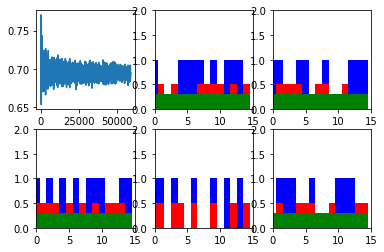

Step 600 Loss 0.6940996


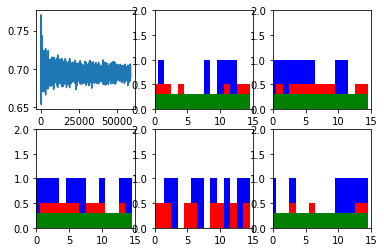

New data, epoch 89
Step 0 Loss 0.6920845


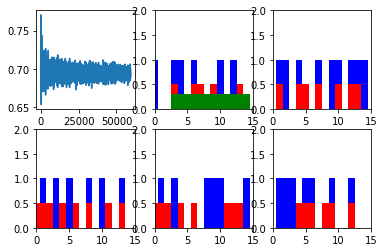

Step 100 Loss 0.69301546


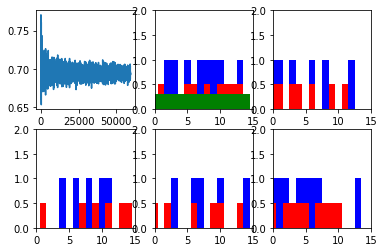

Step 200 Loss 0.6930988


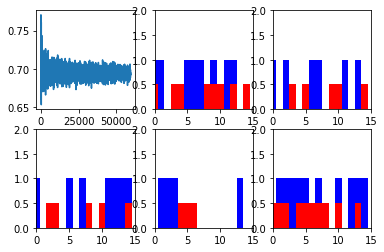

Step 300 Loss 0.6940889


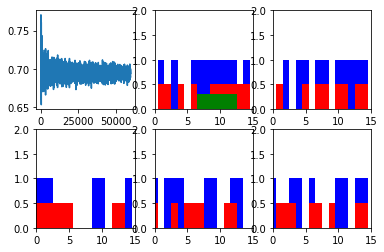

Step 400 Loss 0.69406754


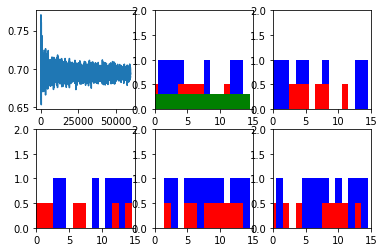

Step 500 Loss 0.69121414


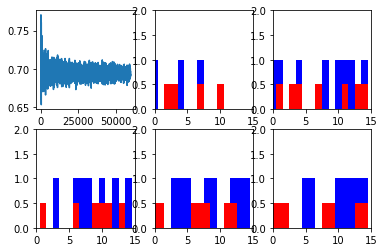

Step 600 Loss 0.69389814


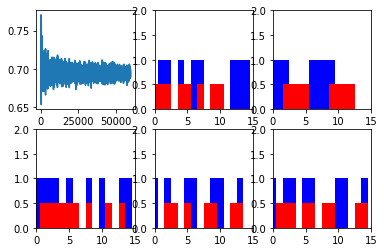

New data, epoch 90
Step 0 Loss 0.6873871


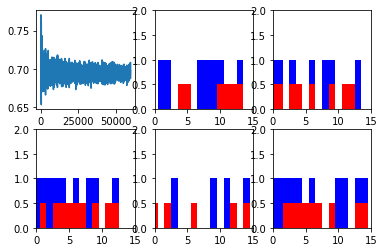

Step 100 Loss 0.6927863


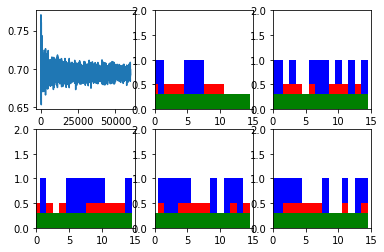

Step 200 Loss 0.692673


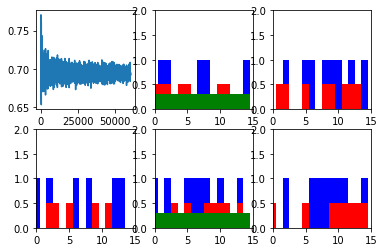

Step 300 Loss 0.6963507


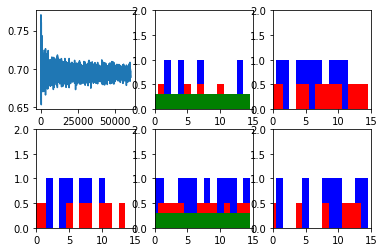

Step 400 Loss 0.6958845


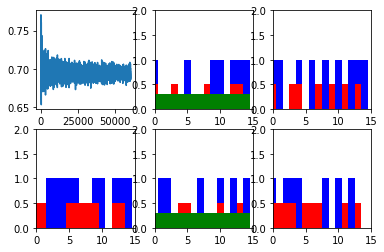

Step 500 Loss 0.69562024


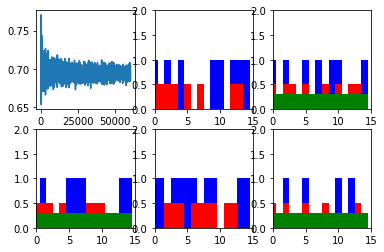

Step 600 Loss 0.6947637


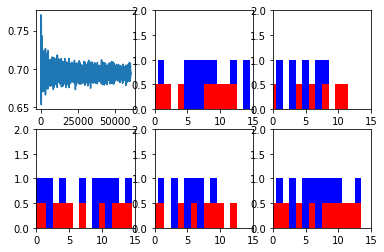

New data, epoch 91
Step 0 Loss 0.6873595


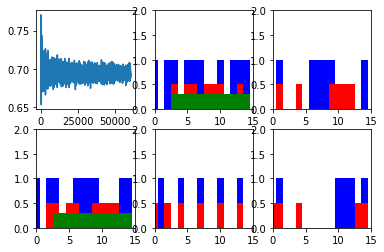

Step 100 Loss 0.6890205


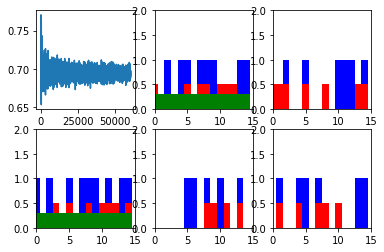

Step 200 Loss 0.6952302


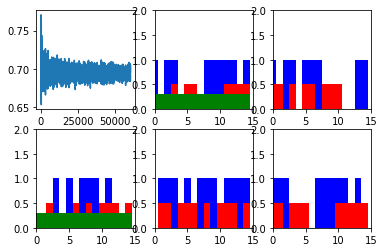

Step 300 Loss 0.6942206


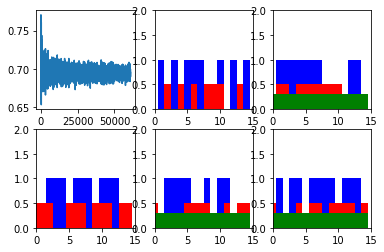

Step 400 Loss 0.6946891


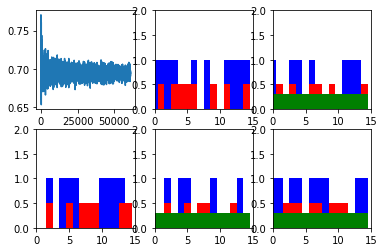

Step 500 Loss 0.69554627


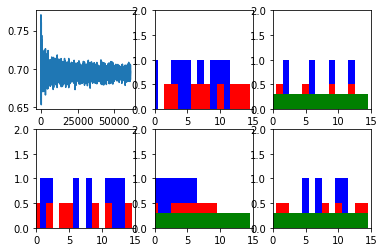

Step 600 Loss 0.6945095


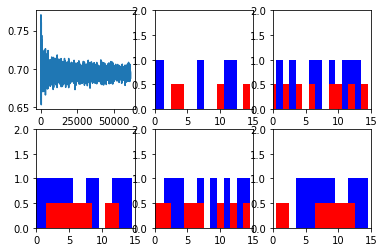

New data, epoch 92
Step 0 Loss 0.6860042


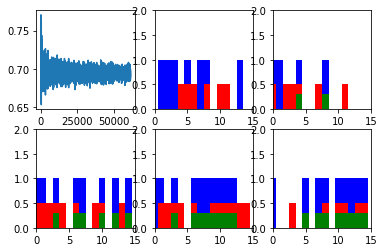

Step 100 Loss 0.6914603


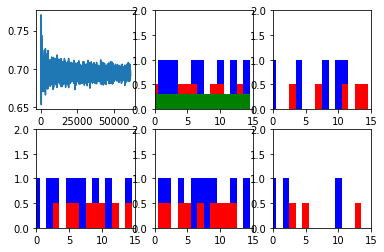

Step 200 Loss 0.6943351


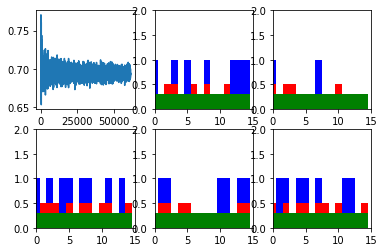

Step 300 Loss 0.69532377


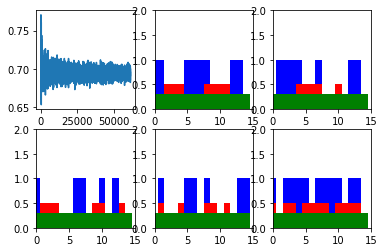

Step 400 Loss 0.6937863


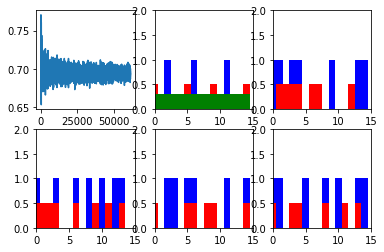

Step 500 Loss 0.6938074


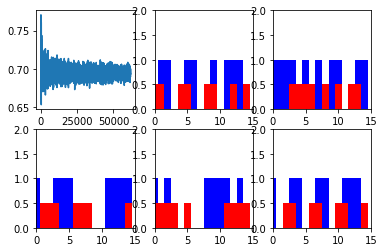

Step 600 Loss 0.69316673


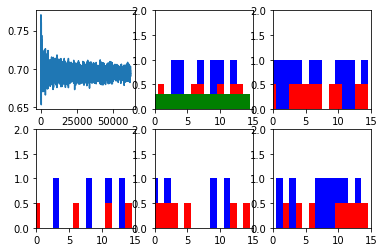

New data, epoch 93
Step 0 Loss 0.69257903


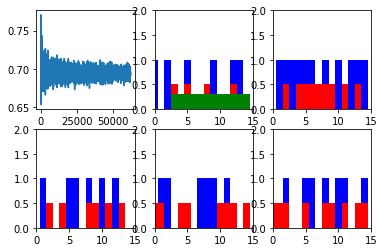

Step 100 Loss 0.6899447


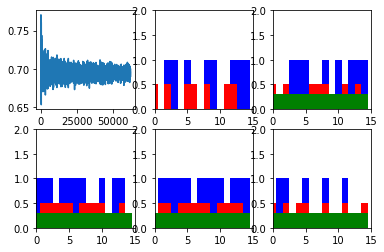

Step 200 Loss 0.69344616


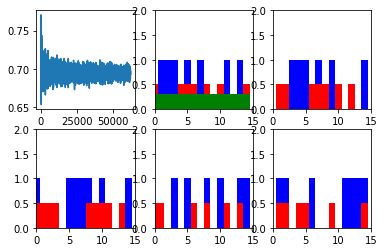

Step 300 Loss 0.69170827


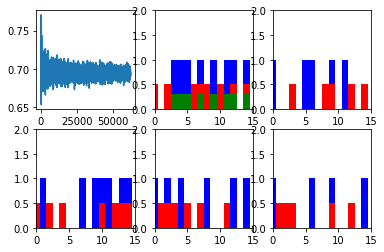

Step 400 Loss 0.6942183


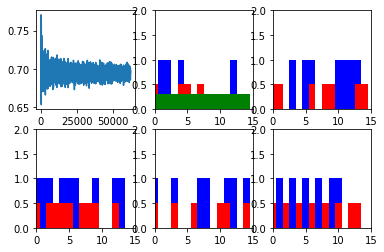

Step 500 Loss 0.69272906


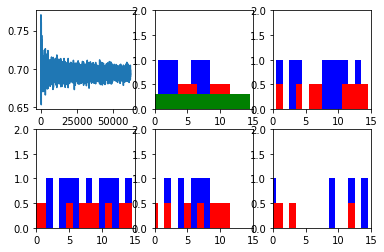

Step 600 Loss 0.69401175


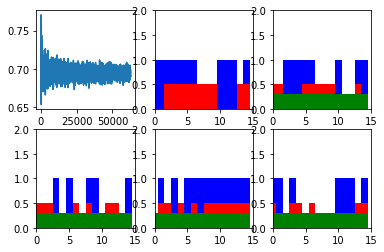

New data, epoch 94
Step 0 Loss 0.68591297


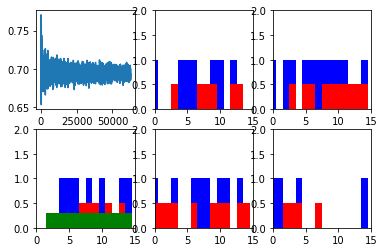

Step 100 Loss 0.69491667


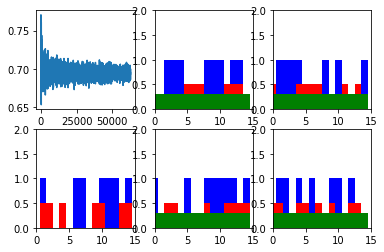

Step 200 Loss 0.6987941


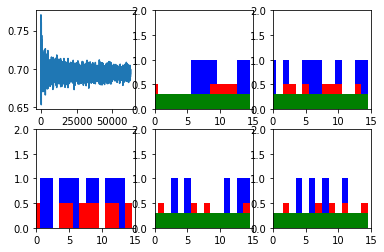

Step 300 Loss 0.6906736


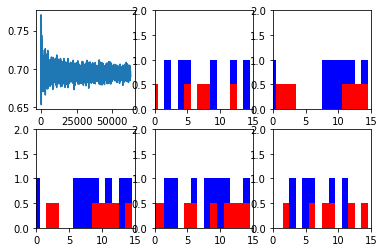

Step 400 Loss 0.69413793


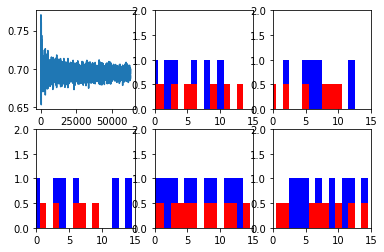

Step 500 Loss 0.695804


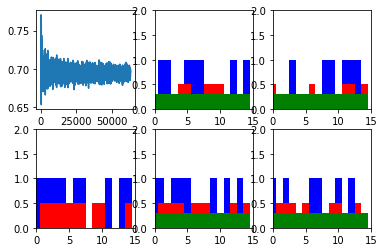

Step 600 Loss 0.69257146


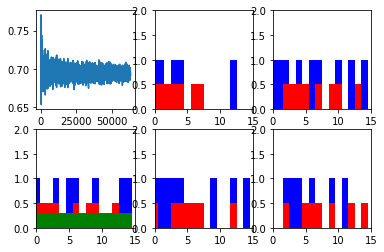

New data, epoch 95
Step 0 Loss 0.6883873


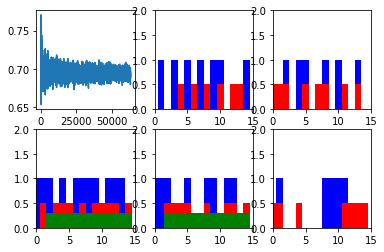

Step 100 Loss 0.69440067


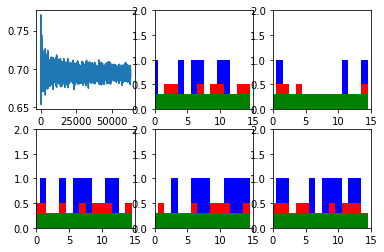

Step 200 Loss 0.687935


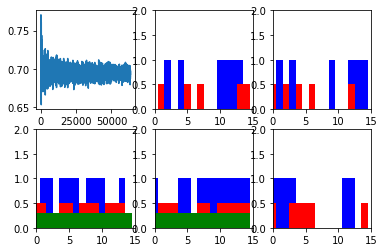

Step 300 Loss 0.69174975


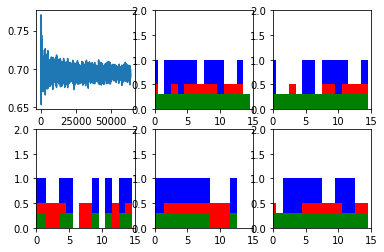

Step 400 Loss 0.69307065


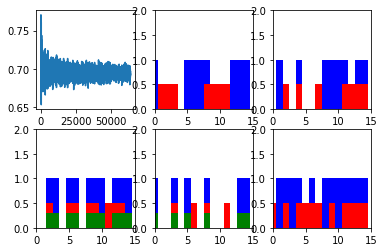

Step 500 Loss 0.6928102


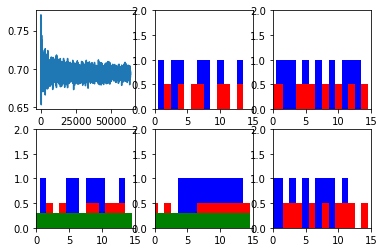

Step 600 Loss 0.68954676


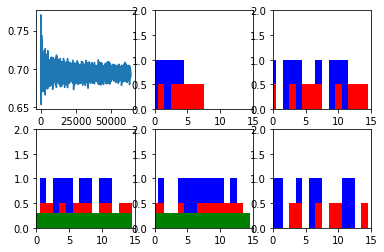

New data, epoch 96
Step 0 Loss 0.6908434


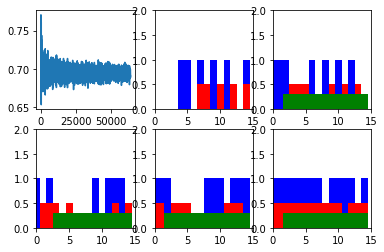

Step 100 Loss 0.6975486


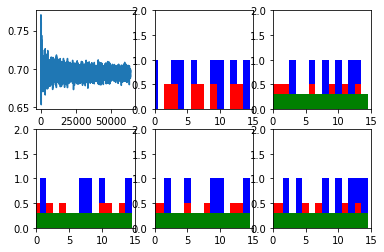

Step 200 Loss 0.69221205


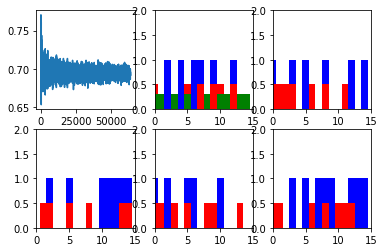

Step 300 Loss 0.6936312


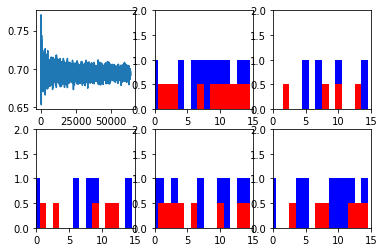

Step 400 Loss 0.6941354


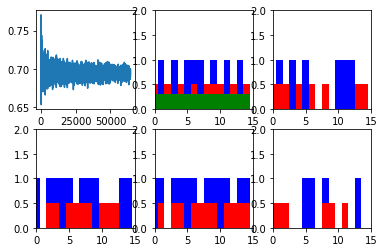

Step 500 Loss 0.6935103


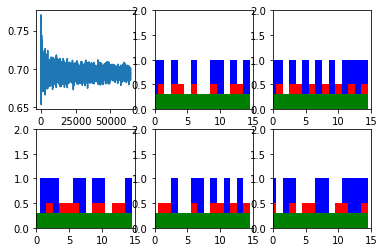

Step 600 Loss 0.69683486


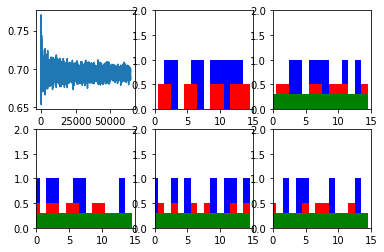

New data, epoch 97
Step 0 Loss 0.69069046


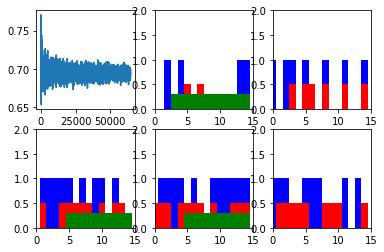

Step 100 Loss 0.6926676


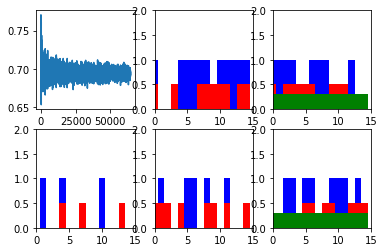

Step 200 Loss 0.69326836


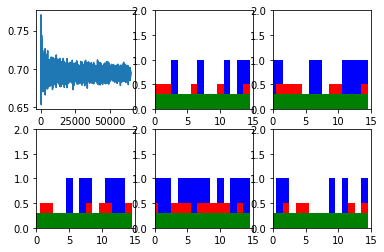

Step 300 Loss 0.69276375


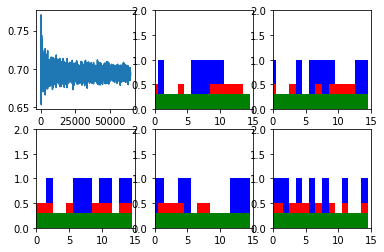

Step 400 Loss 0.6938056


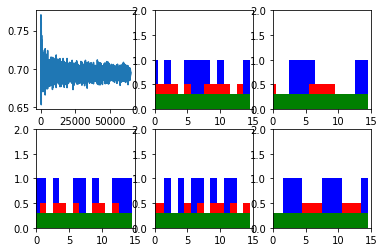

Step 500 Loss 0.69406676


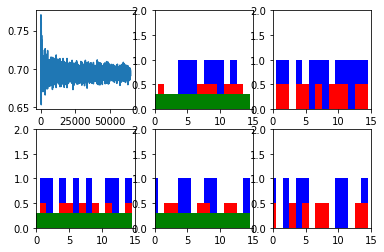

Step 600 Loss 0.6919187


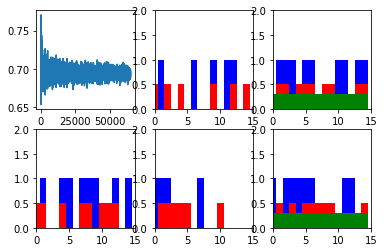

New data, epoch 98
Step 0 Loss 0.693306


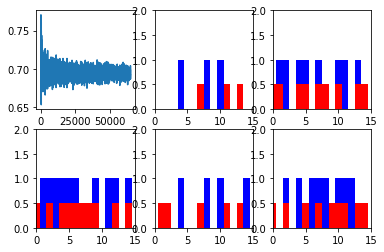

Step 100 Loss 0.6946985


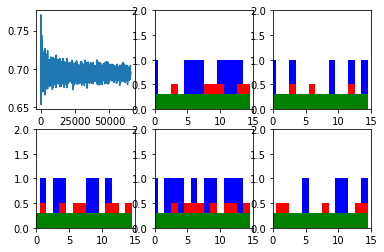

Step 200 Loss 0.69287163


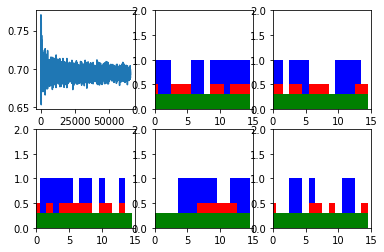

Step 300 Loss 0.69268227


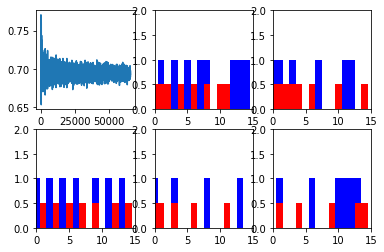

Step 400 Loss 0.70062137


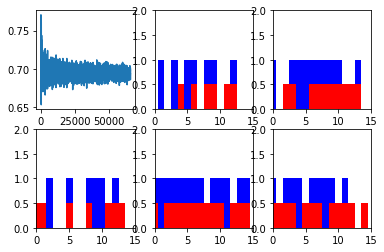

Step 500 Loss 0.69311446


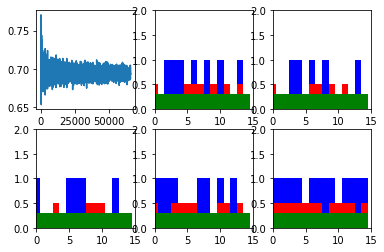

Step 600 Loss 0.69224274


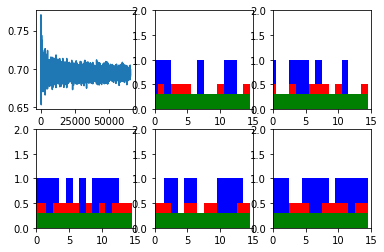

New data, epoch 99
Step 0 Loss 0.67990994


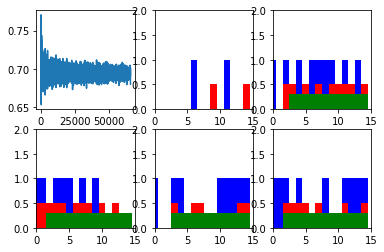

Step 100 Loss 0.6923282


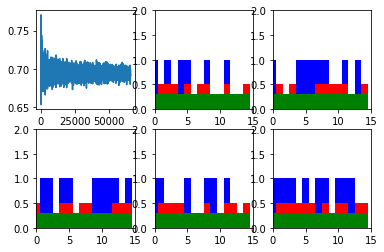

Step 200 Loss 0.6933994


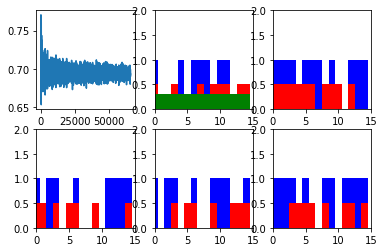

Step 300 Loss 0.69309527


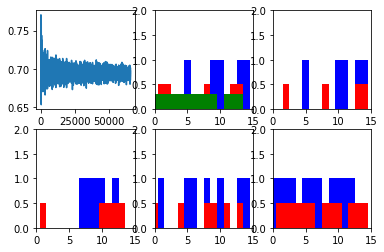

Step 400 Loss 0.69236225


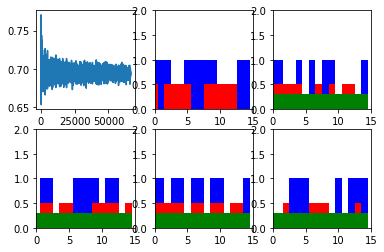

Step 500 Loss 0.6933854


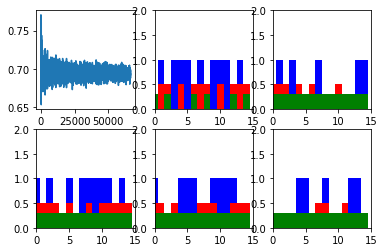

Step 600 Loss 0.6932272


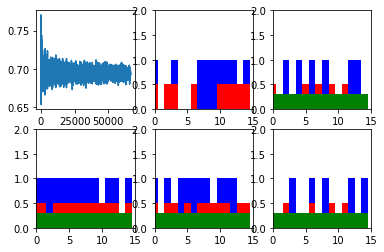

In [14]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()